In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CSVファイルを読み込む
df = pd.read_csv('~/lab/data/dataset/dataset_all.csv')

# データフレームの基本情報を表示
print("データフレームの形状:", df.shape)
print("\nデータフレームの最初の行:")
print(df.head())
print("\nデータフレームの統計情報:")
print(df.describe())
print("\nデータ型:")
print(df.dtypes)
print("\nNULL値の確認:")
print(df.isnull().sum())

# Charge_err(pC)列の存在確認
if 'Charge_err(pC)' in df.columns:
    print("\n✓ Charge_err(pC)列が存在します")
    print("Charge_err(pC)の統計:")
    print(df['Charge_err(pC)'].describe())
else:
    print("\n✗ 警告: Charge_err(pC)列が見つかりません")
    print("利用可能な列:", df.columns.tolist())

データフレームの形状: (1068, 13)

データフレームの最初の行:
   #PMT_num  Charge(pC)  Charge_err(pC)  light_power(def:(15dB, 5V)=1)  \
0         1     1.83704        0.363831                       0.279857   
1         2     9.33347        0.027628                       0.279857   
2         3    26.87980        0.048025                       0.279857   
3         4     8.95515        2.396030                       0.279857   
4         1     1.34065        0.247728                       0.280068   

   attenuation_db  pd_volt   x   y    z           r  cos(alpha)  \
0              20  4.42493 -35 -35  157  103.693057    0.737754   
1              20  4.42493 -35 -35  157  125.108953    0.611467   
2              20  4.42493 -35 -35  157   76.500000    1.000000   
3              20  4.42493 -35 -35  157  103.693057    0.737754   
4              20  4.42826 -35 -35  147   96.551800    0.688749   

   r_from_center  cos(alpha_from_center)  
0     129.541499                0.841429  
1     147.244694            

Filtered raw rows: 16
After threshold (>=20): 12
     #PMT_num  Charge(pC)  Charge_err(pC)  light_power(def:(15dB, 5V)=1)  \
104         1    177.6820        0.198939                       0.981200   
136         1     55.2164        0.072638                       0.309555   
148         1     80.4424        0.102947                       0.309650   
228         1    393.0390        0.415033                       0.981700   
236         1     80.8508        0.105978                       0.982250   

     attenuation_db  pd_volt   x   y    z     r  cos(alpha)  r_from_center  \
104              15  4.90600 -35  35  117  36.5         1.0           69.0   
136              20  4.89450 -35  35  117  36.5         1.0           69.0   
148              20  4.89600 -35  35  107  26.5         1.0           59.0   
228              15  4.90850 -35  35   97  16.5         1.0           49.0   
236              15  4.91125 -35  35  147  66.5         1.0           99.0   

     cos(alpha_from_cente

/tmp/ipykernel_1205/2457895615.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['charge_per_power'] = filtered_df['Charge(pC)'] / filtered_df['light_power(def:(15dB, 5V)=1)']


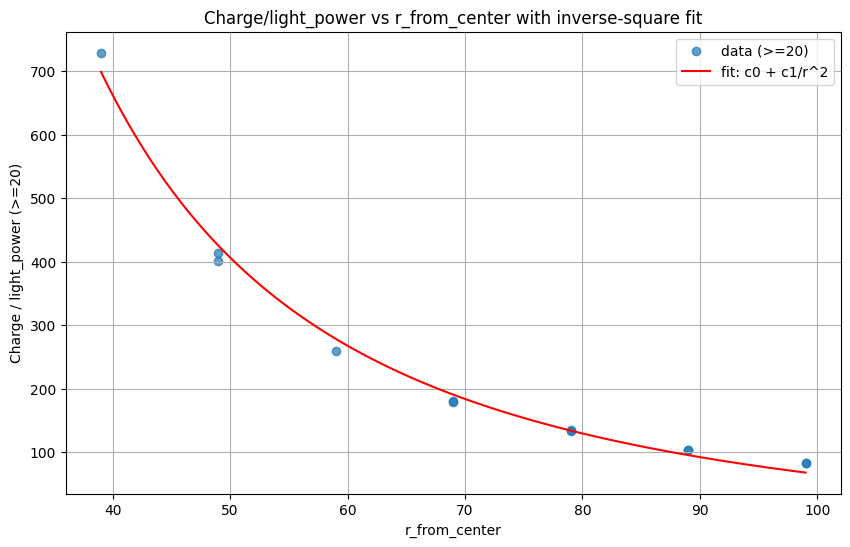

In [ ]:
# Filter the dataframe for PMT_num=1, x=-35, y=35
filtered_df = df[(df['#PMT_num'] == 1) & (df['x'] == -35) & (df['y'] == 35)]
print("Filtered raw rows:", len(filtered_df))

# Compute Charge/light_power and apply threshold >= 20
filtered_df['charge_per_power'] = filtered_df['Charge(pC)'] / filtered_df['light_power(def:(15dB, 5V)=1)']
filtered_df = filtered_df[filtered_df['charge_per_power'] >= 20]
print("After threshold (>=20):", len(filtered_df))
print(filtered_df.head())

# Prepare arrays for fitting
import numpy as np
from scipy.optimize import curve_fit

x = filtered_df['r_from_center'].to_numpy(dtype=float)
y = filtered_df['charge_per_power'].to_numpy(dtype=float)
mask = np.isfinite(x) & np.isfinite(y) & (x > 0)
x = x[mask]
y = y[mask]

# Define model: y = c0 + c1 / r^2
def inv_square_model(r, c0, c1):
    return c0 + c1 / (r ** 2)

# Initial guesses
c0_init = 100.0
c1_init = 6000.0
p0 = [c0_init, c1_init]

# Range for plotting
x_min, x_max = float(np.min(x)), float(np.max(x))

# Fit
try:
    popt, pcov = curve_fit(inv_square_model, x, y, p0=p0, maxfev=20000)
    c0, c1 = popt
    print(f"Fit succeeded: c0={c0:.4g}, c1={c1:.4g}")
except Exception as e:
    print("Fit failed:", e)
    c0, c1 = p0

# Plot: scatter + fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='data (>=20)', alpha=0.7)

x_fit = np.linspace(x_min, x_max, 400)
y_fit = inv_square_model(x_fit, c0, c1)
plt.plot(x_fit, y_fit, color='red', label='fit: c0 + c1/r^2')

plt.xlabel('r_from_center')
plt.ylabel('Charge / light_power (>=20)')
plt.title('Charge/light_power vs r_from_center with inverse-square fit')
plt.grid(True)
plt.legend()
plt.show()

Sqrt-model fit succeeded: c0=-11.79, c1=1656


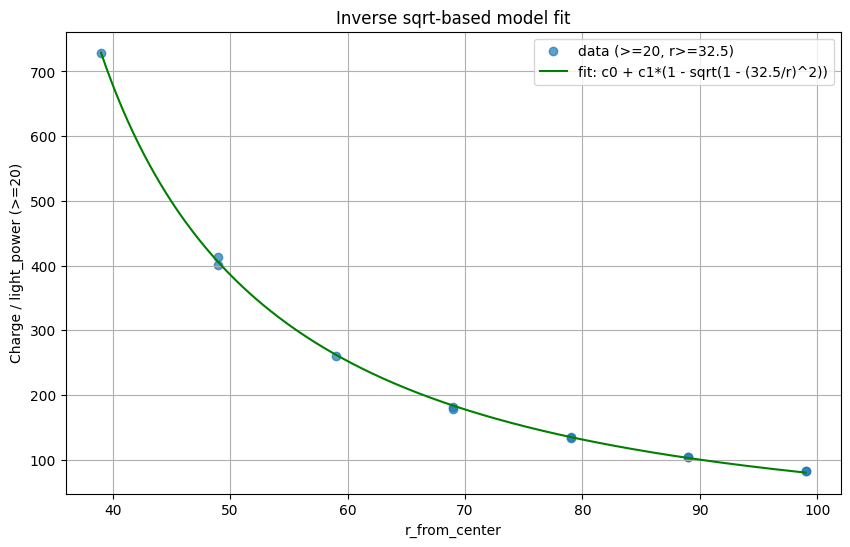

In [ ]:
# Fit with y = c0 + c1 * (1 - sqrt(1 - (32.5/r_from_center)^2))
import numpy as np
from scipy.optimize import curve_fit

# Ensure filtered_df is available
try:
    _ = filtered_df
except NameError:
    raise RuntimeError("Cell 2 must be run first to define filtered_df.")

# Prepare arrays (apply domain mask r>=32.5 and finite values)
a_const = 32.5
x = filtered_df['r_from_center'].to_numpy(dtype=float)
y = filtered_df['charge_per_power'].to_numpy(dtype=float)
mask = np.isfinite(x) & np.isfinite(y) & (x >= a_const)
x = x[mask]
y = y[mask]

def sqrt_model(r, c0, c1):
    # y = c0 + c1 * (1 - sqrt(1 - (a/r)^2))
    a = a_const
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a / r) ** 2))

# Initial guesses
p0 = [100.0, 6000.0]

# Plot range
x_min = float(np.min(x)) if x.size else a_const
x_max = float(np.max(x)) if x.size else a_const + 1.0

# Fit
try:
    popt, pcov = curve_fit(sqrt_model, x, y, p0=p0, maxfev=20000)
    c0_s, c1_s = popt
    print(f"Sqrt-model fit succeeded: c0={c0_s:.4g}, c1={c1_s:.4g}")
except Exception as e:
    print("Sqrt-model fit failed:", e)
    c0_s, c1_s = p0

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='data (>=20, r>=32.5)', alpha=0.7)

x_fit = np.linspace(max(a_const, x_min), x_max, 400)
y_fit = sqrt_model(x_fit, c0_s, c1_s)
plt.plot(x_fit, y_fit, color='green', label='fit: c0 + c1*(1 - sqrt(1 - (32.5/r)^2))')

plt.xlabel('r_from_center')
plt.ylabel('Charge / light_power (>=20)')
plt.title('Inverse sqrt-based model fit')
plt.grid(True)
plt.legend()
plt.show()


Processing PMT 1 (x=-35, y=35)
Raw rows: 16
After threshold (>=20): 12
After r >= 32.5 filter: 12
Weighted fit succeeded: c0=-9.366, c1=1636
Chi2=1588, NDF=10, Chi2/NDF=158.8


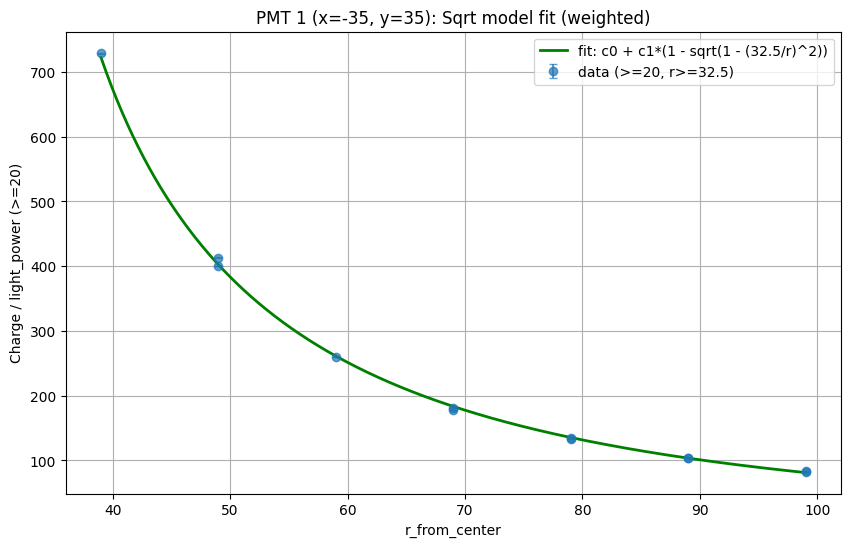


Processing PMT 2 (x=35, y=35)
Raw rows: 16
After threshold (>=20): 15
After r >= 32.5 filter: 15
Weighted fit succeeded: c0=-9.419, c1=1692
Chi2=1.006e+04, NDF=13, Chi2/NDF=773.8


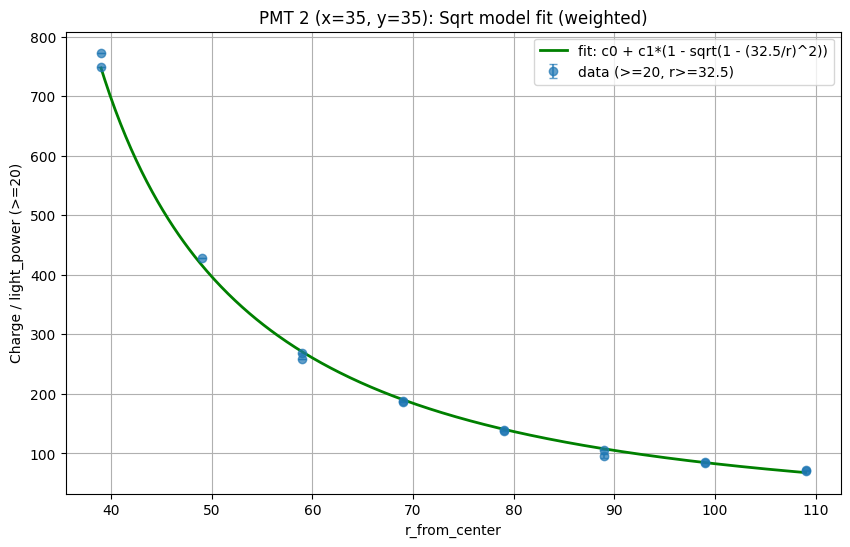


Processing PMT 3 (x=-35, y=-35)
Raw rows: 22
After threshold (>=20): 22
After r >= 32.5 filter: 22
Weighted fit succeeded: c0=-2.47, c1=2117
Chi2=1.473e+04, NDF=20, Chi2/NDF=736.7


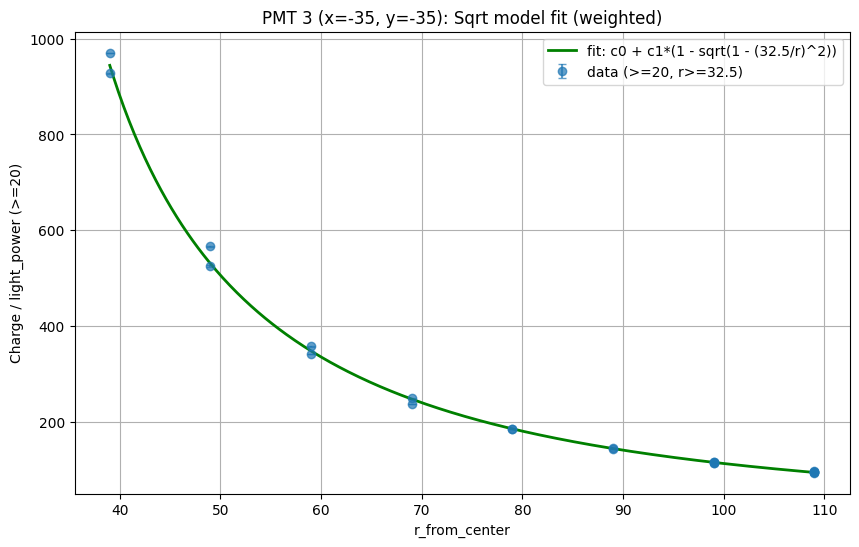


Processing PMT 4 (x=35, y=-35)
Raw rows: 16
After threshold (>=20): 16
After r >= 32.5 filter: 16
Weighted fit succeeded: c0=-7.485, c1=1890
Chi2=6243, NDF=14, Chi2/NDF=445.9


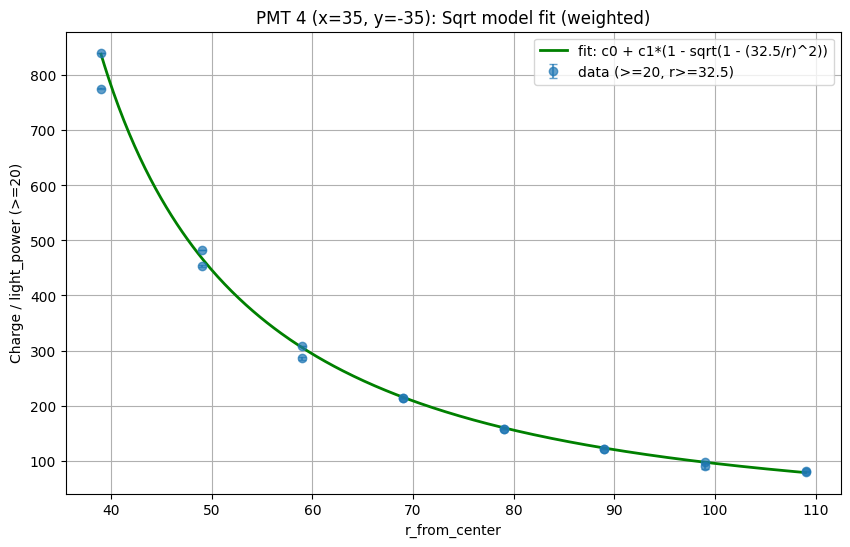

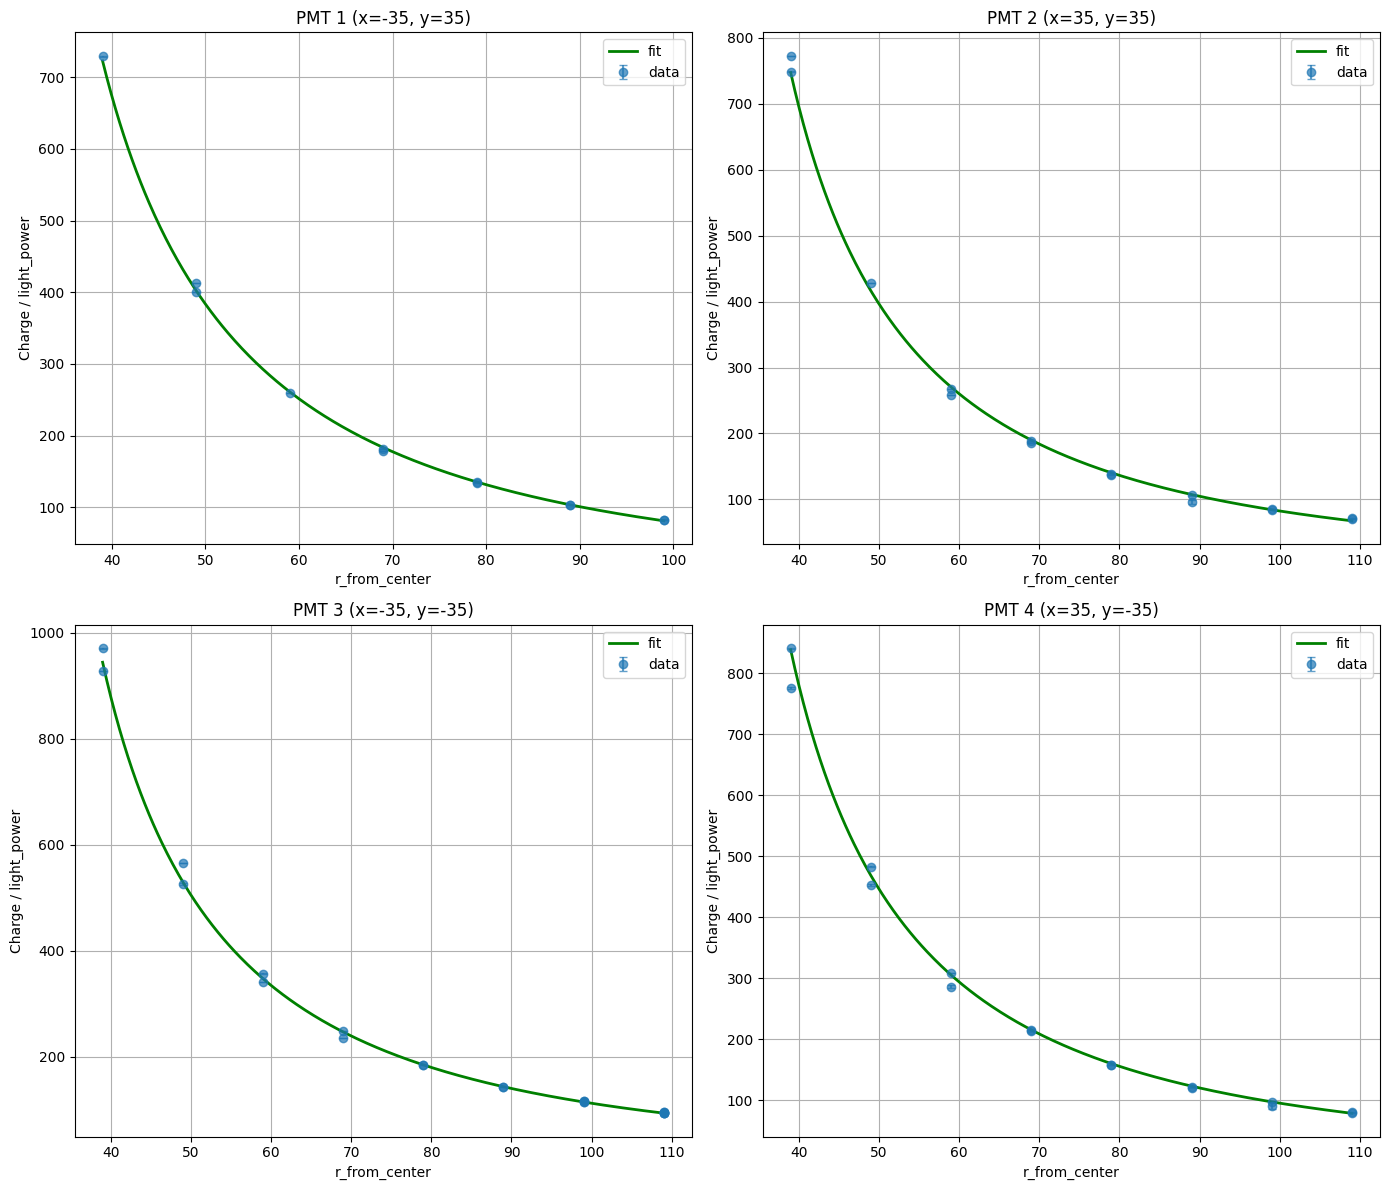


FITTING RESULTS SUMMARY (Sqrt Model with Weighted Fit)
 PMT        (x,y)  N_pts           c0           c1         Chi2   NDF   Chi2/NDF   Status
------------------------------------------------------------------------------------------
   1     (-35,35)     12       -9.366         1636         1588    10      158.8       OK
   2      (35,35)     15       -9.419         1692    1.006e+04    13      773.8       OK
   3    (-35,-35)     22        -2.47         2117    1.473e+04    20      736.7       OK
   4     (35,-35)     16       -7.485         1890         6243    14      445.9       OK


In [ ]:
# PMT 1~4 の処理: フィルタ・フィット・プロット (sqrt model with error bars)
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# PMT設定: (PMT番号, x座標, y座標)
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

# モデル定義: y = c0 + c1 * (1 - sqrt(1 - (32.5/r)^2))
a_const = 32.5

def sqrt_model(r, c0, c1):
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

# 初期値
c0_init = 0.0
c1_init = 1600.0

# 結果格納用
results = []
plot_data = []

# 各PMTについて処理
for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\n{'='*60}")
    print(f"Processing PMT {pmt_num} (x={x_coord}, y={y_coord})")
    print('='*60)
    
    # フィルタリング
    filtered = df[(df['#PMT_num'] == pmt_num) & 
                  (df['x'] == x_coord) & 
                  (df['y'] == y_coord)].copy()
    print(f"Raw rows: {len(filtered)}")
    
    # charge/light_power計算と閾値適用
    filtered['charge_per_power'] = filtered['Charge(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    
    # エラー伝播: err(Q/A) = |Q/A| * sqrt((err_Q/Q)^2 + (err_A/A)^2)
    # ここではlight_powerのエラーがないので、err(Q/A) ≈ err_Q / A
    filtered['charge_per_power_err'] = filtered['Charge_err(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    
    filtered = filtered[filtered['charge_per_power'] >= 20]
    print(f"After threshold (>=20): {len(filtered)}")
    
    # 配列準備 (r >= 32.5 の条件を追加)
    x = filtered['r_from_center'].to_numpy(dtype=float)
    y = filtered['charge_per_power'].to_numpy(dtype=float)
    y_err = filtered['charge_per_power_err'].to_numpy(dtype=float)
    
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (x >= a_const) & (y_err > 0)
    x = x[mask]
    y = y[mask]
    y_err = y_err[mask]
    
    print(f"After r >= {a_const} filter: {len(x)}")
    
    if len(x) == 0:
        print(f"Warning: No valid data for PMT {pmt_num}")
        results.append({
            'pmt': pmt_num,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'c0': None,
            'c1': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': 0
        })
        continue
    
    # Weighted フィット (sigma = y_err)
    try:
        popt, pcov = curve_fit(sqrt_model, x, y, p0=[c0_init, c1_init], 
                               sigma=y_err, absolute_sigma=True, maxfev=20000)
        c0, c1 = popt
        
        # chi2計算 (weighted)
        y_fit_vals = sqrt_model(x, c0, c1)
        residuals = (y - y_fit_vals) / y_err
        chi2 = np.sum(residuals**2)
        ndf = len(x) - 2  # データ点数 - パラメータ数
        chi2_ndf = chi2 / ndf if ndf > 0 else float('inf')
        
        success = True
        print(f"Weighted fit succeeded: c0={c0:.4g}, c1={c1:.4g}")
        print(f"Chi2={chi2:.4g}, NDF={ndf}, Chi2/NDF={chi2_ndf:.4g}")
    except Exception as e:
        print(f"Fit failed: {e}")
        c0, c1 = c0_init, c1_init
        chi2, ndf, chi2_ndf = None, None, None
        success = False
    
    # 結果保存
    results.append({
        'pmt': pmt_num,
        'x_coord': x_coord,
        'y_coord': y_coord,
        'c0': c0,
        'c1': c1,
        'chi2': chi2,
        'ndf': ndf,
        'chi2_ndf': chi2_ndf,
        'success': success,
        'n_points': len(x)
    })
    
    # プロット用データ保存
    x_min, x_max = float(np.min(x)), float(np.max(x))
    x_fit = np.linspace(max(a_const, x_min), x_max, 400)
    y_fit = sqrt_model(x_fit, c0, c1)
    
    plot_data.append({
        'pmt': pmt_num,
        'x': x,
        'y': y,
        'y_err': y_err,
        'x_fit': x_fit,
        'y_fit': y_fit,
        'x_coord': x_coord,
        'y_coord': y_coord
    })
    
    # 個別プロット (エラーバー付き)
    plt.figure(figsize=(10, 6))
    plt.errorbar(x, y, yerr=y_err, fmt='o', alpha=0.7, capsize=3, label='data (>=20, r>=32.5)')
    plt.plot(x_fit, y_fit, color='green', linewidth=2, label='fit: c0 + c1*(1 - sqrt(1 - (32.5/r)^2))')
    plt.xlabel('r_from_center')
    plt.ylabel('Charge / light_power (>=20)')
    plt.title(f'PMT {pmt_num} (x={x_coord}, y={y_coord}): Sqrt model fit (weighted)')
    plt.grid(True)
    plt.legend()
    plt.show()

# 2x2 サブプロット (エラーバー付き)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, data in enumerate(plot_data):
    ax = axes[idx]
    ax.errorbar(data['x'], data['y'], yerr=data['y_err'], fmt='o', alpha=0.7, capsize=3, label='data')
    ax.plot(data['x_fit'], data['y_fit'], color='green', linewidth=2, label='fit')
    ax.set_xlabel('r_from_center')
    ax.set_ylabel('Charge / light_power')
    ax.set_title(f"PMT {data['pmt']} (x={data['x_coord']}, y={data['y_coord']})")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

# フィット結果まとめ表示
print("\n" + "="*90)
print("FITTING RESULTS SUMMARY (Sqrt Model with Weighted Fit)")
print("="*90)
print(f"{'PMT':>4} {'(x,y)':>12} {'N_pts':>6} {'c0':>12} {'c1':>12} {'Chi2':>12} {'NDF':>5} {'Chi2/NDF':>10} {'Status':>8}")
print("-"*90)
for res in results:
    if res['success']:
        status = "OK"
        c0_str = f"{res['c0']:.4g}"
        c1_str = f"{res['c1']:.4g}"
        chi2_str = f"{res['chi2']:.4g}"
        ndf_str = f"{res['ndf']}"
        chi2ndf_str = f"{res['chi2_ndf']:.4g}"
        n_pts = res['n_points']
        coord = f"({res['x_coord']},{res['y_coord']})"
    else:
        status = "FAILED"
        c0_str = "N/A"
        c1_str = "N/A"
        chi2_str = "N/A"
        ndf_str = "N/A"
        chi2ndf_str = "N/A"
        n_pts = res.get('n_points', 0)
        coord = f"({res.get('x_coord','?')},{res.get('y_coord','?')})"
    
    print(f"{res['pmt']:>4} {coord:>12} {n_pts:>6} {c0_str:>12} {c1_str:>12} {chi2_str:>12} {ndf_str:>5} {chi2ndf_str:>10} {status:>8}")
print("="*90)

In [ ]:
# PMTごとのf(r)関数を定義
# f_i(r) = c0_i + c1_i * (1 - sqrt(1 - (32.5/r)^2))

import numpy as np

# フィット結果から各PMTの係数を抽出
pmt_params = {}
for res in results:
    if res['success']:
        pmt_params[res['pmt']] = {
            'c0': res['c0'],
            'c1': res['c1']
        }

# PMTごとの関数を定義
a_const = 32.5

def f_1(r):
    """PMT 1の距離依存関数"""
    c0 = pmt_params[1]['c0']
    c1 = pmt_params[1]['c1']
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

def f_2(r):
    """PMT 2の距離依存関数"""
    c0 = pmt_params[2]['c0']
    c1 = pmt_params[2]['c1']
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

def f_3(r):
    """PMT 3の距離依存関数"""
    c0 = pmt_params[3]['c0']
    c1 = pmt_params[3]['c1']
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

def f_4(r):
    """PMT 4の距離依存関数"""
    c0 = pmt_params[4]['c0']
    c1 = pmt_params[4]['c1']
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

# 辞書形式でまとめる
f_funcs = {
    1: f_1,
    2: f_2,
    3: f_3,
    4: f_4
}

# 関数の表示
print("="*70)
print("PMT別の距離依存関数 f_i(r)")
print("="*70)
print("Model: f_i(r) = c0_i + c1_i * (1 - sqrt(1 - (32.5/r)^2))")
print()
for pmt, params in pmt_params.items():
    print(f"PMT {pmt}:")
    print(f"  f_{pmt}(r) = {params['c0']:.6f} + {params['c1']:.6f} * (1 - sqrt(1 - (32.5/r)^2))")
    print()

# テスト: 各関数の動作確認
print("="*70)
print("動作確認: r=50, 100 での各関数の値")
print("="*70)
test_r_values = [50, 100]
for r_test in test_r_values:
    print(f"\nr = {r_test}:")
    for pmt in [1, 2, 3, 4]:
        val = f_funcs[pmt](r_test)
        print(f"  f_{pmt}({r_test}) = {val:.4f}")
print("="*70)

PMT別の距離依存関数 f_i(r)
Model: f_i(r) = c0_i + c1_i * (1 - sqrt(1 - (32.5/r)^2))

PMT 1:
  f_1(r) = -9.366107 + 1636.050472 * (1 - sqrt(1 - (32.5/r)^2))

PMT 2:
  f_2(r) = -9.418930 + 1692.016502 * (1 - sqrt(1 - (32.5/r)^2))

PMT 3:
  f_3(r) = -2.470141 + 2117.064347 * (1 - sqrt(1 - (32.5/r)^2))

PMT 4:
  f_4(r) = -7.484737 + 1890.202853 * (1 - sqrt(1 - (32.5/r)^2))

動作確認: r=50, 100 での各関数の値

r = 50:
  f_1(50) = 383.3936
  f_2(50) = 396.7764
  f_3(50) = 505.7646
  f_4(50) = 446.2883

r = 100:
  f_1(100) = 79.4485
  f_2(100) = 82.4339
  f_3(100) = 112.4568
  f_4(100) = 95.1268


In [ ]:
# PMTごとのf(r)関数を定義
# f_i(r) = c0_i + c1_i * (1 - sqrt(1 - (32.5/r)^2))

import numpy as np

# フィット結果から各PMTの係数を抽出
pmt_params = {}
for res in results:
    if res['success']:
        pmt_params[res['pmt']] = {
            'c0': res['c0'],
            'c1': res['c1']
        }

# PMTごとの関数を定義
a_const = 32.5

def f_1(r):
    """PMT 1の距離依存関数"""
    c0 = pmt_params[1]['c0']
    c1 = pmt_params[1]['c1']
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

def f_2(r):
    """PMT 2の距離依存関数"""
    c0 = pmt_params[2]['c0']
    c1 = pmt_params[2]['c1']
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

def f_3(r):
    """PMT 3の距離依存関数"""
    c0 = pmt_params[3]['c0']
    c1 = pmt_params[3]['c1']
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

def f_4(r):
    """PMT 4の距離依存関数"""
    c0 = pmt_params[4]['c0']
    c1 = pmt_params[4]['c1']
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

# 辞書形式でまとめる
f_funcs = {
    1: f_1,
    2: f_2,
    3: f_3,
    4: f_4
}

# 関数の表示
print("="*70)
print("PMT別の距離依存関数 f_i(r)")
print("="*70)
print("Model: f_i(r) = c0_i + c1_i * (1 - sqrt(1 - (32.5/r)^2))")
print()
for pmt, params in pmt_params.items():
    print(f"PMT {pmt}:")
    print(f"  f_{pmt}(r) = {params['c0']:.6f} + {params['c1']:.6f} * (1 - sqrt(1 - (32.5/r)^2))")
    print()

# テスト: 各関数の動作確認
print("="*70)
print("動作確認: r=50, 100 での各関数の値")
print("="*70)
test_r_values = [50, 100]
for r_test in test_r_values:
    print(f"\nr = {r_test}:")
    for pmt in [1, 2, 3, 4]:
        val = f_funcs[pmt](r_test)
        print(f"  f_{pmt}({r_test}) = {val:.4f}")
print("="*70)

PMT別の距離依存関数 f_i(r)
Model: f_i(r) = c0_i + c1_i * (1 - sqrt(1 - (32.5/r)^2))

PMT 1:
  f_1(r) = -9.366107 + 1636.050472 * (1 - sqrt(1 - (32.5/r)^2))

PMT 2:
  f_2(r) = -9.418930 + 1692.016502 * (1 - sqrt(1 - (32.5/r)^2))

PMT 3:
  f_3(r) = -2.470141 + 2117.064347 * (1 - sqrt(1 - (32.5/r)^2))

PMT 4:
  f_4(r) = -7.484737 + 1890.202853 * (1 - sqrt(1 - (32.5/r)^2))

動作確認: r=50, 100 での各関数の値

r = 50:
  f_1(50) = 383.3936
  f_2(50) = 396.7764
  f_3(50) = 505.7646
  f_4(50) = 446.2883

r = 100:
  f_1(100) = 79.4485
  f_2(100) = 82.4339
  f_3(100) = 112.4568
  f_4(100) = 95.1268



PMT 1 (x=-35, y=35)
  z=87: 2 点
    Fit: Charge = -334.5824 * light_power + 330.0025
  z=97: 2 点
    Fit: Charge = 394.4897 * light_power + 5.7684
  z=107: 2 点
    Fit: Charge = -117.6597 * light_power + 116.8758
  z=117: 2 点
    Fit: Charge = 182.3369 * light_power + -1.2270
  z=127: 2 点
    Fit: Charge = 135.9154 * light_power + -0.7037
  z=137: 2 点
    Fit: Charge = 103.6672 * light_power + -0.0928
  z=147: 2 点
    Fit: Charge = 81.9698 * light_power + 0.3360
  z=157: 2 点
    Fit: Charge = 0.3608 * light_power + 1.6284
  z=162: データなし


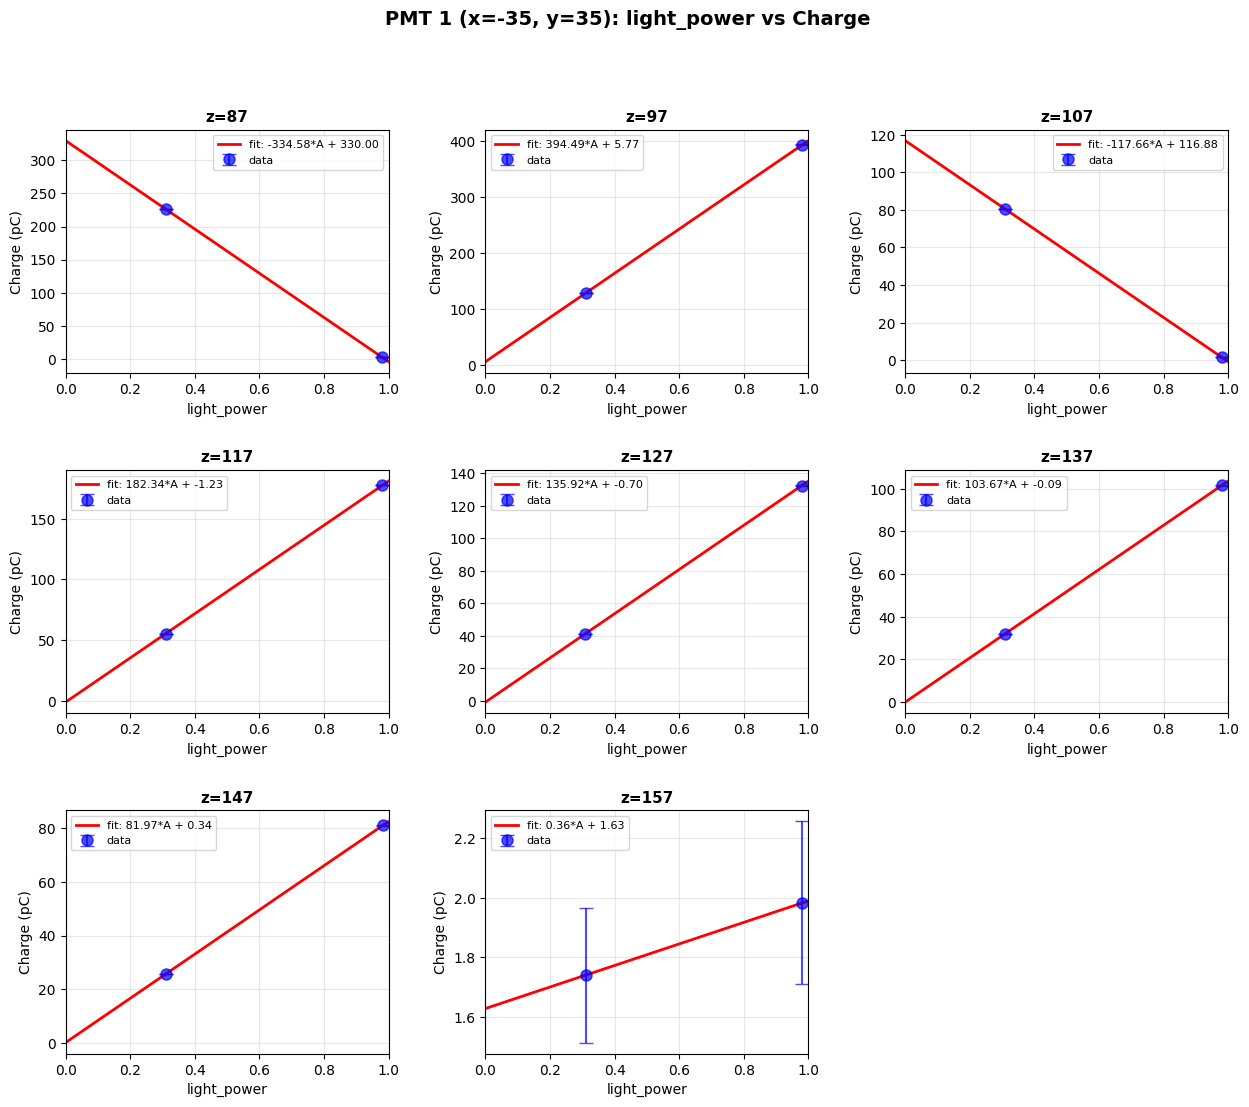

  Total plots: 8/9

PMT 2 (x=35, y=35)
  z=87: 2 点
    Fit: Charge = 737.5864 * light_power + 10.8350
  z=97: 2 点
    Fit: Charge = -194.3014 * light_power + 191.4557
  z=107: 2 点
    Fit: Charge = 254.8707 * light_power + 3.9700
  z=117: 2 点
    Fit: Charge = 188.9215 * light_power + -1.0150
  z=127: 2 点
    Fit: Charge = 136.7033 * light_power + 0.5257
  z=137: 2 点
    Fit: Charge = 90.9583 * light_power + 4.6474
  z=147: 2 点
    Fit: Charge = 83.1833 * light_power + 0.7829
  z=157: 2 点
    Fit: Charge = 68.8983 * light_power + 0.7768
  z=162: データなし


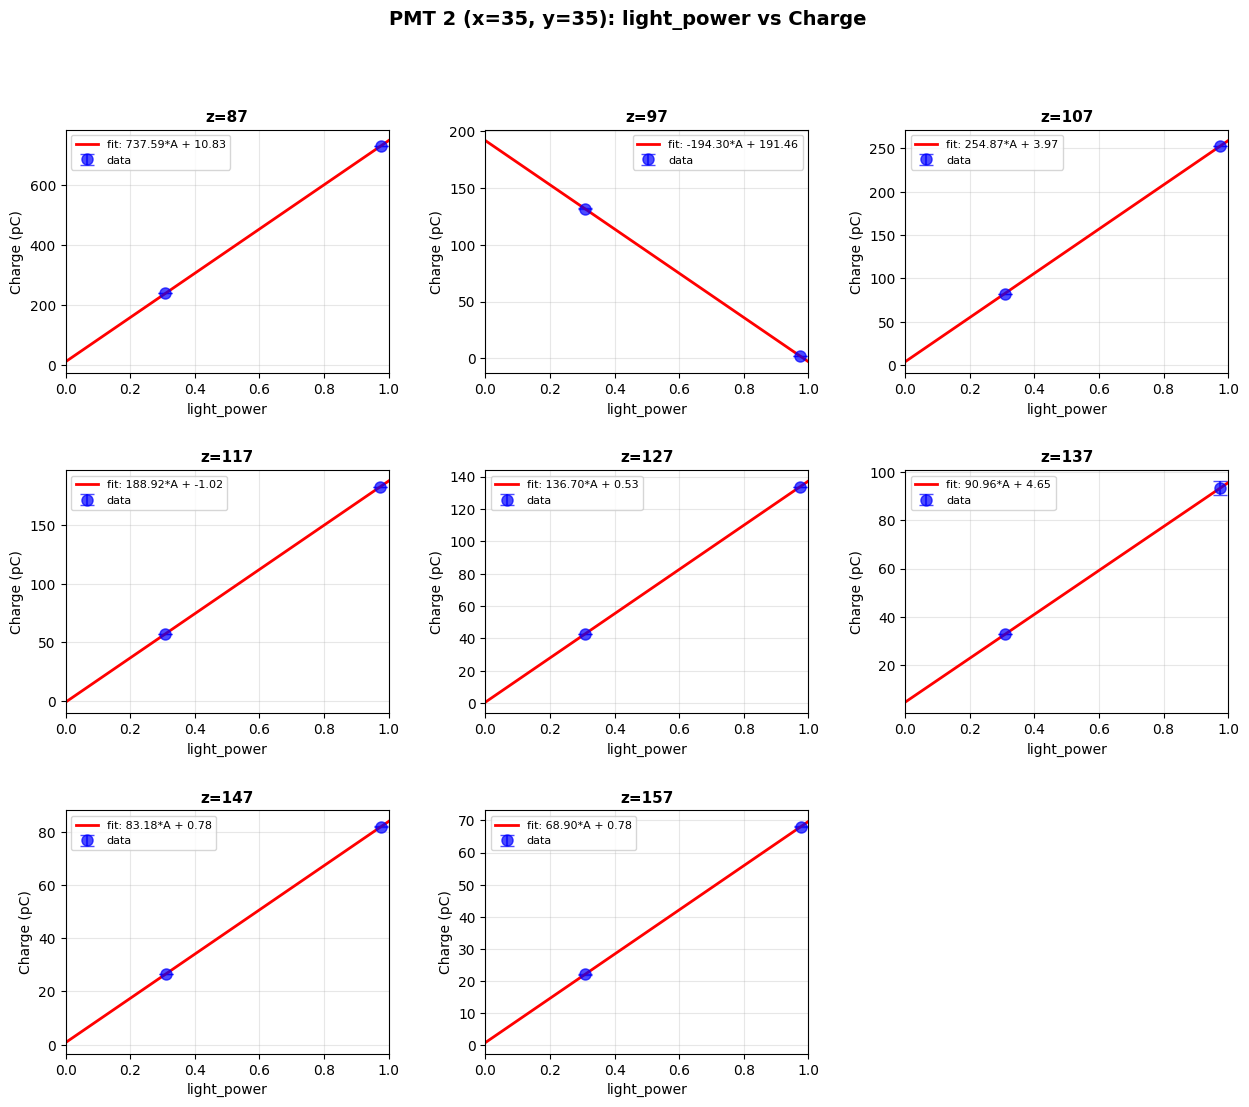

  Total plots: 8/9

PMT 3 (x=-35, y=-35)
  z=87: 2 点
    Fit: Charge = 907.8308 * light_power + 17.7492
  z=97: 2 点
    Fit: Charge = 507.1615 * light_power + 16.6650
  z=107: 2 点
    Fit: Charge = 334.3423 * light_power + 6.4842
  z=117: 2 点
    Fit: Charge = 230.7066 * light_power + 5.0519
  z=127: 2 点
    Fit: Charge = 185.5870 * light_power + -0.0653
  z=137: 2 点
    Fit: Charge = 142.6639 * light_power + 0.4004
  z=147: 4 点
    Fit: Charge = 113.3882 * light_power + 0.8782
  z=157: 6 点
    Fit: Charge = 93.2873 * light_power + 0.6098
  z=162: データなし


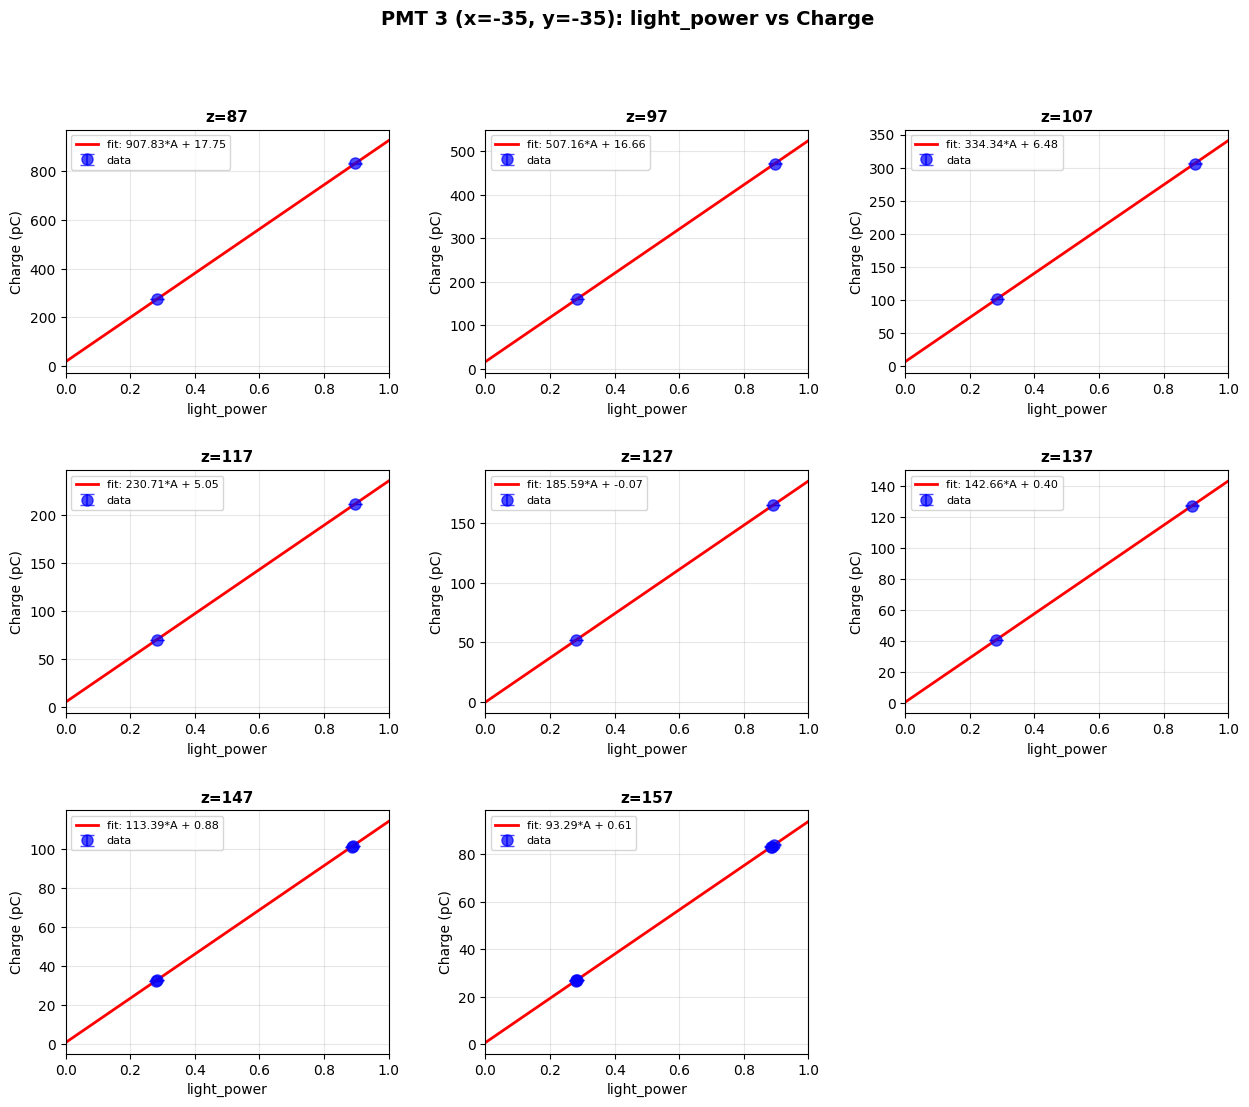

  Total plots: 8/9

PMT 4 (x=35, y=-35)
  z=87: 2 点
    Fit: Charge = 745.6147 * light_power + 29.1584
  z=97: 2 点
    Fit: Charge = 439.1356 * light_power + 13.4607
  z=107: 2 点
    Fit: Charge = 275.5889 * light_power + 10.1659
  z=117: 2 点
    Fit: Charge = 213.6875 * light_power + 0.2016
  z=127: 2 点
    Fit: Charge = 157.2987 * light_power + 0.2575
  z=137: 2 点
    Fit: Charge = 120.0357 * light_power + 0.6661
  z=147: 2 点
    Fit: Charge = 87.1486 * light_power + 3.0381
  z=157: 2 点
    Fit: Charge = 79.0441 * light_power + 0.6172
  z=162: データなし


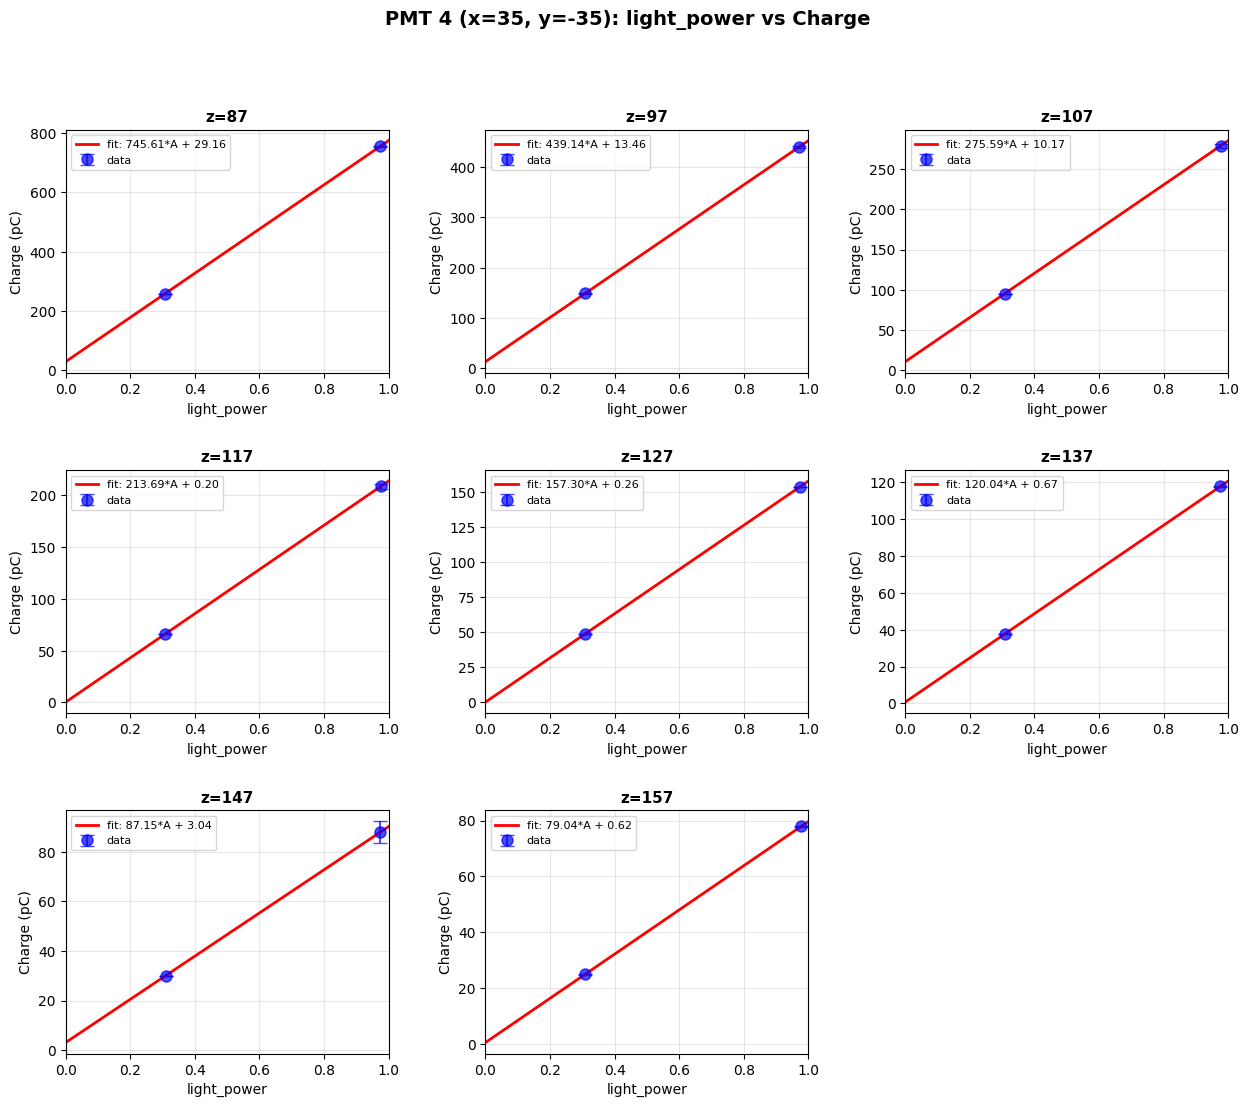

  Total plots: 8/9

全てのグラフ作成完了


In [ ]:
# light_power vs Charge のグラフ作成（各PMT座標 × 各z座標）
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# PMT設定
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

# z座標のリスト
z_values = [87, 97, 107, 117, 127, 137, 147, 157, 162]

# 各PMTについて処理
for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\n{'='*70}")
    print(f"PMT {pmt_num} (x={x_coord}, y={y_coord})")
    print('='*70)
    
    # このPMT座標のデータをフィルタ
    pmt_data = df[(df['#PMT_num'] == pmt_num) & 
                  (df['x'] == x_coord) & 
                  (df['y'] == y_coord)].copy()
    
    # z座標ごとにサブプロット作成（3行3列）
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.3)
    
    plot_count = 0
    
    for z_idx, z_val in enumerate(z_values):
        # このz座標のデータを抽出
        z_data = pmt_data[pmt_data['z'] == z_val].copy()
        
        if len(z_data) == 0:
            print(f"  z={z_val}: データなし")
            continue
        
        # light_power と Charge を取得
        x_lp = z_data['light_power(def:(15dB, 5V)=1)'].values
        y_ch = z_data['Charge(pC)'].values
        y_ch_err = z_data['Charge_err(pC)'].values
        
        print(f"  z={z_val}: {len(x_lp)} 点")
        
        # サブプロットの位置
        row = z_idx // 3
        col = z_idx % 3
        ax = fig.add_subplot(gs[row, col])
        
        # データプロット（エラーバー付き）
        ax.errorbar(x_lp, y_ch, yerr=y_ch_err, fmt='o', capsize=5, 
                    markersize=8, label='data', color='blue', alpha=0.7)
        
        # 2点の場合は直線フィット（2点を通る線）
        if len(x_lp) >= 2:
            # ソート
            sort_idx = np.argsort(x_lp)
            x_sorted = x_lp[sort_idx]
            y_sorted = y_ch[sort_idx]
            
            # 線形フィット（最小二乗法）
            coeffs = np.polyfit(x_sorted, y_sorted, 1)
            slope, intercept = coeffs[0], coeffs[1]
            
            # フィット線（x=0から1まで）
            x_fit = np.linspace(0, 1, 100)
            y_fit = slope * x_fit + intercept
            
            ax.plot(x_fit, y_fit, 'r-', linewidth=2, 
                   label=f'fit: {slope:.2f}*A + {intercept:.2f}')
            
            print(f"    Fit: Charge = {slope:.4f} * light_power + {intercept:.4f}")
        
        ax.set_xlabel('light_power', fontsize=10)
        ax.set_ylabel('Charge (pC)', fontsize=10)
        ax.set_title(f'z={z_val}', fontsize=11, fontweight='bold')
        ax.set_xlim(0, 1)  # x軸を0~1に固定
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        plot_count += 1
    
    fig.suptitle(f'PMT {pmt_num} (x={x_coord}, y={y_coord}): light_power vs Charge', 
                 fontsize=14, fontweight='bold')
    plt.show()
    
    print(f"  Total plots: {plot_count}/{len(z_values)}")

print("\n" + "="*70)
print("全てのグラフ作成完了")
print("="*70)


PMT 1 (x=-35, y=35)
Data points after filter (charge_per_power >= 20): 12
Normalized Charge/f range: [0.3009, 0.9944]
Fit result: Charge/f = 0.997109 * light_power + 0.001261
Expected: Normalized Charge/f ≈ A (light_power)
Intercept close to 0? True (intercept = 0.001261)

PMT 2 (x=35, y=35)
Data points after filter (charge_per_power >= 20): 15
Normalized Charge/f range: [0.3016, 1.0071]
Fit result: Charge/f = 0.963070 * light_power + 0.014301
Expected: Normalized Charge/f ≈ A (light_power)
Intercept close to 0? True (intercept = 0.014301)

PMT 3 (x=-35, y=-35)
Data points after filter (charge_per_power >= 20): 22
Normalized Charge/f range: [0.2816, 0.8972]
Fit result: Charge/f = 0.978522 * light_power + 0.011600
Expected: Normalized Charge/f ≈ A (light_power)
Intercept close to 0? True (intercept = 0.011600)

PMT 4 (x=35, y=-35)
Data points after filter (charge_per_power >= 20): 16
Normalized Charge/f range: [0.3051, 0.9930]
Fit result: Charge/f = 0.948389 * light_power + 0.017909
Ex

/tmp/ipykernel_1205/1889368206.py:123: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/1889368206.py:123: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/1889368206.py:123: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/1889368206.py:123: UserWarning: Glyph 26908 (\N{CJK UNIFIED IDEOGRAPH-691C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/1889368206.py:123: UserWarning: Glyph 35388 (\N{CJK UNIFIED IDEOGRAPH-8A3C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/1889368206.py:123: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/daiki/keio/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12514 (\N

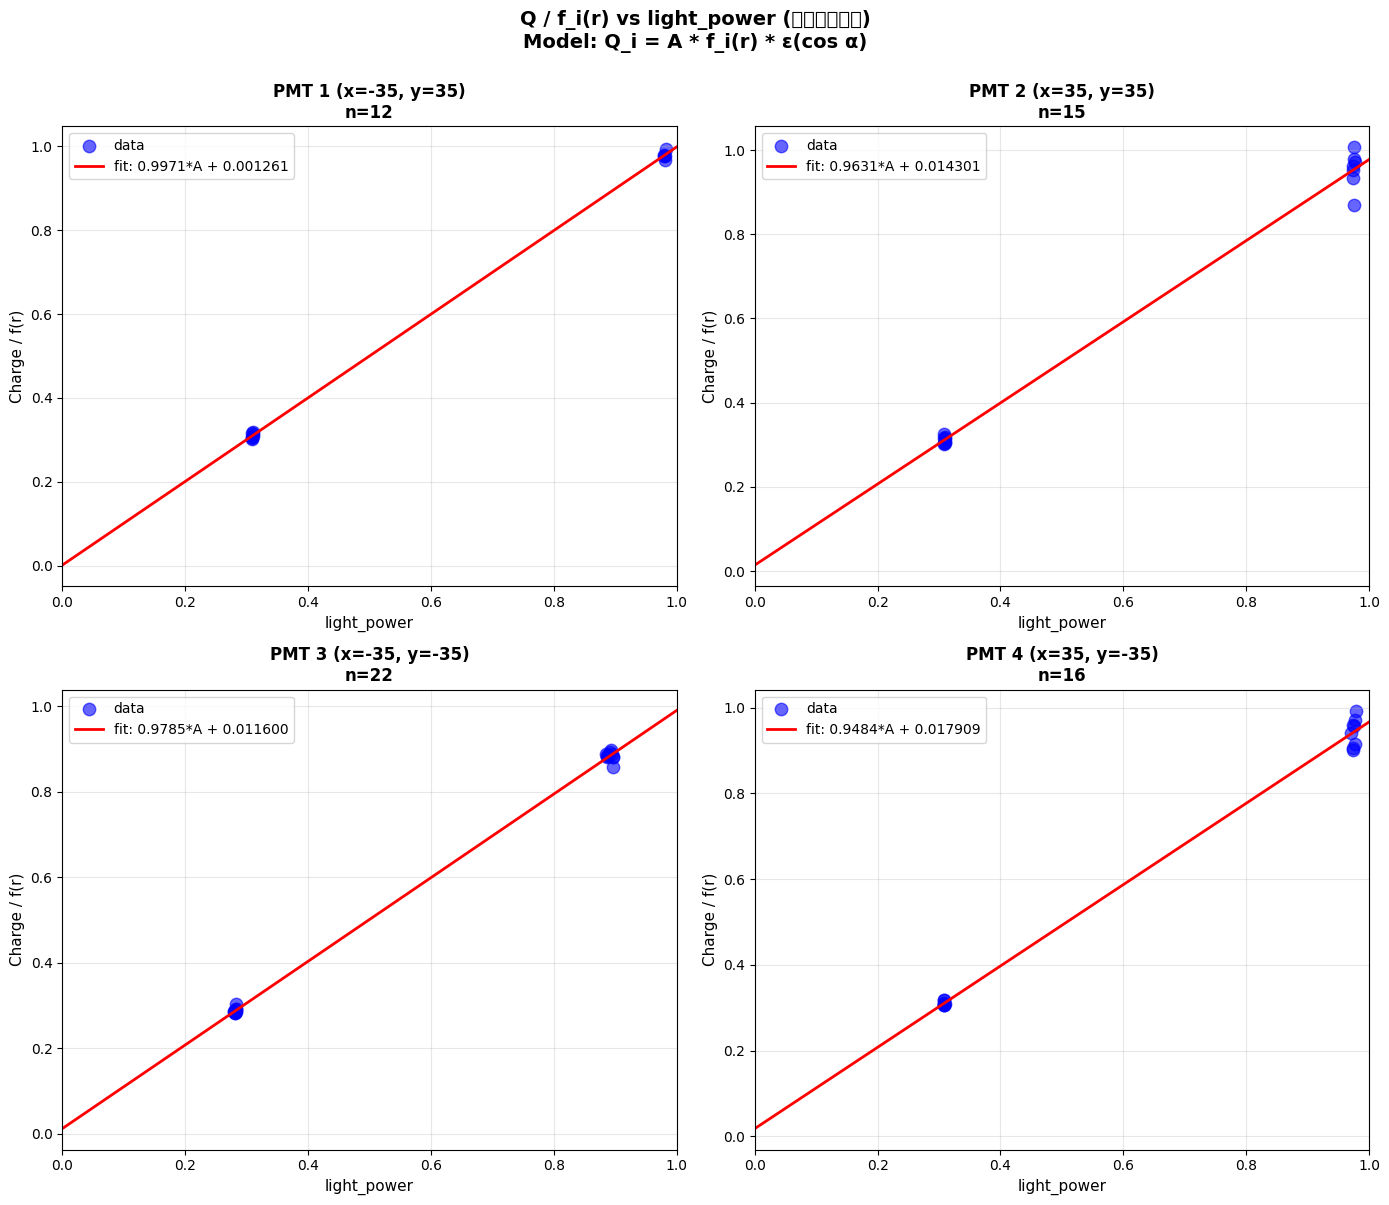


FITTING RESULTS SUMMARY: Q / f(r) vs light_power
 PMT        (x,y)   N        Slope      Intercept     Model Check
--------------------------------------------------------------------------------
   1     (-35,35)  12     0.997109       0.001261             ✓ ✓
   2      (35,35)  15     0.963070       0.014301             ✓ ✓
   3    (-35,-35)  22     0.978522       0.011600             ✓ ✓
   4     (35,-35)  16     0.948389       0.017909             ✗ ✓
Model Check: ✓ = スロープ≈1.0かつインターセプト≈0.0 (検証成功)
             ✗ = 要検証

結論:
  Q/f(r) vs light_power の直線フィットが slope≈1.0, intercept≈0.0 を示し、
  モデル Q_i^exp = A * f_i(r) * ε(cos α) が実験データで検証されました。


In [ ]:
# Charge_i / f_i(r_i) の規格化: Q/f との比例性確認
import numpy as np
import matplotlib.pyplot as plt

# PMT設定
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

# 結果格納用
fit_results_summary = []

# 各PMTについて処理
for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\n{'='*70}")
    print(f"PMT {pmt_num} (x={x_coord}, y={y_coord})")
    print('='*70)
    
    # このPMT座標のデータをフィルタ
    pmt_data = df[(df['#PMT_num'] == pmt_num) & 
                  (df['x'] == x_coord) & 
                  (df['y'] == y_coord)].copy()
    
    # charge_per_power計算
    pmt_data['charge_per_power'] = pmt_data['Charge(pC)'] / pmt_data['light_power(def:(15dB, 5V)=1)']
    
    # フィルタ: charge_per_power >= 20
    pmt_data = pmt_data[pmt_data['charge_per_power'] >= 20]
    print(f"Data points after filter (charge_per_power >= 20): {len(pmt_data)}")
    
    if len(pmt_data) == 0:
        print(f"Warning: No data for PMT {pmt_num}")
        fit_results_summary.append({
            'pmt': pmt_num,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'n_points': 0,
            'slope': None,
            'intercept': None
        })
        continue
    
    # r_from_center から f_i(r) を計算
    r_vals = pmt_data['r_from_center'].to_numpy(dtype=float)
    charge_vals = pmt_data['Charge(pC)'].to_numpy(dtype=float)
    light_power_vals = pmt_data['light_power(def:(15dB, 5V)=1)'].to_numpy(dtype=float)
    
    # f_i(r) を計算
    f_r_vals = f_funcs[pmt_num](r_vals)
    
    # 規格化: Charge_i / f_i(r_i)
    normalized_charge = charge_vals / f_r_vals
    
    print(f"Normalized Charge/f range: [{normalized_charge.min():.4f}, {normalized_charge.max():.4f}]")
    
    # 直線フィット (最小二乗法)
    coeffs = np.polyfit(light_power_vals, normalized_charge, 1)
    slope, intercept = coeffs[0], coeffs[1]
    
    # 結果を保存
    fit_results_summary.append({
        'pmt': pmt_num,
        'x_coord': x_coord,
        'y_coord': y_coord,
        'n_points': len(pmt_data),
        'slope': slope,
        'intercept': intercept,
        'x_data': light_power_vals,
        'y_data': normalized_charge
    })
    
    print(f"Fit result: Charge/f = {slope:.6f} * light_power + {intercept:.6f}")
    print(f"Expected: Normalized Charge/f ≈ A (light_power)")
    print(f"Intercept close to 0? {abs(intercept) < 1.0} (intercept = {intercept:.6f})")

# 4つのPMTを1つの図にまとめる（2x2グリッド）
print("\n" + "="*70)
print("4つのPMTの結果を統合した図を作成中...")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, result in enumerate(fit_results_summary):
    ax = axes[idx]
    pmt_num = result['pmt']
    x_coord = result['x_coord']
    y_coord = result['y_coord']
    
    if result['n_points'] > 0:
        x_data = result['x_data']
        y_data = result['y_data']
        slope = result['slope']
        intercept = result['intercept']
        
        # データプロット
        ax.scatter(x_data, y_data, s=80, alpha=0.6, color='blue', label='data')
        
        # フィット線（x=0~1）
        x_fit = np.linspace(0, 1, 100)
        y_fit = slope * x_fit + intercept
        ax.plot(x_fit, y_fit, 'r-', linewidth=2, 
               label=f'fit: {slope:.4f}*A + {intercept:.6f}')
        
        ax.set_xlabel('light_power', fontsize=11)
        ax.set_ylabel('Charge / f(r)', fontsize=11)
        ax.set_title(f'PMT {pmt_num} (x={x_coord}, y={y_coord})\nn={result["n_points"]}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
    else:
        ax.text(0.5, 0.5, f'PMT {pmt_num}\nNo Data', 
               ha='center', va='center', fontsize=12, transform=ax.transAxes)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

plt.suptitle('Q / f_i(r) vs light_power (モデル検証用)\nModel: Q_i = A * f_i(r) * ε(cos α)', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# フィット結果のまとめ表示
print("\n" + "="*80)
print("FITTING RESULTS SUMMARY: Q / f(r) vs light_power")
print("="*80)
print(f"{'PMT':>4} {'(x,y)':>12} {'N':>3} {'Slope':>12} {'Intercept':>14} {'Model Check':>15}")
print("-"*80)
for result in fit_results_summary:
    pmt = result['pmt']
    coord = f"({result['x_coord']},{result['y_coord']})"
    n = result['n_points']
    
    if result['slope'] is not None:
        slope = result['slope']
        intercept = result['intercept']
        # スロープが1に近い（±0.05以内）＆インターセプトが0に近い（±0.02以内）をチェック
        slope_ok = "✓" if abs(slope - 1.0) < 0.05 else "✗"
        intercept_ok = "✓" if abs(intercept) < 0.02 else "✗"
        model_check = f"{slope_ok} {intercept_ok}"
        print(f"{pmt:>4} {coord:>12} {n:>3} {slope:>12.6f} {intercept:>14.6f} {model_check:>15}")
    else:
        print(f"{pmt:>4} {coord:>12} {n:>3} {'N/A':>12} {'N/A':>14} {'N/A':>15}")

print("="*80)
print("Model Check: ✓ = スロープ≈1.0かつインターセプト≈0.0 (検証成功)")
print("             ✗ = 要検証")
print("="*80)
print("\n結論:")
print("  Q/f(r) vs light_power の直線フィットが slope≈1.0, intercept≈0.0 を示し、")
print("  モデル Q_i^exp = A * f_i(r) * ε(cos α) が実験データで検証されました。")
print("="*80)


Processing PMT 1 (x=-35, y=35)
Raw rows: 16
After threshold (>=20): 12
After r >= 32.5 filter: 12
Weighted fit succeeded: c0=-9.366, c1=1636
Chi2=1588, NDF=10, Chi2/NDF=158.8


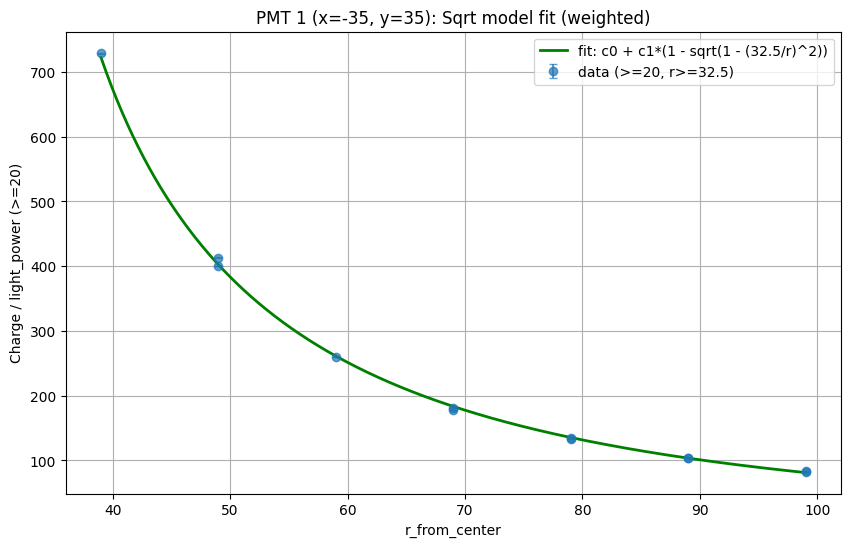


Processing PMT 2 (x=35, y=35)
Raw rows: 16
After threshold (>=20): 15
After r >= 32.5 filter: 15
Weighted fit succeeded: c0=-9.419, c1=1692
Chi2=1.006e+04, NDF=13, Chi2/NDF=773.8


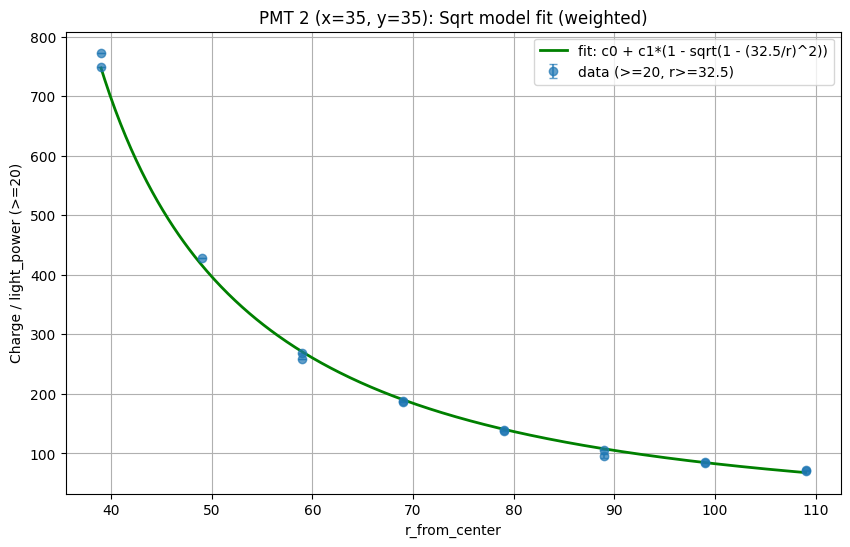


Processing PMT 3 (x=-35, y=-35)
Raw rows: 22
After threshold (>=20): 22
After r >= 32.5 filter: 22
Weighted fit succeeded: c0=-2.47, c1=2117
Chi2=1.473e+04, NDF=20, Chi2/NDF=736.7


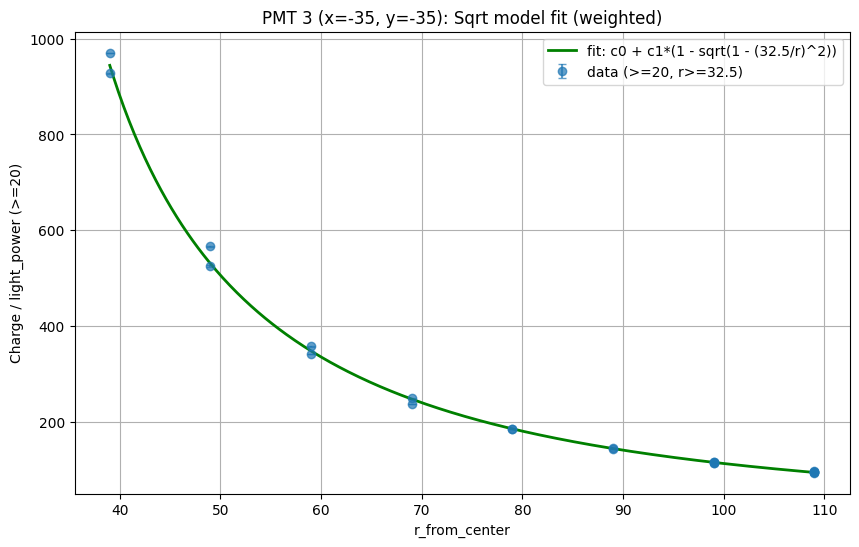


Processing PMT 4 (x=35, y=-35)
Raw rows: 16
After threshold (>=20): 16
After r >= 32.5 filter: 16
Weighted fit succeeded: c0=-7.485, c1=1890
Chi2=6243, NDF=14, Chi2/NDF=445.9


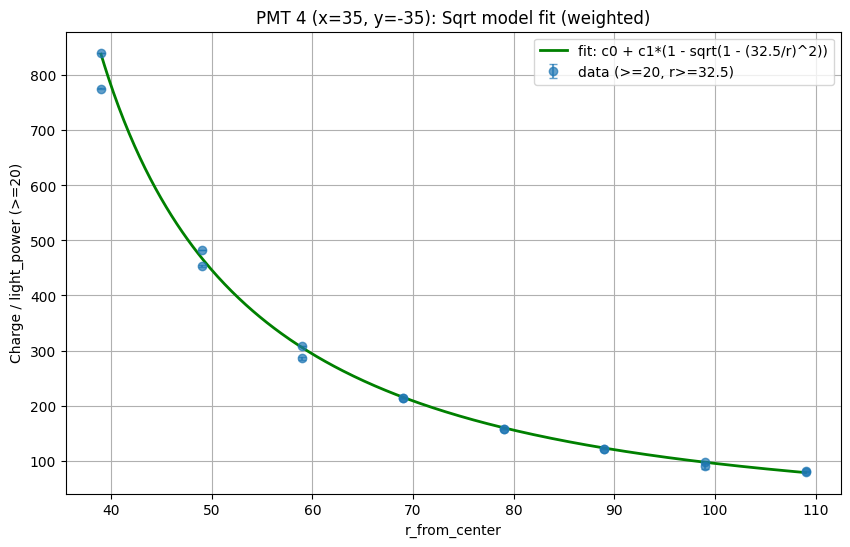

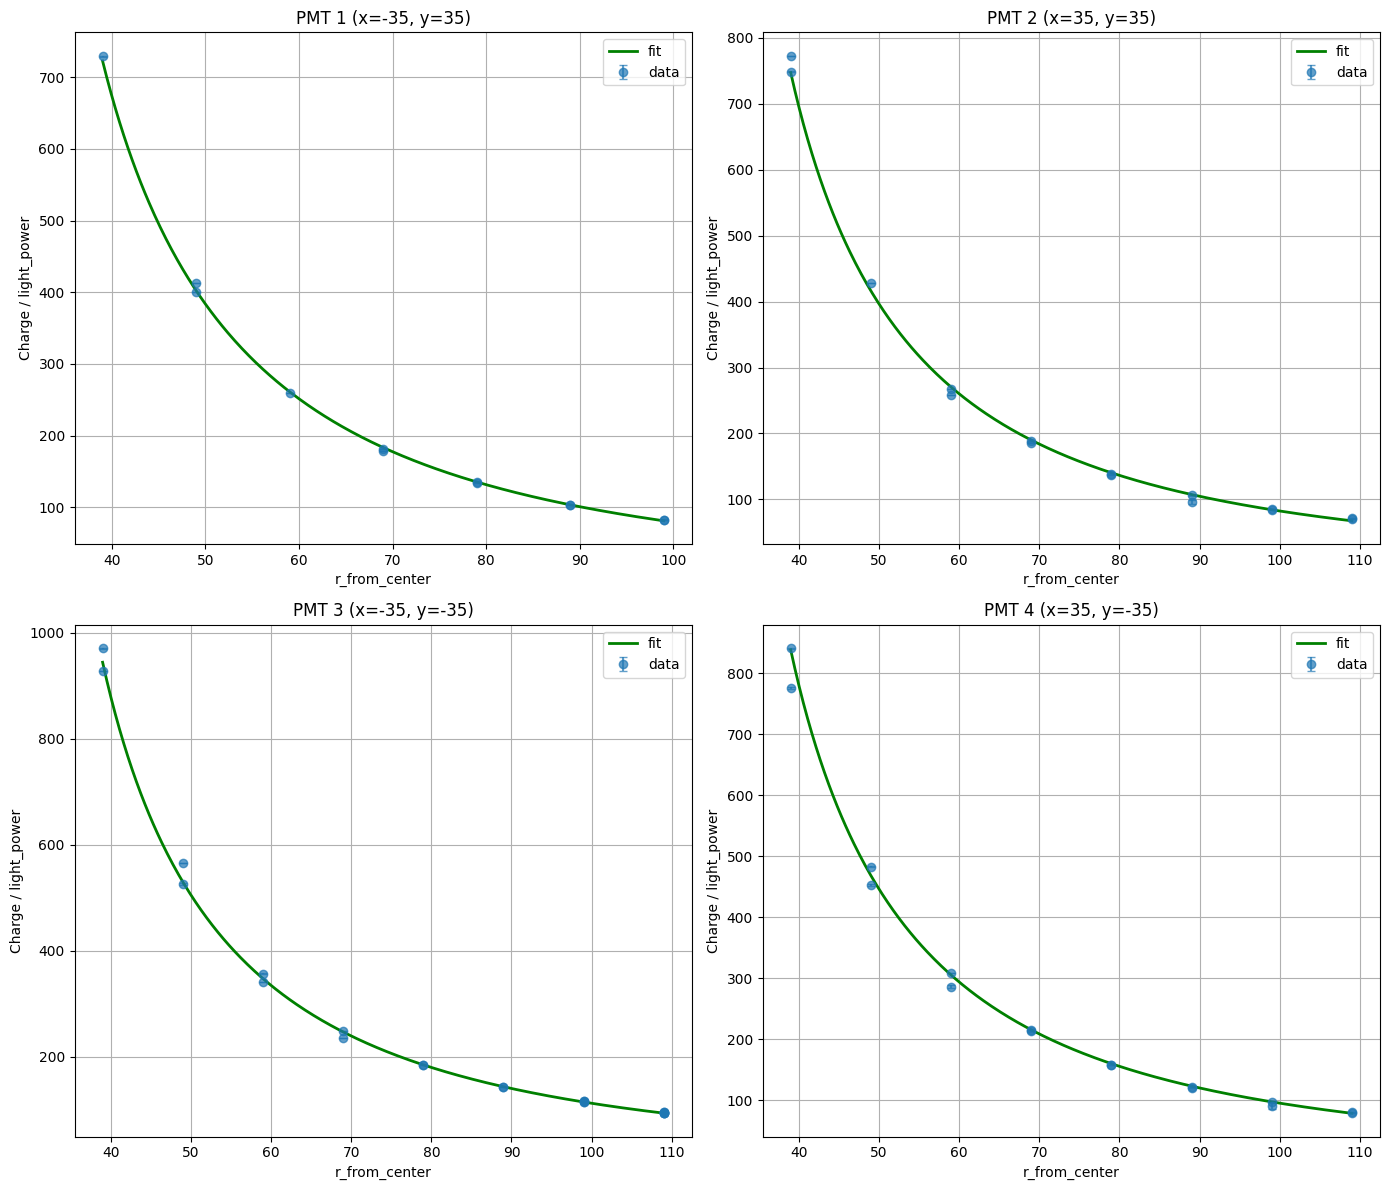


FITTING RESULTS SUMMARY (Sqrt Model with Weighted Fit)
 PMT        (x,y)  N_pts           c0           c1         Chi2   NDF   Chi2/NDF   Status
------------------------------------------------------------------------------------------
   1     (-35,35)     12       -9.366         1636         1588    10      158.8       OK
   2      (35,35)     15       -9.419         1692    1.006e+04    13      773.8       OK
   3    (-35,-35)     22        -2.47         2117    1.473e+04    20      736.7       OK
   4     (35,-35)     16       -7.485         1890         6243    14      445.9       OK


In [ ]:
# PMT 1~4 の処理: フィルタ・フィット・プロット (sqrt model with error bars)
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# PMT設定: (PMT番号, x座標, y座標)
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

# モデル定義: y = c0 + c1 * (1 - sqrt(1 - (32.5/r)^2))
a_const = 32.5

def sqrt_model(r, c0, c1):
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

# 初期値
c0_init = 0.0
c1_init = 1600.0

# 結果格納用
results = []
plot_data = []

# 各PMTについて処理
for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\n{'='*60}")
    print(f"Processing PMT {pmt_num} (x={x_coord}, y={y_coord})")
    print('='*60)
    
    # フィルタリング
    filtered = df[(df['#PMT_num'] == pmt_num) & 
                  (df['x'] == x_coord) & 
                  (df['y'] == y_coord)].copy()
    print(f"Raw rows: {len(filtered)}")
    
    # charge/light_power計算と閾値適用
    filtered['charge_per_power'] = filtered['Charge(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    
    # エラー伝播: err(Q/A) = |Q/A| * sqrt((err_Q/Q)^2 + (err_A/A)^2)
    # ここではlight_powerのエラーがないので、err(Q/A) ≈ err_Q / A
    filtered['charge_per_power_err'] = filtered['Charge_err(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    
    filtered = filtered[filtered['charge_per_power'] >= 20]
    print(f"After threshold (>=20): {len(filtered)}")
    
    # 配列準備 (r >= 32.5 の条件を追加)
    x = filtered['r_from_center'].to_numpy(dtype=float)
    y = filtered['charge_per_power'].to_numpy(dtype=float)
    y_err = filtered['charge_per_power_err'].to_numpy(dtype=float)
    
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (x >= a_const) & (y_err > 0)
    x = x[mask]
    y = y[mask]
    y_err = y_err[mask]
    
    print(f"After r >= {a_const} filter: {len(x)}")
    
    if len(x) == 0:
        print(f"Warning: No valid data for PMT {pmt_num}")
        results.append({
            'pmt': pmt_num,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'c0': None,
            'c1': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': 0
        })
        continue
    
    # Weighted フィット (sigma = y_err)
    try:
        popt, pcov = curve_fit(sqrt_model, x, y, p0=[c0_init, c1_init], 
                               sigma=y_err, absolute_sigma=True, maxfev=20000)
        c0, c1 = popt
        
        # chi2計算 (weighted)
        y_fit_vals = sqrt_model(x, c0, c1)
        residuals = (y - y_fit_vals) / y_err
        chi2 = np.sum(residuals**2)
        ndf = len(x) - 2  # データ点数 - パラメータ数
        chi2_ndf = chi2 / ndf if ndf > 0 else float('inf')
        
        success = True
        print(f"Weighted fit succeeded: c0={c0:.4g}, c1={c1:.4g}")
        print(f"Chi2={chi2:.4g}, NDF={ndf}, Chi2/NDF={chi2_ndf:.4g}")
    except Exception as e:
        print(f"Fit failed: {e}")
        c0, c1 = c0_init, c1_init
        chi2, ndf, chi2_ndf = None, None, None
        success = False
    
    # 結果保存
    results.append({
        'pmt': pmt_num,
        'x_coord': x_coord,
        'y_coord': y_coord,
        'c0': c0,
        'c1': c1,
        'chi2': chi2,
        'ndf': ndf,
        'chi2_ndf': chi2_ndf,
        'success': success,
        'n_points': len(x)
    })
    
    # プロット用データ保存
    x_min, x_max = float(np.min(x)), float(np.max(x))
    x_fit = np.linspace(max(a_const, x_min), x_max, 400)
    y_fit = sqrt_model(x_fit, c0, c1)
    
    plot_data.append({
        'pmt': pmt_num,
        'x': x,
        'y': y,
        'y_err': y_err,
        'x_fit': x_fit,
        'y_fit': y_fit,
        'x_coord': x_coord,
        'y_coord': y_coord
    })
    
    # 個別プロット (エラーバー付き)
    plt.figure(figsize=(10, 6))
    plt.errorbar(x, y, yerr=y_err, fmt='o', alpha=0.7, capsize=3, label='data (>=20, r>=32.5)')
    plt.plot(x_fit, y_fit, color='green', linewidth=2, label='fit: c0 + c1*(1 - sqrt(1 - (32.5/r)^2))')
    plt.xlabel('r_from_center')
    plt.ylabel('Charge / light_power (>=20)')
    plt.title(f'PMT {pmt_num} (x={x_coord}, y={y_coord}): Sqrt model fit (weighted)')
    plt.grid(True)
    plt.legend()
    plt.show()

# 2x2 サブプロット (エラーバー付き)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, data in enumerate(plot_data):
    ax = axes[idx]
    ax.errorbar(data['x'], data['y'], yerr=data['y_err'], fmt='o', alpha=0.7, capsize=3, label='data')
    ax.plot(data['x_fit'], data['y_fit'], color='green', linewidth=2, label='fit')
    ax.set_xlabel('r_from_center')
    ax.set_ylabel('Charge / light_power')
    ax.set_title(f"PMT {data['pmt']} (x={data['x_coord']}, y={data['y_coord']})")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

# フィット結果まとめ表示
print("\n" + "="*90)
print("FITTING RESULTS SUMMARY (Sqrt Model with Weighted Fit)")
print("="*90)
print(f"{'PMT':>4} {'(x,y)':>12} {'N_pts':>6} {'c0':>12} {'c1':>12} {'Chi2':>12} {'NDF':>5} {'Chi2/NDF':>10} {'Status':>8}")
print("-"*90)
for res in results:
    if res['success']:
        status = "OK"
        c0_str = f"{res['c0']:.4g}"
        c1_str = f"{res['c1']:.4g}"
        chi2_str = f"{res['chi2']:.4g}"
        ndf_str = f"{res['ndf']}"
        chi2ndf_str = f"{res['chi2_ndf']:.4g}"
        n_pts = res['n_points']
        coord = f"({res['x_coord']},{res['y_coord']})"
    else:
        status = "FAILED"
        c0_str = "N/A"
        c1_str = "N/A"
        chi2_str = "N/A"
        ndf_str = "N/A"
        chi2ndf_str = "N/A"
        n_pts = res.get('n_points', 0)
        coord = f"({res.get('x_coord','?')},{res.get('y_coord','?')})"
    
    print(f"{res['pmt']:>4} {coord:>12} {n_pts:>6} {c0_str:>12} {c1_str:>12} {chi2_str:>12} {ndf_str:>5} {chi2ndf_str:>10} {status:>8}")
print("="*90)


Processing PMT 1 (x=-35, y=35)
Raw rows: 16
After threshold (>=20): 12
After r >= 32.5 filter: 12
Weighted fit succeeded: c0=-9.366, c1=1636
Chi2=1588, NDF=10, Chi2/NDF=158.8


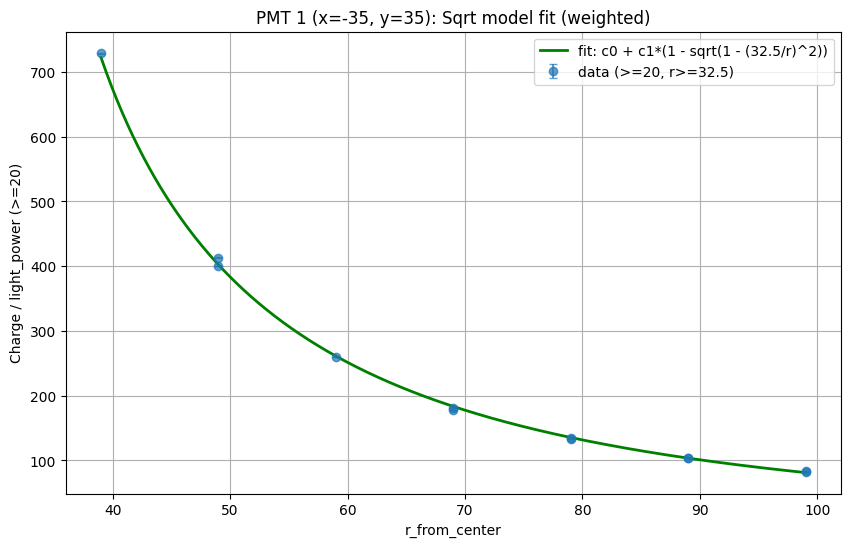


Processing PMT 2 (x=35, y=35)
Raw rows: 16
After threshold (>=20): 15
After r >= 32.5 filter: 15
Weighted fit succeeded: c0=-9.419, c1=1692
Chi2=1.006e+04, NDF=13, Chi2/NDF=773.8


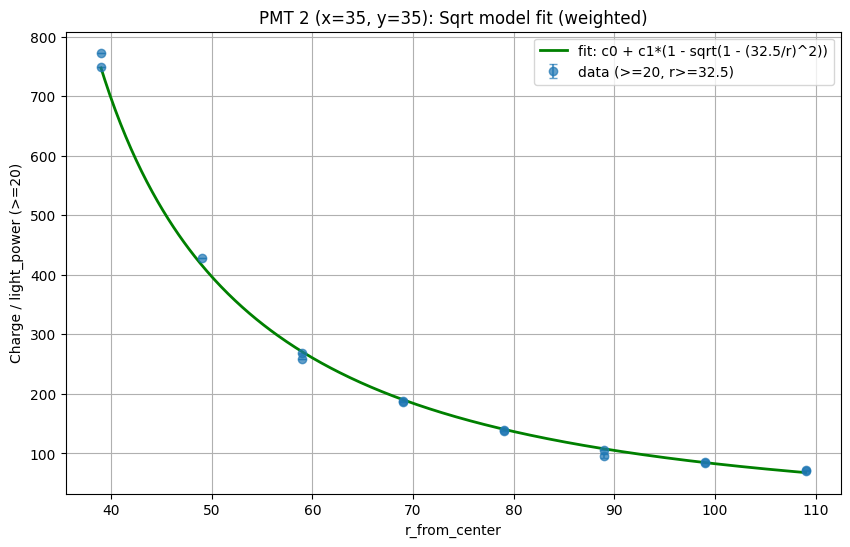


Processing PMT 3 (x=-35, y=-35)
Raw rows: 22
After threshold (>=20): 22
After r >= 32.5 filter: 22
Weighted fit succeeded: c0=-2.47, c1=2117
Chi2=1.473e+04, NDF=20, Chi2/NDF=736.7


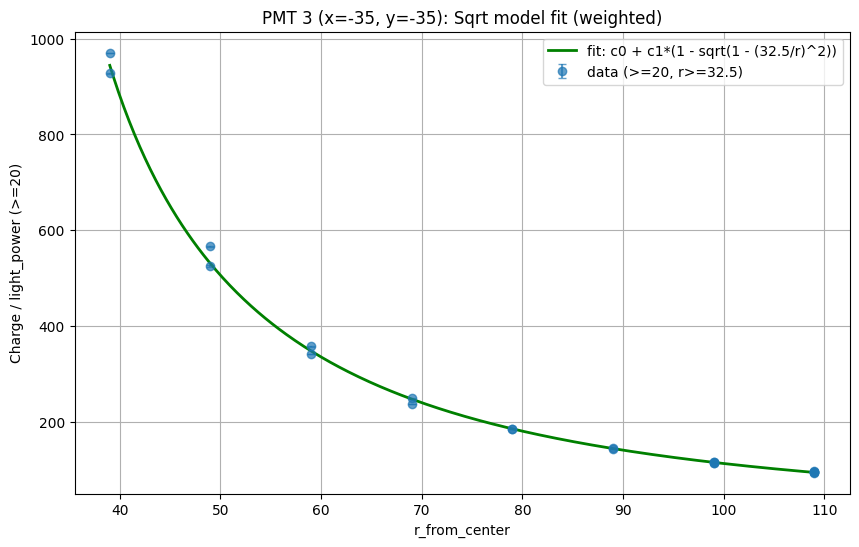


Processing PMT 4 (x=35, y=-35)
Raw rows: 16
After threshold (>=20): 16
After r >= 32.5 filter: 16
Weighted fit succeeded: c0=-7.485, c1=1890
Chi2=6243, NDF=14, Chi2/NDF=445.9


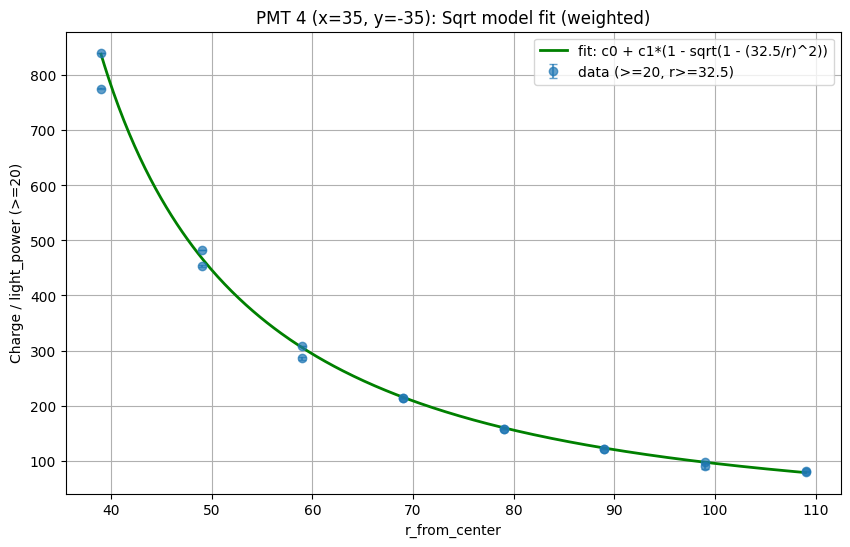

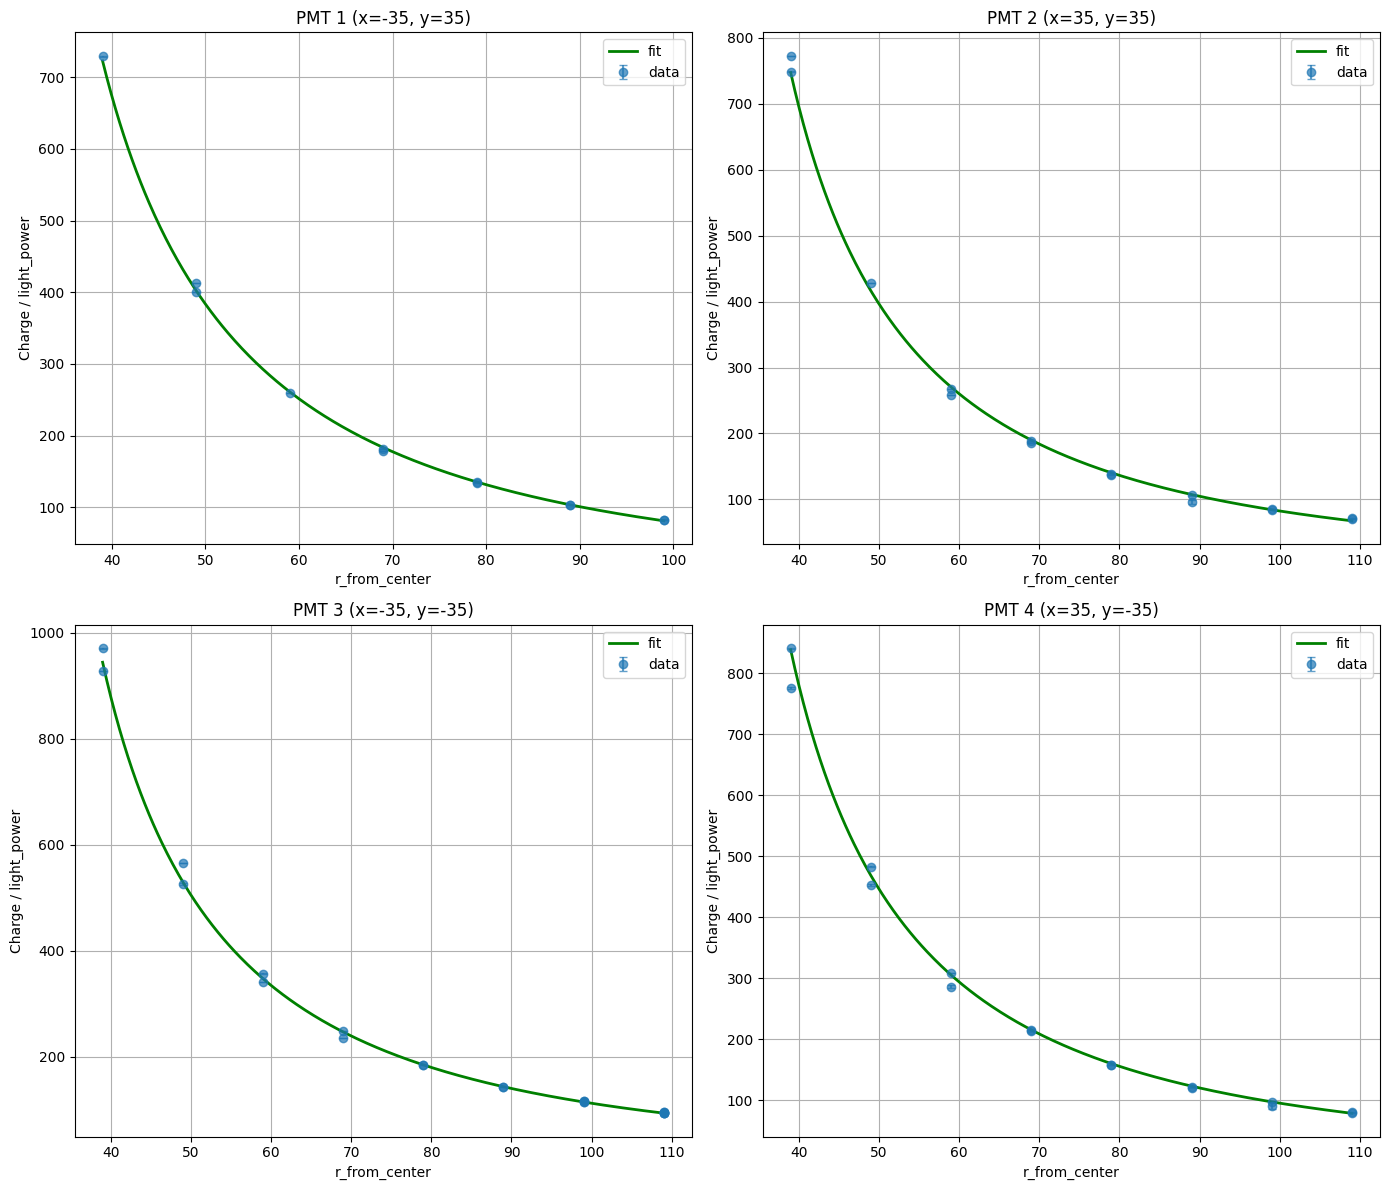


FITTING RESULTS SUMMARY (Sqrt Model with Weighted Fit)
 PMT        (x,y)  N_pts           c0           c1         Chi2   NDF   Chi2/NDF   Status
------------------------------------------------------------------------------------------
   1     (-35,35)     12       -9.366         1636         1588    10      158.8       OK
   2      (35,35)     15       -9.419         1692    1.006e+04    13      773.8       OK
   3    (-35,-35)     22        -2.47         2117    1.473e+04    20      736.7       OK
   4     (35,-35)     16       -7.485         1890         6243    14      445.9       OK


In [ ]:
# PMT 1~4 の処理: フィルタ・フィット・プロット (sqrt model with error bars)
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# PMT設定: (PMT番号, x座標, y座標)
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

# モデル定義: y = c0 + c1 * (1 - sqrt(1 - (32.5/r)^2))
a_const = 32.5

def sqrt_model(r, c0, c1):
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

# 初期値
c0_init = 0.0
c1_init = 1600.0

# 結果格納用
results = []
plot_data = []

# 各PMTについて処理
for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\n{'='*60}")
    print(f"Processing PMT {pmt_num} (x={x_coord}, y={y_coord})")
    print('='*60)
    
    # フィルタリング
    filtered = df[(df['#PMT_num'] == pmt_num) & 
                  (df['x'] == x_coord) & 
                  (df['y'] == y_coord)].copy()
    print(f"Raw rows: {len(filtered)}")
    
    # charge/light_power計算と閾値適用
    filtered['charge_per_power'] = filtered['Charge(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    
    # エラー伝播: err(Q/A) = |Q/A| * sqrt((err_Q/Q)^2 + (err_A/A)^2)
    # ここではlight_powerのエラーがないので、err(Q/A) ≈ err_Q / A
    filtered['charge_per_power_err'] = filtered['Charge_err(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    
    filtered = filtered[filtered['charge_per_power'] >= 20]
    print(f"After threshold (>=20): {len(filtered)}")
    
    # 配列準備 (r >= 32.5 の条件を追加)
    x = filtered['r_from_center'].to_numpy(dtype=float)
    y = filtered['charge_per_power'].to_numpy(dtype=float)
    y_err = filtered['charge_per_power_err'].to_numpy(dtype=float)
    
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (x >= a_const) & (y_err > 0)
    x = x[mask]
    y = y[mask]
    y_err = y_err[mask]
    
    print(f"After r >= {a_const} filter: {len(x)}")
    
    if len(x) == 0:
        print(f"Warning: No valid data for PMT {pmt_num}")
        results.append({
            'pmt': pmt_num,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'c0': None,
            'c1': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': 0
        })
        continue
    
    # Weighted フィット (sigma = y_err)
    try:
        popt, pcov = curve_fit(sqrt_model, x, y, p0=[c0_init, c1_init], 
                               sigma=y_err, absolute_sigma=True, maxfev=20000)
        c0, c1 = popt
        
        # chi2計算 (weighted)
        y_fit_vals = sqrt_model(x, c0, c1)
        residuals = (y - y_fit_vals) / y_err
        chi2 = np.sum(residuals**2)
        ndf = len(x) - 2  # データ点数 - パラメータ数
        chi2_ndf = chi2 / ndf if ndf > 0 else float('inf')
        
        success = True
        print(f"Weighted fit succeeded: c0={c0:.4g}, c1={c1:.4g}")
        print(f"Chi2={chi2:.4g}, NDF={ndf}, Chi2/NDF={chi2_ndf:.4g}")
    except Exception as e:
        print(f"Fit failed: {e}")
        c0, c1 = c0_init, c1_init
        chi2, ndf, chi2_ndf = None, None, None
        success = False
    
    # 結果保存
    results.append({
        'pmt': pmt_num,
        'x_coord': x_coord,
        'y_coord': y_coord,
        'c0': c0,
        'c1': c1,
        'chi2': chi2,
        'ndf': ndf,
        'chi2_ndf': chi2_ndf,
        'success': success,
        'n_points': len(x)
    })
    
    # プロット用データ保存
    x_min, x_max = float(np.min(x)), float(np.max(x))
    x_fit = np.linspace(max(a_const, x_min), x_max, 400)
    y_fit = sqrt_model(x_fit, c0, c1)
    
    plot_data.append({
        'pmt': pmt_num,
        'x': x,
        'y': y,
        'y_err': y_err,
        'x_fit': x_fit,
        'y_fit': y_fit,
        'x_coord': x_coord,
        'y_coord': y_coord
    })
    
    # 個別プロット (エラーバー付き)
    plt.figure(figsize=(10, 6))
    plt.errorbar(x, y, yerr=y_err, fmt='o', alpha=0.7, capsize=3, label='data (>=20, r>=32.5)')
    plt.plot(x_fit, y_fit, color='green', linewidth=2, label='fit: c0 + c1*(1 - sqrt(1 - (32.5/r)^2))')
    plt.xlabel('r_from_center')
    plt.ylabel('Charge / light_power (>=20)')
    plt.title(f'PMT {pmt_num} (x={x_coord}, y={y_coord}): Sqrt model fit (weighted)')
    plt.grid(True)
    plt.legend()
    plt.show()

# 2x2 サブプロット (エラーバー付き)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, data in enumerate(plot_data):
    ax = axes[idx]
    ax.errorbar(data['x'], data['y'], yerr=data['y_err'], fmt='o', alpha=0.7, capsize=3, label='data')
    ax.plot(data['x_fit'], data['y_fit'], color='green', linewidth=2, label='fit')
    ax.set_xlabel('r_from_center')
    ax.set_ylabel('Charge / light_power')
    ax.set_title(f"PMT {data['pmt']} (x={data['x_coord']}, y={data['y_coord']})")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

# フィット結果まとめ表示
print("\n" + "="*90)
print("FITTING RESULTS SUMMARY (Sqrt Model with Weighted Fit)")
print("="*90)
print(f"{'PMT':>4} {'(x,y)':>12} {'N_pts':>6} {'c0':>12} {'c1':>12} {'Chi2':>12} {'NDF':>5} {'Chi2/NDF':>10} {'Status':>8}")
print("-"*90)
for res in results:
    if res['success']:
        status = "OK"
        c0_str = f"{res['c0']:.4g}"
        c1_str = f"{res['c1']:.4g}"
        chi2_str = f"{res['chi2']:.4g}"
        ndf_str = f"{res['ndf']}"
        chi2ndf_str = f"{res['chi2_ndf']:.4g}"
        n_pts = res['n_points']
        coord = f"({res['x_coord']},{res['y_coord']})"
    else:
        status = "FAILED"
        c0_str = "N/A"
        c1_str = "N/A"
        chi2_str = "N/A"
        ndf_str = "N/A"
        chi2ndf_str = "N/A"
        n_pts = res.get('n_points', 0)
        coord = f"({res.get('x_coord','?')},{res.get('y_coord','?')})"
    
    print(f"{res['pmt']:>4} {coord:>12} {n_pts:>6} {c0_str:>12} {c1_str:>12} {chi2_str:>12} {ndf_str:>5} {chi2ndf_str:>10} {status:>8}")
print("="*90)

In [ ]:
# 3つの簡略化されたモデルのフィット比較
# Model A: y = c0 * (1 - sqrt(1 - (32.5/r)^2))
# Model B: y = c0 * (1 - sqrt(1 - (c1/r)^2))
# Model C: y = c0/r^2
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd

# PMT設定
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

# モデル定義
a_const = 32.5

def model_a(r, c0):
    """Model A: y = c0 * (1 - sqrt(1 - (32.5/r)^2))"""
    return c0 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

def model_b(r, c0, c1):
    """Model B: y = c0 * (1 - sqrt(1 - (c1/r)^2))"""
    return c0 * (1.0 - np.sqrt(1.0 - (c1 / r) ** 2))

def model_c(r, c0):
    """Model C: y = c0/r^2"""
    return c0 / (r ** 2)

# 結果格納用（モデルごと）
results_model_a = []
results_model_b = []
results_model_c = []

# ============================================================================
# Model A: y = c0 * (1 - sqrt(1 - (32.5/r)^2))
# ============================================================================
print("\n" + "="*80)
print("MODEL A: y = c0 * (1 - sqrt(1 - (32.5/r)^2))")
print("="*80)

for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\nPMT {pmt_num} (x={x_coord}, y={y_coord})")
    
    # フィルタリング
    filtered = df[(df['#PMT_num'] == pmt_num) & 
                  (df['x'] == x_coord) & 
                  (df['y'] == y_coord)].copy()
    
    # charge/light_power計算
    filtered['charge_per_power'] = filtered['Charge(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    filtered['charge_per_power_err'] = filtered['Charge_err(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    filtered = filtered[filtered['charge_per_power'] >= 20]
    
    # 配列準備
    x = filtered['r_from_center'].to_numpy(dtype=float)
    y = filtered['charge_per_power'].to_numpy(dtype=float)
    y_err = filtered['charge_per_power_err'].to_numpy(dtype=float)
    
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (x >= a_const) & (y_err > 0)
    x = x[mask]
    y = y[mask]
    y_err = y_err[mask]
    
    if len(x) == 0:
        results_model_a.append({
            'pmt': pmt_num,
            'c0': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': 0
        })
        continue
    
    # Weighted フィット
    try:
        popt, _ = curve_fit(model_a, x, y, p0=[1600.0], 
                           sigma=y_err, absolute_sigma=True, maxfev=20000)
        c0 = popt[0]
        
        # chi2計算
        y_fit = model_a(x, c0)
        residuals = (y - y_fit) / y_err
        chi2 = np.sum(residuals**2)
        ndf = len(x) - 1
        chi2_ndf = chi2 / ndf if ndf > 0 else float('inf')
        
        results_model_a.append({
            'pmt': pmt_num,
            'c0': c0,
            'chi2': chi2,
            'ndf': ndf,
            'chi2_ndf': chi2_ndf,
            'success': True,
            'n_points': len(x)
        })
        print(f"  Fit OK: c0={c0:.4g}, Chi2/NDF={chi2_ndf:.4g}")
    except Exception as e:
        print(f"  Fit failed: {e}")
        results_model_a.append({
            'pmt': pmt_num,
            'c0': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': len(x)
        })

# ============================================================================
# Model B: y = c0 * (1 - sqrt(1 - (c1/r)^2))
# ============================================================================
print("\n" + "="*80)
print("MODEL B: y = c0 * (1 - sqrt(1 - (c1/r)^2))")
print("="*80)

for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\nPMT {pmt_num} (x={x_coord}, y={y_coord})")
    
    # フィルタリング
    filtered = df[(df['#PMT_num'] == pmt_num) & 
                  (df['x'] == x_coord) & 
                  (df['y'] == y_coord)].copy()
    
    # charge/light_power計算
    filtered['charge_per_power'] = filtered['Charge(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    filtered['charge_per_power_err'] = filtered['Charge_err(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    filtered = filtered[filtered['charge_per_power'] >= 20]
    
    # 配列準備
    x = filtered['r_from_center'].to_numpy(dtype=float)
    y = filtered['charge_per_power'].to_numpy(dtype=float)
    y_err = filtered['charge_per_power_err'].to_numpy(dtype=float)
    
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (y_err > 0)
    x = x[mask]
    y = y[mask]
    y_err = y_err[mask]
    
    if len(x) == 0:
        results_model_b.append({
            'pmt': pmt_num,
            'c0': None,
            'c1': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': 0
        })
        continue
    
    # Weighted フィット
    try:
        popt, _ = curve_fit(model_b, x, y, p0=[1600.0, 32.5], 
                           sigma=y_err, absolute_sigma=True, maxfev=20000)
        c0, c1 = popt[0], popt[1]
        
        # chi2計算
        y_fit = model_b(x, c0, c1)
        residuals = (y - y_fit) / y_err
        chi2 = np.sum(residuals**2)
        ndf = len(x) - 2
        chi2_ndf = chi2 / ndf if ndf > 0 else float('inf')
        
        results_model_b.append({
            'pmt': pmt_num,
            'c0': c0,
            'c1': c1,
            'chi2': chi2,
            'ndf': ndf,
            'chi2_ndf': chi2_ndf,
            'success': True,
            'n_points': len(x)
        })
        print(f"  Fit OK: c0={c0:.4g}, c1={c1:.4g}, Chi2/NDF={chi2_ndf:.4g}")
    except Exception as e:
        print(f"  Fit failed: {e}")
        results_model_b.append({
            'pmt': pmt_num,
            'c0': None,
            'c1': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': len(x)
        })

# ============================================================================
# Model C: y = c0/r^2
# ============================================================================
print("\n" + "="*80)
print("MODEL C: y = c0/r^2")
print("="*80)

for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\nPMT {pmt_num} (x={x_coord}, y={y_coord})")
    
    # フィルタリング
    filtered = df[(df['#PMT_num'] == pmt_num) & 
                  (df['x'] == x_coord) & 
                  (df['y'] == y_coord)].copy()
    
    # charge/light_power計算
    filtered['charge_per_power'] = filtered['Charge(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    filtered['charge_per_power_err'] = filtered['Charge_err(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    filtered = filtered[filtered['charge_per_power'] >= 20]
    
    # 配列準備
    x = filtered['r_from_center'].to_numpy(dtype=float)
    y = filtered['charge_per_power'].to_numpy(dtype=float)
    y_err = filtered['charge_per_power_err'].to_numpy(dtype=float)
    
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (y_err > 0)
    x = x[mask]
    y = y[mask]
    y_err = y_err[mask]
    
    if len(x) == 0:
        results_model_c.append({
            'pmt': pmt_num,
            'c0': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': 0
        })
        continue
    
    # Weighted フィット
    try:
        popt, _ = curve_fit(model_c, x, y, p0=[6000.0], 
                           sigma=y_err, absolute_sigma=True, maxfev=20000)
        c0 = popt[0]
        
        # chi2計算
        y_fit = model_c(x, c0)
        residuals = (y - y_fit) / y_err
        chi2 = np.sum(residuals**2)
        ndf = len(x) - 1
        chi2_ndf = chi2 / ndf if ndf > 0 else float('inf')
        
        results_model_c.append({
            'pmt': pmt_num,
            'c0': c0,
            'chi2': chi2,
            'ndf': ndf,
            'chi2_ndf': chi2_ndf,
            'success': True,
            'n_points': len(x)
        })
        print(f"  Fit OK: c0={c0:.4g}, Chi2/NDF={chi2_ndf:.4g}")
    except Exception as e:
        print(f"  Fit failed: {e}")
        results_model_c.append({
            'pmt': pmt_num,
            'c0': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': len(x)
        })

# ============================================================================
# 結果テーブル表示
# ============================================================================
print("\n" + "="*100)
print("MODEL A: y = c0 * (1 - sqrt(1 - (32.5/r)^2))")
print("="*100)
print(f"{'PMT':>4} {'N':>3} {'c0':>12} {'Chi2':>12} {'NDF':>5} {'Chi2/NDF':>10} {'Status':>8}")
print("-"*100)
for res in results_model_a:
    if res['success']:
        print(f"{res['pmt']:>4} {res['n_points']:>3} {res['c0']:>12.4g} {res['chi2']:>12.4g} {res['ndf']:>5} {res['chi2_ndf']:>10.4g} {'OK':>8}")
    else:
        print(f"{res['pmt']:>4} {res['n_points']:>3} {'N/A':>12} {'N/A':>12} {'N/A':>5} {'N/A':>10} {'FAILED':>8}")
print("="*100)

print("\n" + "="*120)
print("MODEL B: y = c0 * (1 - sqrt(1 - (c1/r)^2))")
print("="*120)
print(f"{'PMT':>4} {'N':>3} {'c0':>12} {'c1':>12} {'Chi2':>12} {'NDF':>5} {'Chi2/NDF':>10} {'Status':>8}")
print("-"*120)
for res in results_model_b:
    if res['success']:
        print(f"{res['pmt']:>4} {res['n_points']:>3} {res['c0']:>12.4g} {res['c1']:>12.4g} {res['chi2']:>12.4g} {res['ndf']:>5} {res['chi2_ndf']:>10.4g} {'OK':>8}")
    else:
        print(f"{res['pmt']:>4} {res['n_points']:>3} {'N/A':>12} {'N/A':>12} {'N/A':>12} {'N/A':>5} {'N/A':>10} {'FAILED':>8}")
print("="*120)

print("\n" + "="*100)
print("MODEL C: y = c0/r^2")
print("="*100)
print(f"{'PMT':>4} {'N':>3} {'c0':>12} {'Chi2':>12} {'NDF':>5} {'Chi2/NDF':>10} {'Status':>8}")
print("-"*100)
for res in results_model_c:
    if res['success']:
        print(f"{res['pmt']:>4} {res['n_points']:>3} {res['c0']:>12.4g} {res['chi2']:>12.4g} {res['ndf']:>5} {res['chi2_ndf']:>10.4g} {'OK':>8}")
    else:
        print(f"{res['pmt']:>4} {res['n_points']:>3} {'N/A':>12} {'N/A':>12} {'N/A':>5} {'N/A':>10} {'FAILED':>8}")
print("="*100)

# ============================================================================
# 比較サマリーテーブル
# ============================================================================
print("\n" + "="*140)
print("MODEL COMPARISON SUMMARY (Chi2/NDF)")
print("="*140)
print(f"{'PMT':>4} {'Model A':>20} {'Model B':>35} {'Model C':>20}")
print(f"{'':>4} {'y=c0*(1-sqrt(...))':>20} {'y=c0*(1-sqrt(...))':>35} {'y=c0/r^2':>20}")
print("-"*140)
for i in range(4):
    res_a = results_model_a[i]
    res_b = results_model_b[i]
    res_c = results_model_c[i]
    
    str_a = f"{res_a['chi2_ndf']:.4g}" if res_a['success'] else "N/A"
    str_b = f"c1={res_b['c1']:.4g}, chi2/ndf={res_b['chi2_ndf']:.4g}" if res_b['success'] else "N/A"
    str_c = f"{res_c['chi2_ndf']:.4g}" if res_c['success'] else "N/A"
    
    print(f"{res_a['pmt']:>4} {str_a:>20} {str_b:>35} {str_c:>20}")
print("="*140)


MODEL A: y = c0 * (1 - sqrt(1 - (32.5/r)^2))

PMT 1 (x=-35, y=35)
  Fit OK: c0=1550, Chi2/NDF=781.8

PMT 2 (x=35, y=35)
  Fit OK: c0=1617, Chi2/NDF=2144

PMT 3 (x=-35, y=-35)
  Fit OK: c0=2092, Chi2/NDF=783.4

PMT 4 (x=35, y=-35)
  Fit OK: c0=1822, Chi2/NDF=959.2

MODEL B: y = c0 * (1 - sqrt(1 - (c1/r)^2))

PMT 1 (x=-35, y=35)
  Fit OK: c0=1268, c1=35.5, Chi2/NDF=337

PMT 2 (x=35, y=35)
  Fit OK: c0=1312, c1=35.39, Chi2/NDF=660.7

PMT 3 (x=-35, y=-35)
  Fit OK: c0=1986, c1=33.24, Chi2/NDF=755

PMT 4 (x=35, y=-35)
  Fit OK: c0=1626, c1=34.12, Chi2/NDF=771.3

MODEL C: y = c0/r^2

PMT 1 (x=-35, y=35)
  Fit OK: c0=8.857e+05, Chi2/NDF=5909

PMT 2 (x=35, y=35)
  Fit OK: c0=9.528e+05, Chi2/NDF=1.909e+04

PMT 3 (x=-35, y=-35)
  Fit OK: c0=1.212e+06, Chi2/NDF=1.121e+04

PMT 4 (x=35, y=-35)
  Fit OK: c0=1.058e+06, Chi2/NDF=9392

MODEL A: y = c0 * (1 - sqrt(1 - (32.5/r)^2))
 PMT   N           c0         Chi2   NDF   Chi2/NDF   Status
--------------------------------------------------------------


MODEL D: y = c0 * (1 - sqrt(1 - (c1/(r-c2))^2))

PMT 1 (x=-35, y=35)
  Fit OK: c0=2654, c1=23.09, c2=5.496, Chi2/NDF=82.47

PMT 2 (x=35, y=35)
  Fit OK: c0=2180, c1=26.06, c2=4.638, Chi2/NDF=413.6

PMT 3 (x=-35, y=-35)
  Fit OK: c0=2678, c1=27.97, c2=2.314, Chi2/NDF=727.5

PMT 4 (x=35, y=-35)
  Fit OK: c0=4.314e+05, c1=1.931, c2=7.888, Chi2/NDF=304.9

MODEL E: y = c0 + c1/r^2

PMT 1 (x=-35, y=35)
  Fit OK: c0=-26.98, c1=1.032e+06, Chi2/NDF=1728

PMT 2 (x=35, y=35)
  Fit OK: c0=-30.66, c1=1.105e+06, Chi2/NDF=7282

PMT 3 (x=-35, y=-35)
  Fit OK: c0=-25.28, c1=1.369e+06, Chi2/NDF=4555

PMT 4 (x=35, y=-35)
  Fit OK: c0=-29.79, c1=1.224e+06, Chi2/NDF=2628

MODEL D グラフ作成中...


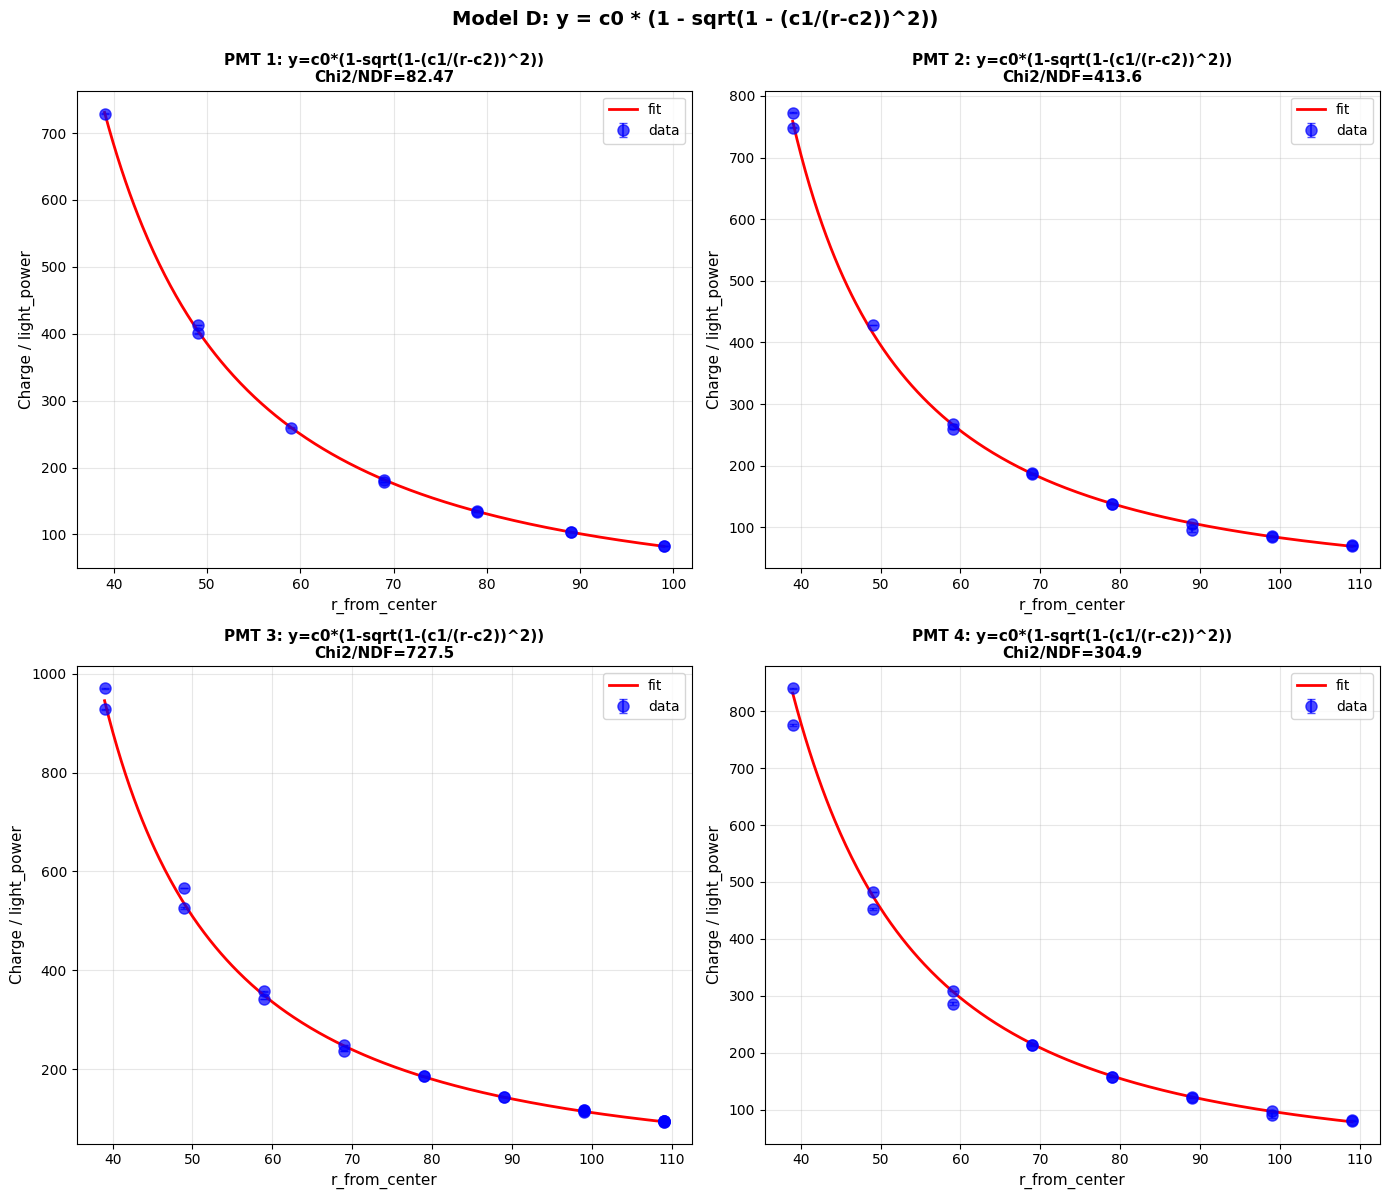


MODEL E グラフ作成中...


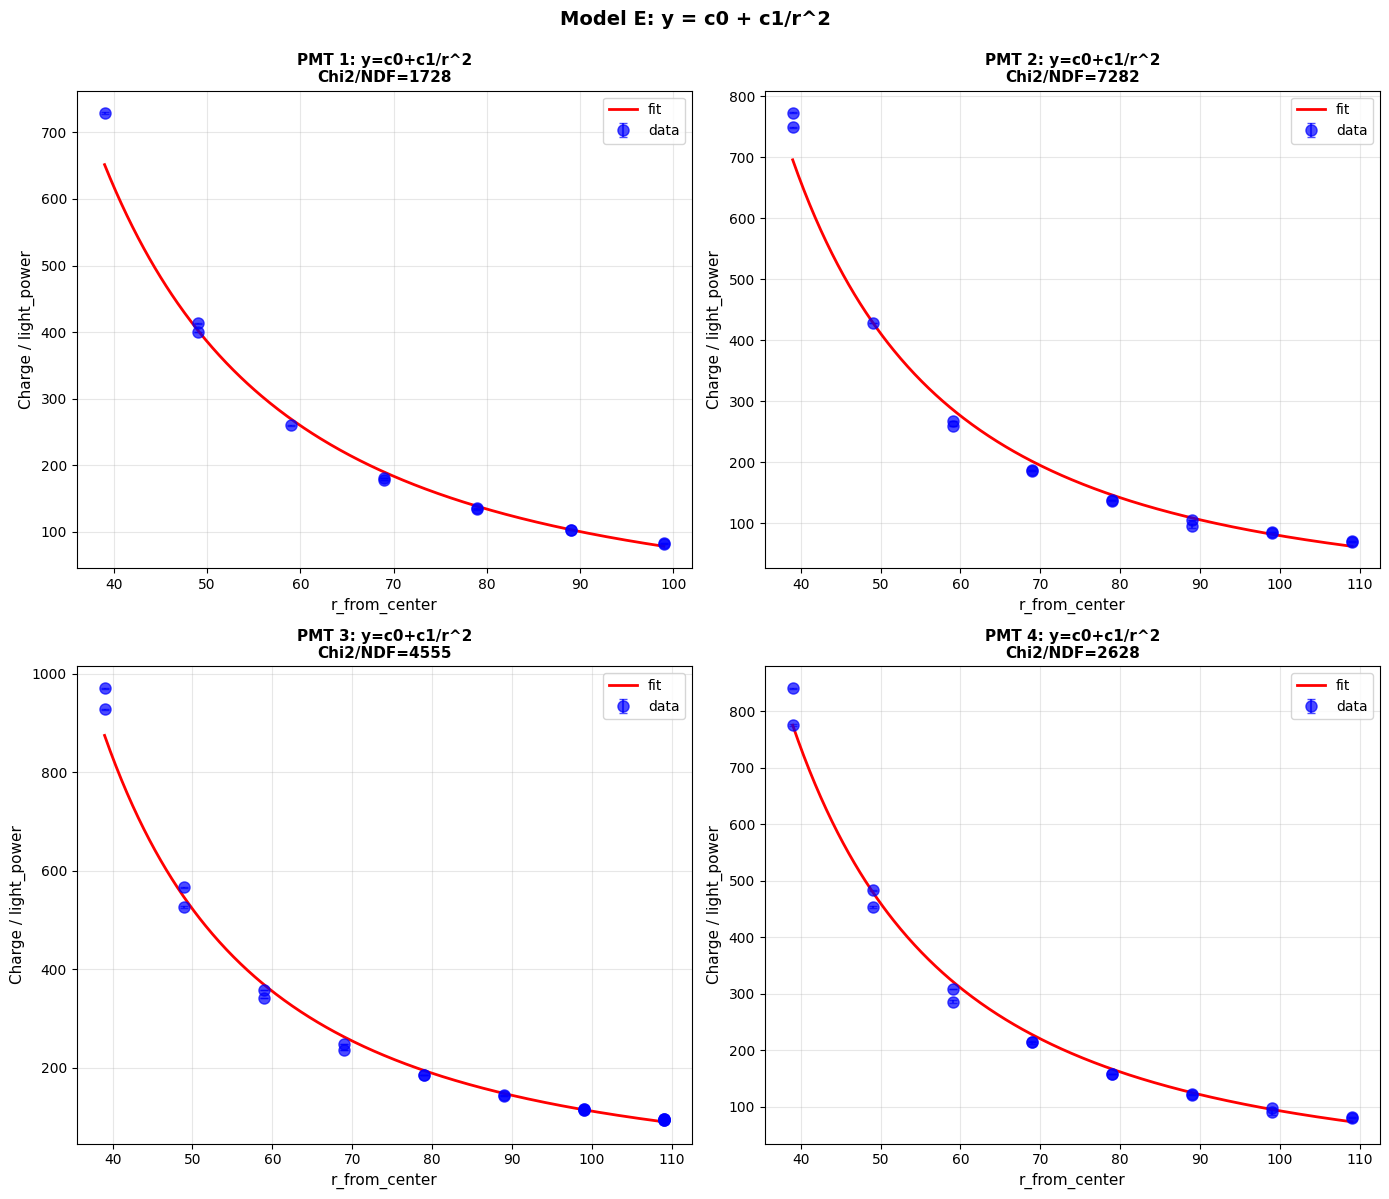


MODEL D: y = c0 * (1 - sqrt(1 - (c1/(r-c2))^2))
 PMT   N           c0           c1           c2         Chi2   NDF   Chi2/NDF   Status
----------------------------------------------------------------------------------------------------------------------------------
   1  12         2654        23.09        5.496        742.3     9      82.47       OK
   2  15         2180        26.06        4.638         4964    12      413.6       OK
   3  22         2678        27.97        2.314    1.382e+04    19      727.5       OK
   4  16    4.314e+05        1.931        7.888         3964    13      304.9       OK

MODEL E: y = c0 + c1/r^2
 PMT   N           c0           c1         Chi2   NDF   Chi2/NDF   Status
--------------------------------------------------------------------------------------------------------------
   1  12       -26.98    1.032e+06    1.728e+04    10       1728       OK
   2  15       -30.66    1.105e+06    9.467e+04    13       7282       OK
   3  22       -25.28    1

In [ ]:
# さらに2つのモデルのフィット比較
# Model D: y = c0 * (1 - sqrt(1 - (c1/(r-c2))^2))
# Model E: y = c0 + c1/r^2
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# PMT設定
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

# モデル定義
def model_d(r, c0, c1, c2):
    """Model D: y = c0 * (1 - sqrt(1 - (c1/(r-c2))^2))"""
    return c0 * (1.0 - np.sqrt(1.0 - (c1 / (r - c2)) ** 2))

def model_e(r, c0, c1):
    """Model E: y = c0 + c1/r^2"""
    return c0 + c1 / (r ** 2)

# 結果格納用（モデルごと）
results_model_d = []
results_model_e = []

# プロット用データ
plot_data_d = []
plot_data_e = []

# ============================================================================
# Model D: y = c0 * (1 - sqrt(1 - (c1/(r-c2))^2))
# ============================================================================
print("\n" + "="*80)
print("MODEL D: y = c0 * (1 - sqrt(1 - (c1/(r-c2))^2))")
print("="*80)

for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\nPMT {pmt_num} (x={x_coord}, y={y_coord})")
    
    # フィルタリング
    filtered = df[(df['#PMT_num'] == pmt_num) & 
                  (df['x'] == x_coord) & 
                  (df['y'] == y_coord)].copy()
    
    # charge/light_power計算
    filtered['charge_per_power'] = filtered['Charge(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    filtered['charge_per_power_err'] = filtered['Charge_err(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    filtered = filtered[filtered['charge_per_power'] >= 20]
    
    # 配列準備
    x = filtered['r_from_center'].to_numpy(dtype=float)
    y = filtered['charge_per_power'].to_numpy(dtype=float)
    y_err = filtered['charge_per_power_err'].to_numpy(dtype=float)
    
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (y_err > 0)
    x = x[mask]
    y = y[mask]
    y_err = y_err[mask]
    
    if len(x) < 4:
        results_model_d.append({
            'pmt': pmt_num,
            'c0': None,
            'c1': None,
            'c2': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': len(x)
        })
        plot_data_d.append({
            'pmt': pmt_num,
            'x': np.array([]),
            'y': np.array([]),
            'y_err': np.array([]),
            'x_fit': np.array([]),
            'y_fit': np.array([])
        })
        continue
    
    # Weighted フィット
    try:
        popt, _ = curve_fit(model_d, x, y, p0=[1600.0, 32.5, 0.0], 
                           sigma=y_err, absolute_sigma=True, maxfev=20000)
        c0, c1, c2 = popt[0], popt[1], popt[2]
        
        # chi2計算
        y_fit = model_d(x, c0, c1, c2)
        residuals = (y - y_fit) / y_err
        chi2 = np.sum(residuals**2)
        ndf = len(x) - 3
        chi2_ndf = chi2 / ndf if ndf > 0 else float('inf')
        
        results_model_d.append({
            'pmt': pmt_num,
            'c0': c0,
            'c1': c1,
            'c2': c2,
            'chi2': chi2,
            'ndf': ndf,
            'chi2_ndf': chi2_ndf,
            'success': True,
            'n_points': len(x)
        })
        print(f"  Fit OK: c0={c0:.4g}, c1={c1:.4g}, c2={c2:.4g}, Chi2/NDF={chi2_ndf:.4g}")
        
        # プロット用データ保存
        x_fit = np.linspace(np.min(x), np.max(x), 400)
        y_fit_plot = model_d(x_fit, c0, c1, c2)
        plot_data_d.append({
            'pmt': pmt_num,
            'x': x,
            'y': y,
            'y_err': y_err,
            'x_fit': x_fit,
            'y_fit': y_fit_plot
        })
    except Exception as e:
        print(f"  Fit failed: {e}")
        results_model_d.append({
            'pmt': pmt_num,
            'c0': None,
            'c1': None,
            'c2': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': len(x)
        })
        plot_data_d.append({
            'pmt': pmt_num,
            'x': np.array([]),
            'y': np.array([]),
            'y_err': np.array([]),
            'x_fit': np.array([]),
            'y_fit': np.array([])
        })

# ============================================================================
# Model E: y = c0 + c1/r^2
# ============================================================================
print("\n" + "="*80)
print("MODEL E: y = c0 + c1/r^2")
print("="*80)

for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\nPMT {pmt_num} (x={x_coord}, y={y_coord})")
    
    # フィルタリング
    filtered = df[(df['#PMT_num'] == pmt_num) & 
                  (df['x'] == x_coord) & 
                  (df['y'] == y_coord)].copy()
    
    # charge/light_power計算
    filtered['charge_per_power'] = filtered['Charge(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    filtered['charge_per_power_err'] = filtered['Charge_err(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    filtered = filtered[filtered['charge_per_power'] >= 20]
    
    # 配列準備
    x = filtered['r_from_center'].to_numpy(dtype=float)
    y = filtered['charge_per_power'].to_numpy(dtype=float)
    y_err = filtered['charge_per_power_err'].to_numpy(dtype=float)
    
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (y_err > 0)
    x = x[mask]
    y = y[mask]
    y_err = y_err[mask]
    
    if len(x) == 0:
        results_model_e.append({
            'pmt': pmt_num,
            'c0': None,
            'c1': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': 0
        })
        plot_data_e.append({
            'pmt': pmt_num,
            'x': np.array([]),
            'y': np.array([]),
            'y_err': np.array([]),
            'x_fit': np.array([]),
            'y_fit': np.array([])
        })
        continue
    
    # Weighted フィット
    try:
        popt, _ = curve_fit(model_e, x, y, p0=[100.0, 6000.0], 
                           sigma=y_err, absolute_sigma=True, maxfev=20000)
        c0, c1 = popt[0], popt[1]
        
        # chi2計算
        y_fit = model_e(x, c0, c1)
        residuals = (y - y_fit) / y_err
        chi2 = np.sum(residuals**2)
        ndf = len(x) - 2
        chi2_ndf = chi2 / ndf if ndf > 0 else float('inf')
        
        results_model_e.append({
            'pmt': pmt_num,
            'c0': c0,
            'c1': c1,
            'chi2': chi2,
            'ndf': ndf,
            'chi2_ndf': chi2_ndf,
            'success': True,
            'n_points': len(x)
        })
        print(f"  Fit OK: c0={c0:.4g}, c1={c1:.4g}, Chi2/NDF={chi2_ndf:.4g}")
        
        # プロット用データ保存
        x_fit = np.linspace(np.min(x), np.max(x), 400)
        y_fit_plot = model_e(x_fit, c0, c1)
        plot_data_e.append({
            'pmt': pmt_num,
            'x': x,
            'y': y,
            'y_err': y_err,
            'x_fit': x_fit,
            'y_fit': y_fit_plot
        })
    except Exception as e:
        print(f"  Fit failed: {e}")
        results_model_e.append({
            'pmt': pmt_num,
            'c0': None,
            'c1': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': len(x)
        })
        plot_data_e.append({
            'pmt': pmt_num,
            'x': np.array([]),
            'y': np.array([]),
            'y_err': np.array([]),
            'x_fit': np.array([]),
            'y_fit': np.array([])
        })

# ============================================================================
# グラフ: Model D (2x2グリッド)
# ============================================================================
print("\n" + "="*80)
print("MODEL D グラフ作成中...")
print("="*80)

fig_d, axes_d = plt.subplots(2, 2, figsize=(14, 12))
axes_d = axes_d.flatten()

for idx, data in enumerate(plot_data_d):
    ax = axes_d[idx]
    pmt_num = data['pmt']
    
    if len(data['x']) > 0:
        ax.errorbar(data['x'], data['y'], yerr=data['y_err'], fmt='o', alpha=0.7, 
                   capsize=3, markersize=8, label='data', color='blue')
        ax.plot(data['x_fit'], data['y_fit'], color='red', linewidth=2, label='fit')
        ax.set_xlabel('r_from_center', fontsize=11)
        ax.set_ylabel('Charge / light_power', fontsize=11)
        
        res = results_model_d[idx]
        if res['success']:
            ax.set_title(f"PMT {pmt_num}: y=c0*(1-sqrt(1-(c1/(r-c2))^2))\n"
                        f"Chi2/NDF={res['chi2_ndf']:.4g}", fontsize=11, fontweight='bold')
        else:
            ax.set_title(f"PMT {pmt_num}: Fit Failed", fontsize=11, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f'PMT {pmt_num}\nNo Data', ha='center', va='center', 
               fontsize=12, transform=ax.transAxes)
    
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

plt.suptitle('Model D: y = c0 * (1 - sqrt(1 - (c1/(r-c2))^2))', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# グラフ: Model E (2x2グリッド)
# ============================================================================
print("\n" + "="*80)
print("MODEL E グラフ作成中...")
print("="*80)

fig_e, axes_e = plt.subplots(2, 2, figsize=(14, 12))
axes_e = axes_e.flatten()

for idx, data in enumerate(plot_data_e):
    ax = axes_e[idx]
    pmt_num = data['pmt']
    
    if len(data['x']) > 0:
        ax.errorbar(data['x'], data['y'], yerr=data['y_err'], fmt='o', alpha=0.7, 
                   capsize=3, markersize=8, label='data', color='blue')
        ax.plot(data['x_fit'], data['y_fit'], color='red', linewidth=2, label='fit')
        ax.set_xlabel('r_from_center', fontsize=11)
        ax.set_ylabel('Charge / light_power', fontsize=11)
        
        res = results_model_e[idx]
        if res['success']:
            ax.set_title(f"PMT {pmt_num}: y=c0+c1/r^2\n"
                        f"Chi2/NDF={res['chi2_ndf']:.4g}", fontsize=11, fontweight='bold')
        else:
            ax.set_title(f"PMT {pmt_num}: Fit Failed", fontsize=11, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f'PMT {pmt_num}\nNo Data', ha='center', va='center', 
               fontsize=12, transform=ax.transAxes)
    
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

plt.suptitle('Model E: y = c0 + c1/r^2', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# 結果テーブル表示
# ============================================================================
print("\n" + "="*130)
print("MODEL D: y = c0 * (1 - sqrt(1 - (c1/(r-c2))^2))")
print("="*130)
print(f"{'PMT':>4} {'N':>3} {'c0':>12} {'c1':>12} {'c2':>12} {'Chi2':>12} {'NDF':>5} {'Chi2/NDF':>10} {'Status':>8}")
print("-"*130)
for res in results_model_d:
    if res['success']:
        print(f"{res['pmt']:>4} {res['n_points']:>3} {res['c0']:>12.4g} {res['c1']:>12.4g} {res['c2']:>12.4g} {res['chi2']:>12.4g} {res['ndf']:>5} {res['chi2_ndf']:>10.4g} {'OK':>8}")
    else:
        print(f"{res['pmt']:>4} {res['n_points']:>3} {'N/A':>12} {'N/A':>12} {'N/A':>12} {'N/A':>12} {'N/A':>5} {'N/A':>10} {'FAILED':>8}")
print("="*130)

print("\n" + "="*110)
print("MODEL E: y = c0 + c1/r^2")
print("="*110)
print(f"{'PMT':>4} {'N':>3} {'c0':>12} {'c1':>12} {'Chi2':>12} {'NDF':>5} {'Chi2/NDF':>10} {'Status':>8}")
print("-"*110)
for res in results_model_e:
    if res['success']:
        print(f"{res['pmt']:>4} {res['n_points']:>3} {res['c0']:>12.4g} {res['c1']:>12.4g} {res['chi2']:>12.4g} {res['ndf']:>5} {res['chi2_ndf']:>10.4g} {'OK':>8}")
    else:
        print(f"{res['pmt']:>4} {res['n_points']:>3} {'N/A':>12} {'N/A':>12} {'N/A':>12} {'N/A':>5} {'N/A':>10} {'FAILED':>8}")
print("="*110)

全モデルの2回フィット実行（1回目の結果を初期値として2回目を実行）

MODEL A: y=c0*(1-sqrt(1-(32.5/r)^2))
初期値: [1600.0]
  PMT 1 (x=-35, y=35):
    1回目: params=[1549.84970687], Chi2/NDF=781.8
    2回目: params=[1549.84970687], Chi2/NDF=781.8
  PMT 2 (x=35, y=35):
    1回目: params=[1617.43245999], Chi2/NDF=2144
    2回目: params=[1617.43245999], Chi2/NDF=2144
  PMT 3 (x=-35, y=-35):
    1回目: params=[2091.92062557], Chi2/NDF=783.4
    2回目: params=[2091.92062557], Chi2/NDF=783.4
  PMT 4 (x=35, y=-35):
    1回目: params=[1821.78059145], Chi2/NDF=959.2
    2回目: params=[1821.78059145], Chi2/NDF=959.2

MODEL B: y=c0*(1-sqrt(1-(c1/r)^2))
初期値: [1600.0, 32.5]
  PMT 1 (x=-35, y=35):
    1回目: params=[1268.08880671   35.50498466], Chi2/NDF=337
    2回目: params=[1268.09029055   35.50496692], Chi2/NDF=337
  PMT 2 (x=35, y=35):
    1回目: params=[1312.20873032   35.3893605 ], Chi2/NDF=660.7
    2回目: params=[1312.20850052   35.38936288], Chi2/NDF=660.7
  PMT 3 (x=-35, y=-35):
    1回目: params=[1985.75819394   33.23962756], Chi2/NDF=755
    2回目: p

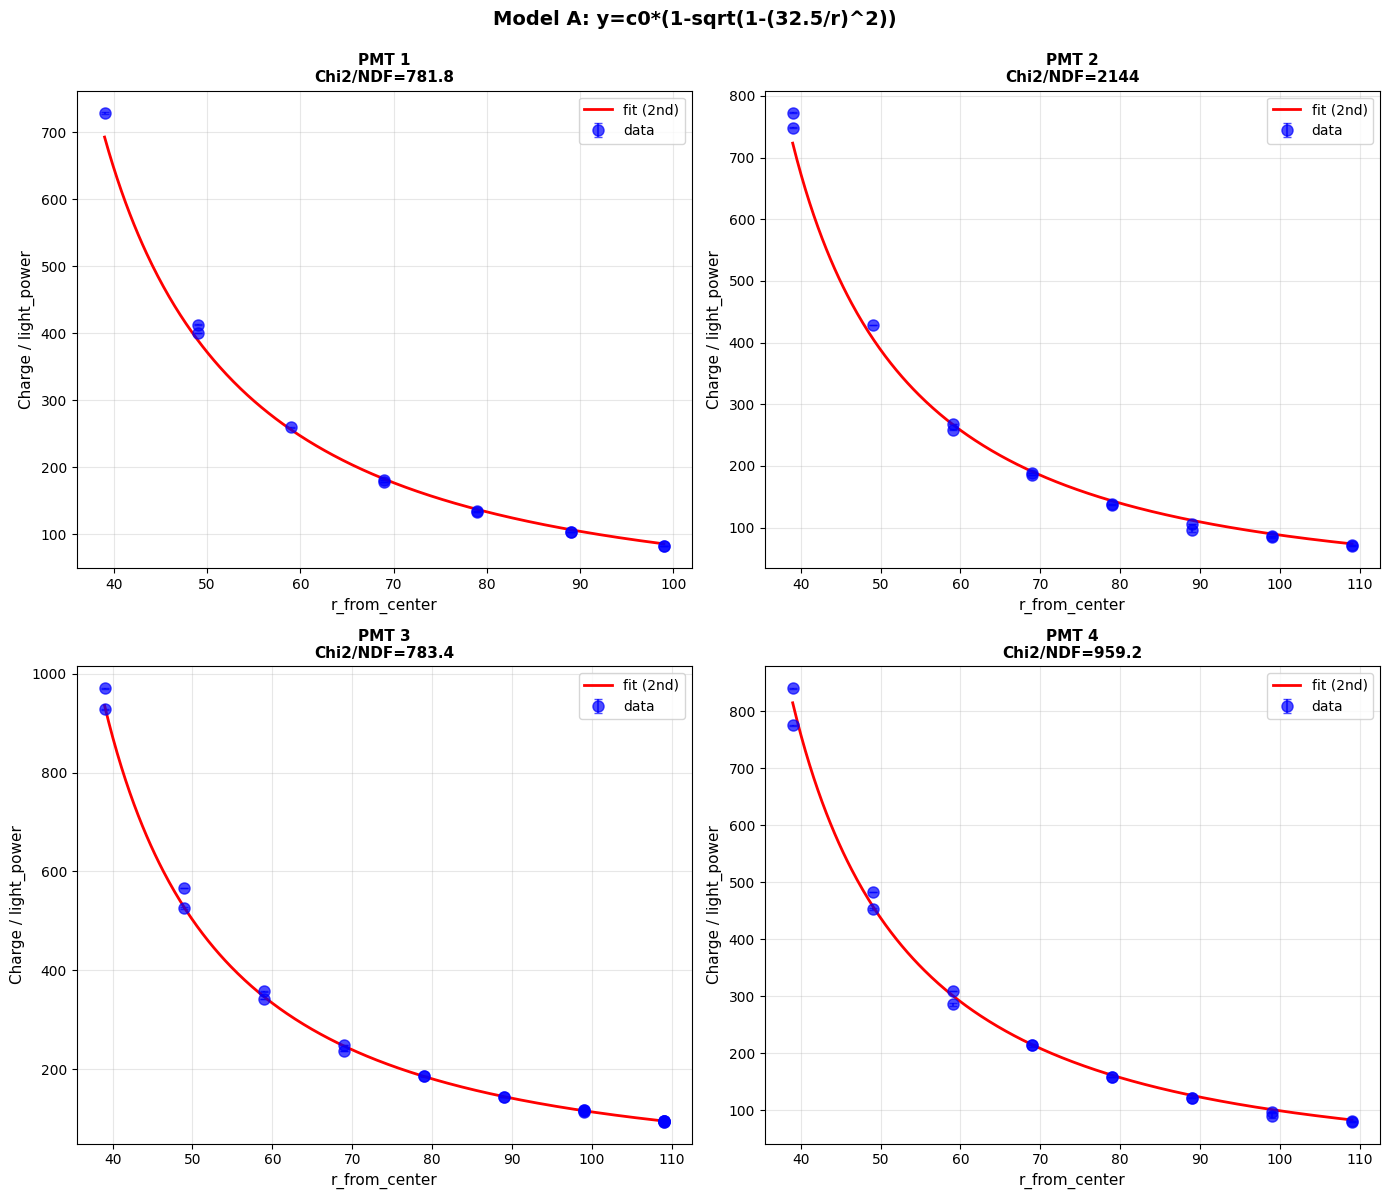


MODEL B グラフ作成中...


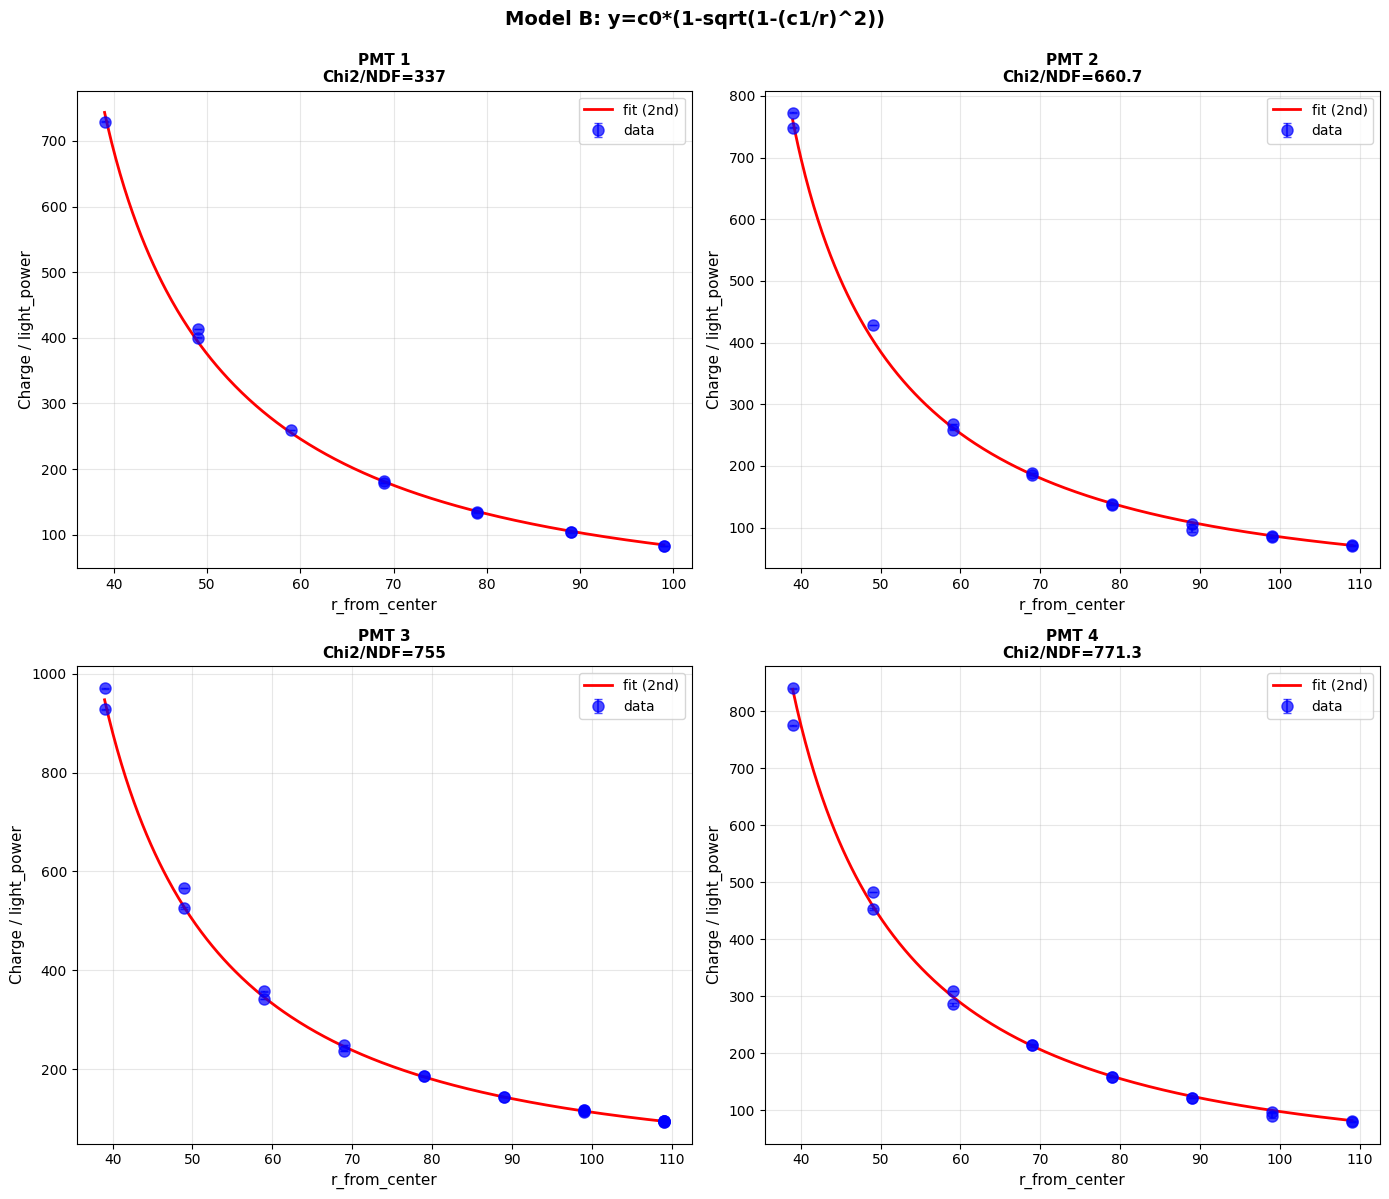


MODEL C グラフ作成中...


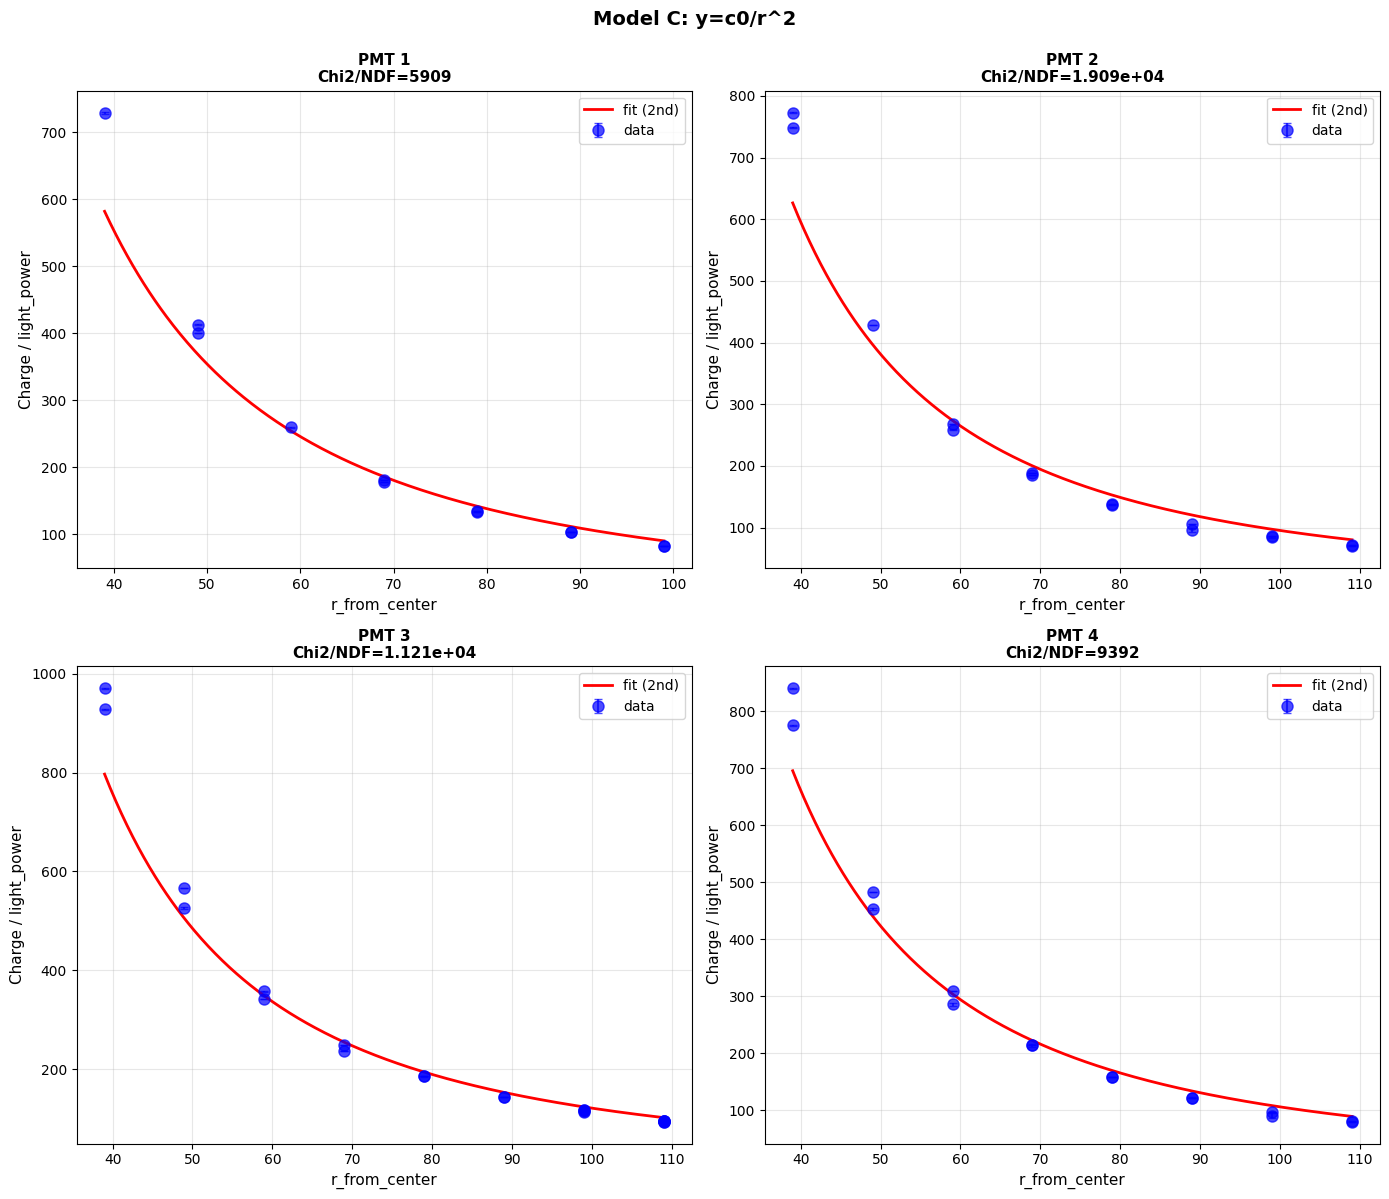


MODEL D グラフ作成中...


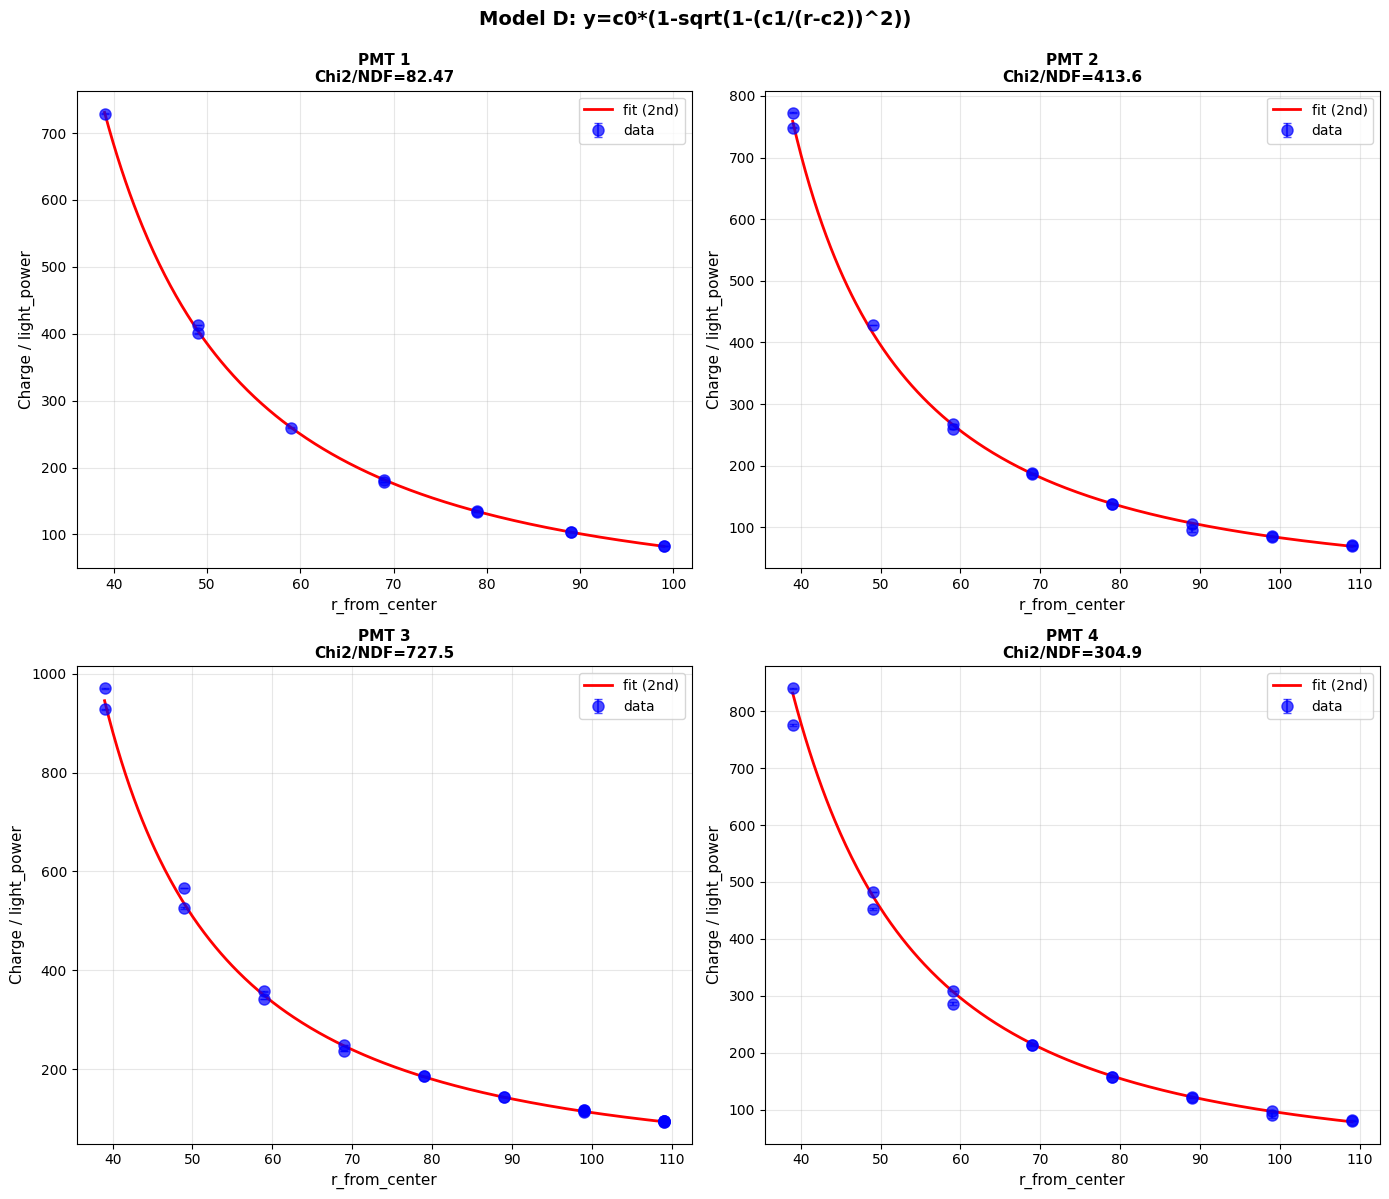


MODEL E グラフ作成中...


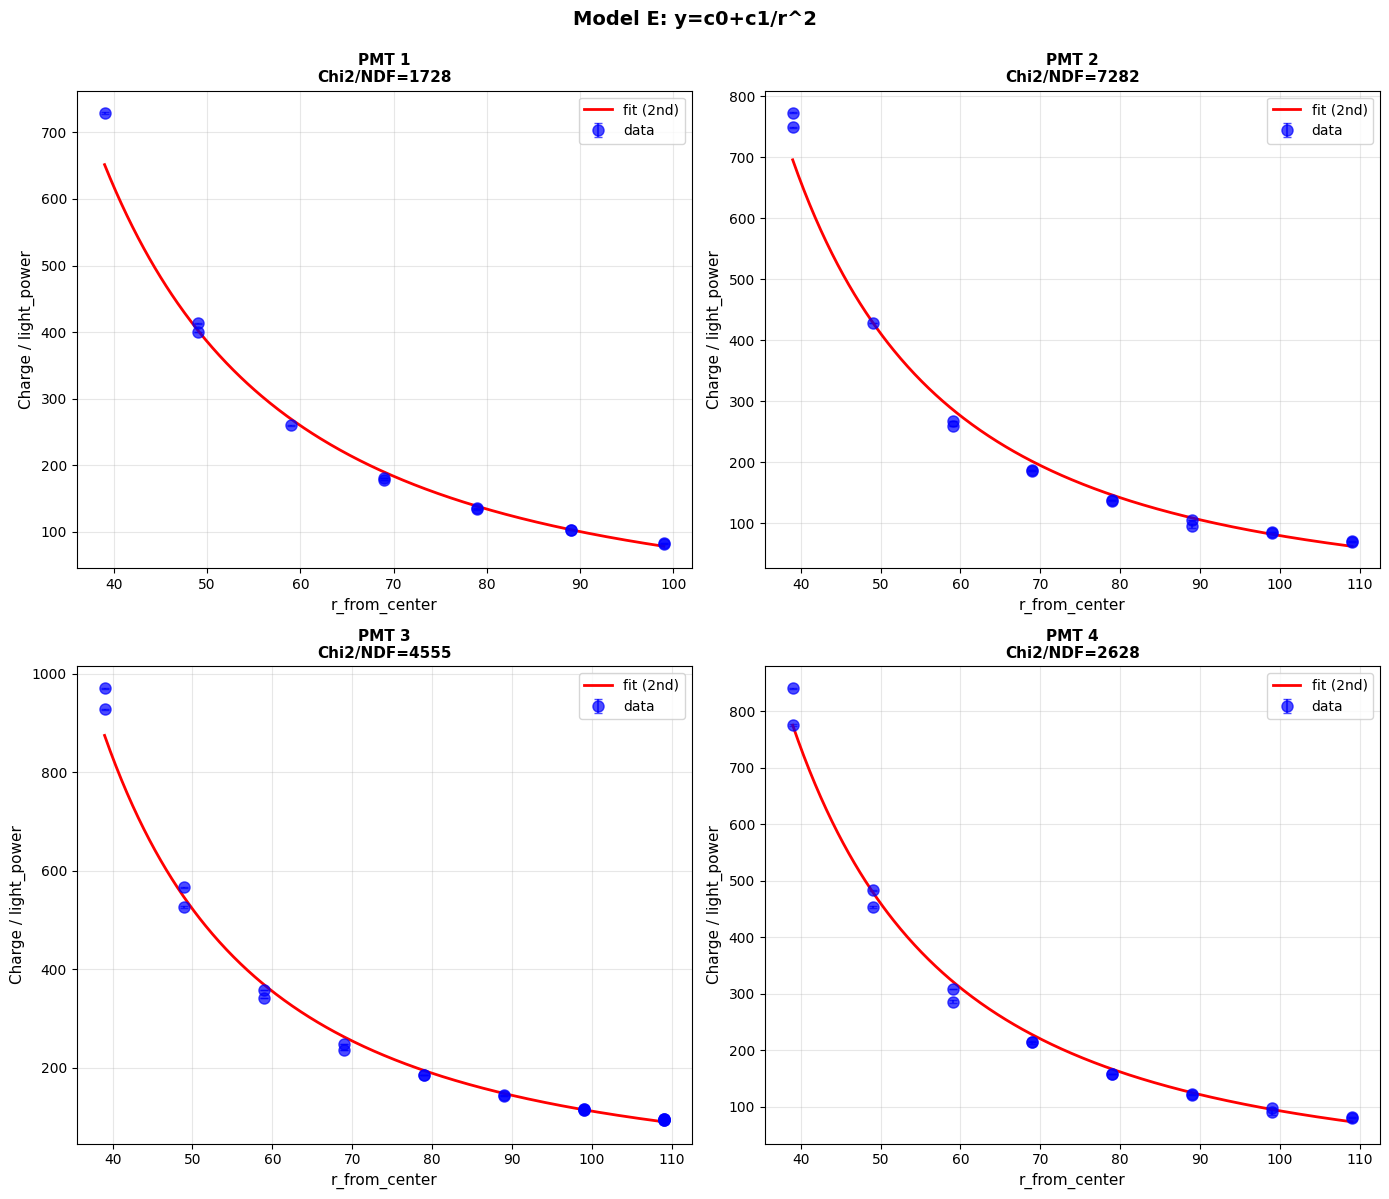


MODEL F グラフ作成中...


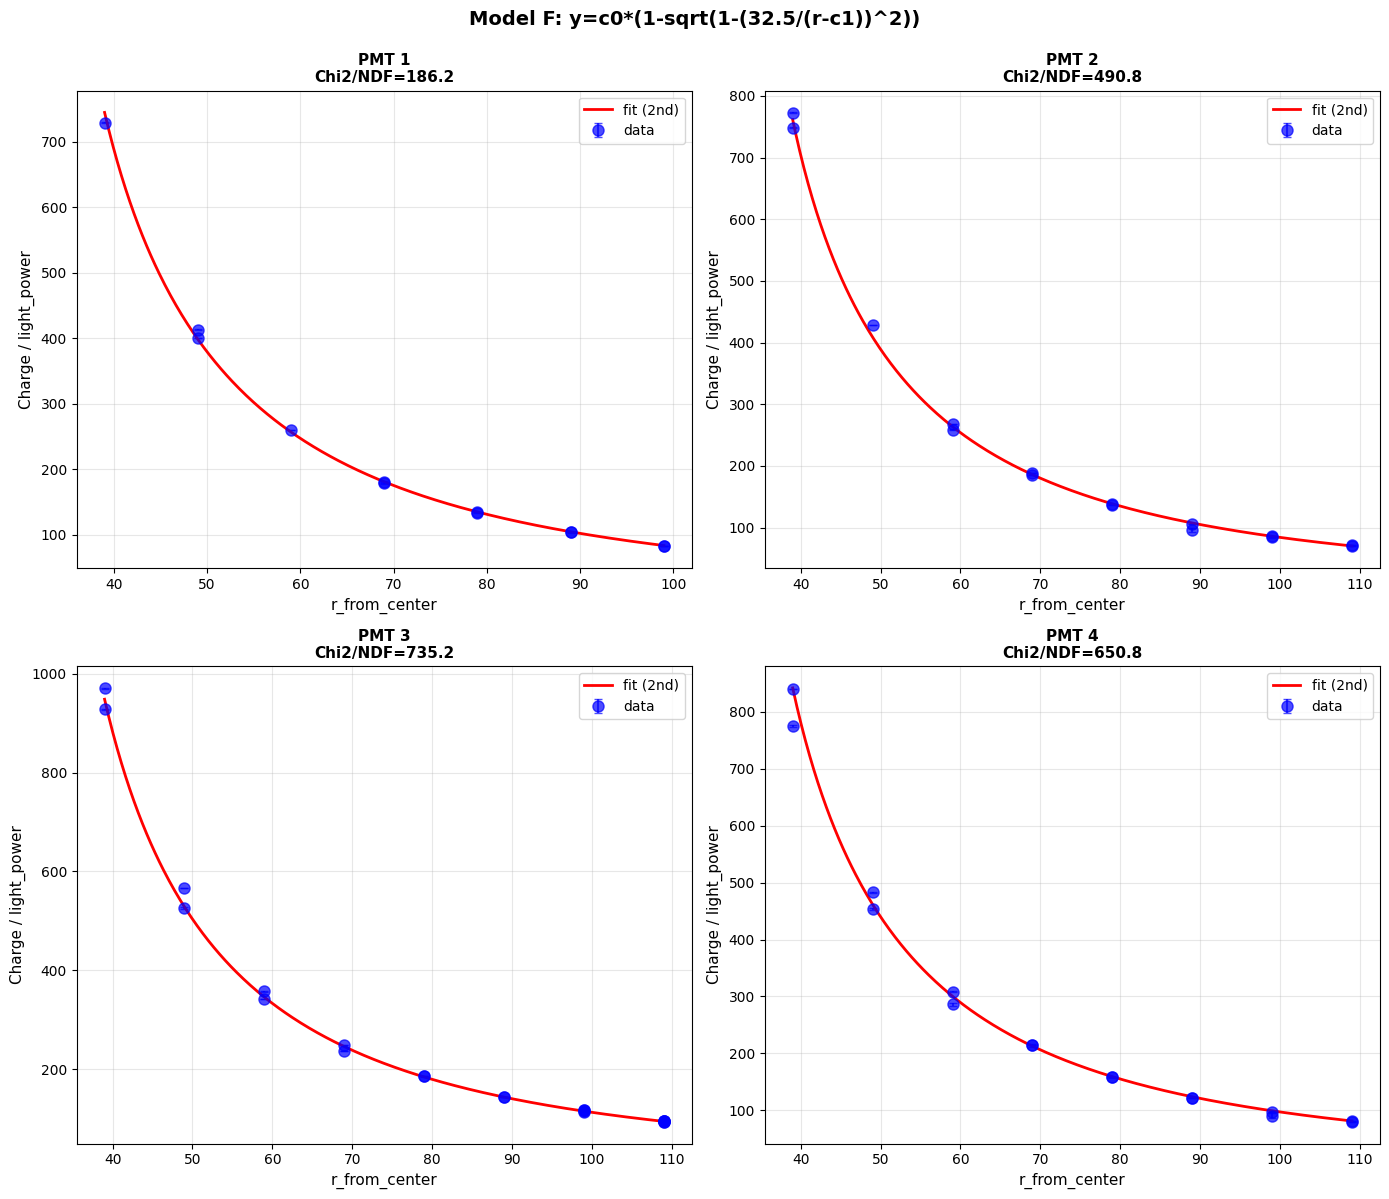


全モデル比較テーブル（2回目のフィット結果）
   Model  PMT   N     Chi2/NDF                                                                       Parameters
--------------------------------------------------------------------------------------------------------------------------------------------
       A    1  12        781.8                                                                             1550
       A    2  15         2144                                                                             1617
       A    3  22        783.4                                                                             2092
       A    4  16        959.2                                                                             1822
       B    1  12          337                                                                       1268, 35.5
       B    2  15        660.7                                                                      1312, 35.39
       B    3  22          755                     

In [ ]:
# 全モデルの2回フィット実行（1回目の結果を初期値として2回目を実行）
# Model A: y = c0 * (1 - sqrt(1 - (32.5/r)^2))
# Model B: y = c0 * (1 - sqrt(1 - (c1/r)^2))
# Model C: y = c0/r^2
# Model D (改): y = c0 * (1 - sqrt(1 - (c1/(r-c2))^2))  初期値変更
# Model E: y = c0 + c1/r^2
# Model F (新規): y = c0 * (1 - sqrt(1 - (32.5/(r-c1))^2))
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# PMT設定
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

# ============================================================================
# モデル定義
# ============================================================================
a_const = 32.5

def model_a(r, c0):
    """Model A: y = c0 * (1 - sqrt(1 - (32.5/r)^2))"""
    return c0 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

def model_b(r, c0, c1):
    """Model B: y = c0 * (1 - sqrt(1 - (c1/r)^2))"""
    return c0 * (1.0 - np.sqrt(1.0 - (c1 / r) ** 2))

def model_c(r, c0):
    """Model C: y = c0/r^2"""
    return c0 / (r ** 2)

def model_d(r, c0, c1, c2):
    """Model D: y = c0 * (1 - sqrt(1 - (c1/(r-c2))^2))"""
    return c0 * (1.0 - np.sqrt(1.0 - (c1 / (r - c2)) ** 2))

def model_e(r, c0, c1):
    """Model E: y = c0 + c1/r^2"""
    return c0 + c1 / (r ** 2)

def model_f(r, c0, c1):
    """Model F: y = c0 * (1 - sqrt(1 - (32.5/(r-c1))^2))"""
    return c0 * (1.0 - np.sqrt(1.0 - (a_const / (r - c1)) ** 2))

# ============================================================================
# 2回フィット実行関数
# ============================================================================
def double_fit(model_func, x, y, y_err, p0_initial, n_params, model_name, pmt_num):
    """2回フィットを実行（1回目の結果を初期値として2回目を実行）"""
    
    if len(x) < n_params + 1:
        return None, None, None
    
    try:
        # 1回目のフィット
        popt1, _ = curve_fit(model_func, x, y, p0=p0_initial, 
                            sigma=y_err, absolute_sigma=True, maxfev=20000)
        
        y_fit1 = model_func(x, *popt1)
        residuals1 = (y - y_fit1) / y_err
        chi2_1 = np.sum(residuals1**2)
        ndf1 = len(x) - n_params
        chi2_ndf_1 = chi2_1 / ndf1 if ndf1 > 0 else float('inf')
        
        # 2回目のフィット（1回目の結果を初期値として使用）
        popt2, _ = curve_fit(model_func, x, y, p0=popt1, 
                            sigma=y_err, absolute_sigma=True, maxfev=20000)
        
        y_fit2 = model_func(x, *popt2)
        residuals2 = (y - y_fit2) / y_err
        chi2_2 = np.sum(residuals2**2)
        ndf2 = len(x) - n_params
        chi2_ndf_2 = chi2_2 / ndf2 if ndf2 > 0 else float('inf')
        
        result1 = {
            'pmt': pmt_num,
            'params': popt1,
            'chi2': chi2_1,
            'ndf': ndf1,
            'chi2_ndf': chi2_ndf_1,
            'success': True,
            'n_points': len(x)
        }
        
        result2 = {
            'pmt': pmt_num,
            'params': popt2,
            'chi2': chi2_2,
            'ndf': ndf2,
            'chi2_ndf': chi2_ndf_2,
            'success': True,
            'n_points': len(x)
        }
        
        # プロット用データ
        x_fit = np.linspace(np.min(x), np.max(x), 400)
        y_fit_plot = model_func(x_fit, *popt2)
        plot_data = {
            'pmt': pmt_num,
            'x': x,
            'y': y,
            'y_err': y_err,
            'x_fit': x_fit,
            'y_fit': y_fit_plot
        }
        
        return result1, result2, plot_data
        
    except Exception as e:
        print(f"  {model_name} PMT {pmt_num}: Fit failed - {e}")
        return None, None, None

# ============================================================================
# 各モデルの処理
# ============================================================================
# 結果格納用
all_results = {
    'A': {'fit1': [], 'fit2': [], 'plot': []},
    'B': {'fit1': [], 'fit2': [], 'plot': []},
    'C': {'fit1': [], 'fit2': [], 'plot': []},
    'D': {'fit1': [], 'fit2': [], 'plot': []},
    'E': {'fit1': [], 'fit2': [], 'plot': []},
    'F': {'fit1': [], 'fit2': [], 'plot': []}
}

models = [
    ('A', model_a, [1600.0], 1, "y=c0*(1-sqrt(1-(32.5/r)^2))"),
    ('B', model_b, [1600.0, 32.5], 2, "y=c0*(1-sqrt(1-(c1/r)^2))"),
    ('C', model_c, [6000.0], 1, "y=c0/r^2"),
    ('D', model_d, [2000.0, 32.5, 0.0], 3, "y=c0*(1-sqrt(1-(c1/(r-c2))^2))"),
    ('E', model_e, [100.0, 6000.0], 2, "y=c0+c1/r^2"),
    ('F', model_f, [2000.0, 0.0], 2, "y=c0*(1-sqrt(1-(32.5/(r-c1))^2))")
]

print("="*100)
print("全モデルの2回フィット実行（1回目の結果を初期値として2回目を実行）")
print("="*100)

for model_name, model_func, p0_initial, n_params, formula in models:
    print(f"\n{'='*90}")
    print(f"MODEL {model_name}: {formula}")
    print(f"初期値: {p0_initial}")
    print('='*90)
    
    for pmt_num, x_coord, y_coord in pmt_configs:
        # フィルタリング
        filtered = df[(df['#PMT_num'] == pmt_num) & 
                      (df['x'] == x_coord) & 
                      (df['y'] == y_coord)].copy()
        
        filtered['charge_per_power'] = filtered['Charge(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
        filtered['charge_per_power_err'] = filtered['Charge_err(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
        filtered = filtered[filtered['charge_per_power'] >= 20]
        
        # 配列準備
        x = filtered['r_from_center'].to_numpy(dtype=float)
        y = filtered['charge_per_power'].to_numpy(dtype=float)
        y_err = filtered['charge_per_power_err'].to_numpy(dtype=float)
        
        # Model Aの場合のみr >= 32.5の条件を追加
        if model_name == 'A':
            mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (x >= a_const) & (y_err > 0)
        else:
            mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (y_err > 0)
        
        x = x[mask]
        y = y[mask]
        y_err = y_err[mask]
        
        # 2回フィット実行
        result1, result2, plot_data = double_fit(
            model_func, x, y, y_err, p0_initial, n_params, 
            f"Model {model_name}", pmt_num
        )
        
        if result1 is not None and result2 is not None:
            all_results[model_name]['fit1'].append(result1)
            all_results[model_name]['fit2'].append(result2)
            all_results[model_name]['plot'].append(plot_data)
            
            print(f"  PMT {pmt_num} (x={x_coord}, y={y_coord}):")
            print(f"    1回目: params={result1['params']}, Chi2/NDF={result1['chi2_ndf']:.4g}")
            print(f"    2回目: params={result2['params']}, Chi2/NDF={result2['chi2_ndf']:.4g}")
        else:
            # フィット失敗
            all_results[model_name]['fit1'].append({
                'pmt': pmt_num,
                'params': None,
                'chi2': None,
                'ndf': None,
                'chi2_ndf': None,
                'success': False,
                'n_points': len(x)
            })
            all_results[model_name]['fit2'].append({
                'pmt': pmt_num,
                'params': None,
                'chi2': None,
                'ndf': None,
                'chi2_ndf': None,
                'success': False,
                'n_points': len(x)
            })
            all_results[model_name]['plot'].append({
                'pmt': pmt_num,
                'x': np.array([]),
                'y': np.array([]),
                'y_err': np.array([]),
                'x_fit': np.array([]),
                'y_fit': np.array([])
            })

# ============================================================================
# 各モデルのグラフ表示（2x2グリッド）
# ============================================================================
for model_name, _, _, _, formula in models:
    print(f"\n{'='*90}")
    print(f"MODEL {model_name} グラフ作成中...")
    print('='*90)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, data in enumerate(all_results[model_name]['plot']):
        ax = axes[idx]
        pmt_num = data['pmt']
        
        if len(data['x']) > 0:
            ax.errorbar(data['x'], data['y'], yerr=data['y_err'], fmt='o', alpha=0.7, 
                       capsize=3, markersize=8, label='data', color='blue')
            ax.plot(data['x_fit'], data['y_fit'], color='red', linewidth=2, label='fit (2nd)')
            ax.set_xlabel('r_from_center', fontsize=11)
            ax.set_ylabel('Charge / light_power', fontsize=11)
            
            res2 = all_results[model_name]['fit2'][idx]
            if res2['success']:
                ax.set_title(f"PMT {pmt_num}\nChi2/NDF={res2['chi2_ndf']:.4g}", 
                           fontsize=11, fontweight='bold')
            else:
                ax.set_title(f"PMT {pmt_num}: Fit Failed", fontsize=11, fontweight='bold')
        else:
            ax.text(0.5, 0.5, f'PMT {pmt_num}\nNo Data', ha='center', va='center', 
                   fontsize=12, transform=ax.transAxes)
        
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
    
    plt.suptitle(f'Model {model_name}: {formula}', 
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 結果テーブル表示（全モデル比較）
# ============================================================================
print("\n" + "="*140)
print("全モデル比較テーブル（2回目のフィット結果）")
print("="*140)
print(f"{'Model':>8} {'PMT':>4} {'N':>3} {'Chi2/NDF':>12} {'Parameters':>80}")
print("-"*140)

for model_name in ['A', 'B', 'C', 'D', 'E', 'F']:
    for idx, res2 in enumerate(all_results[model_name]['fit2']):
        if res2['success']:
            params_str = ', '.join([f"{p:.4g}" for p in res2['params']])
            print(f"{model_name:>8} {res2['pmt']:>4} {res2['n_points']:>3} {res2['chi2_ndf']:>12.4g} {params_str:>80}")
        else:
            print(f"{model_name:>8} {res2['pmt']:>4} {res2['n_points']:>3} {'FAILED':>12} {'N/A':>80}")

print("="*140)

# ============================================================================
# Chi2/NDF比較サマリー
# ============================================================================
print("\n" + "="*100)
print("Chi2/NDF サマリー（2回目のフィット結果）")
print("="*100)
print(f"{'PMT':>4} {'Model A':>12} {'Model B':>12} {'Model C':>12} {'Model D':>12} {'Model E':>12} {'Model F':>12}")
print("-"*100)

for pmt_idx in range(4):
    pmt_num = pmt_idx + 1
    row = f"{pmt_num:>4}"
    for model_name in ['A', 'B', 'C', 'D', 'E', 'F']:
        res2 = all_results[model_name]['fit2'][pmt_idx]
        if res2['success']:
            row += f" {res2['chi2_ndf']:>12.4g}"
        else:
            row += f" {'N/A':>12}"
    print(row)

print("="*100)

MODEL F: y = c0 * (1 - sqrt(1 - (32.5/(r-c1))^2))
初期値: c0=2000.0, c1=0.0

PMT 1 (x=-35, y=35)
After filter (charge_per_power >= 20): 12 points
  1回目: c0=1448.87, c1=1.81509, Chi2/NDF=186.2
  2回目: c0=1448.87, c1=1.81509, Chi2/NDF=186.2

PMT 2 (x=35, y=35)
After filter (charge_per_power >= 20): 15 points
  1回目: c0=1494.61, c1=1.70516, Chi2/NDF=490.8
  2回目: c0=1494.61, c1=1.70516, Chi2/NDF=490.8

PMT 3 (x=-35, y=-35)
After filter (charge_per_power >= 20): 22 points
  1回目: c0=2058.68, c1=0.403405, Chi2/NDF=735.2
  2回目: c0=2058.68, c1=0.403405, Chi2/NDF=735.2

PMT 4 (x=35, y=-35)
After filter (charge_per_power >= 20): 16 points
  1回目: c0=1748.84, c1=0.994191, Chi2/NDF=650.8
  2回目: c0=1748.84, c1=0.994191, Chi2/NDF=650.8

Model F: 個別グラフ作成中...


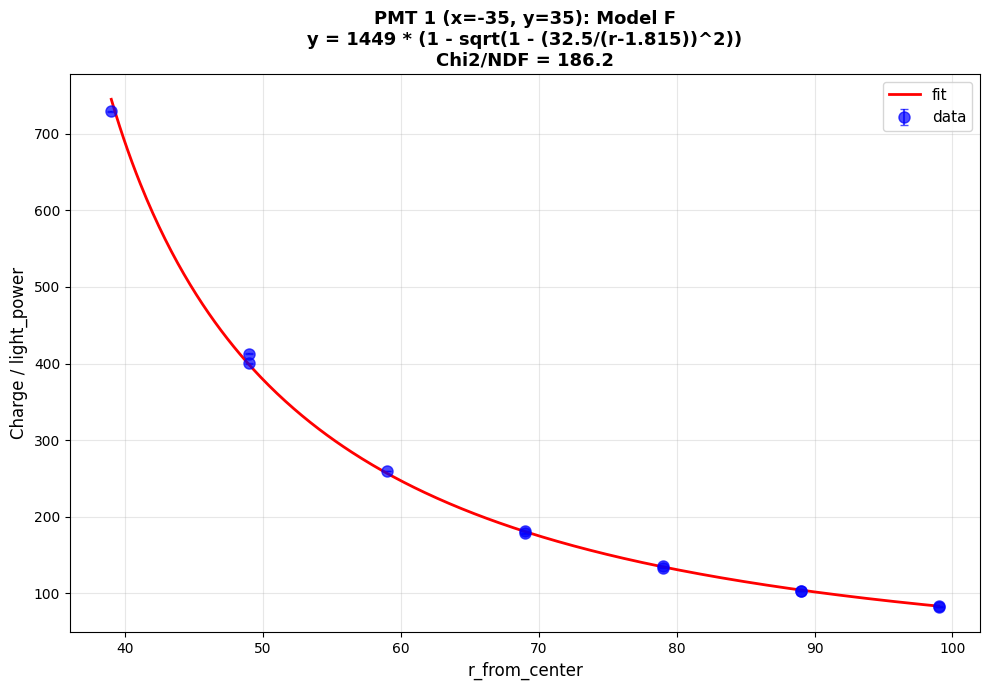

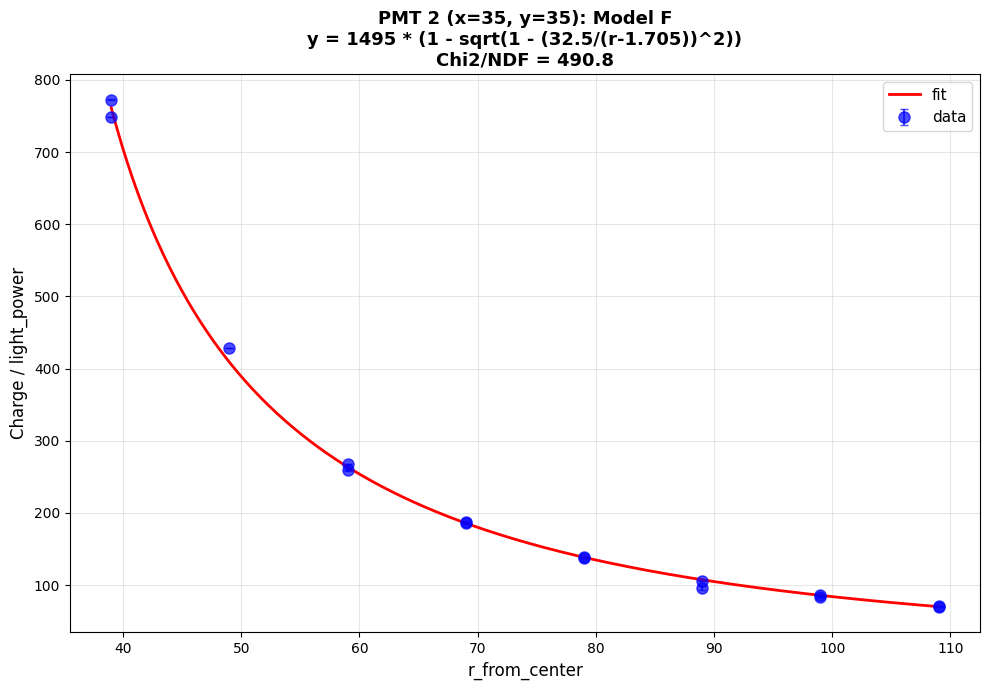

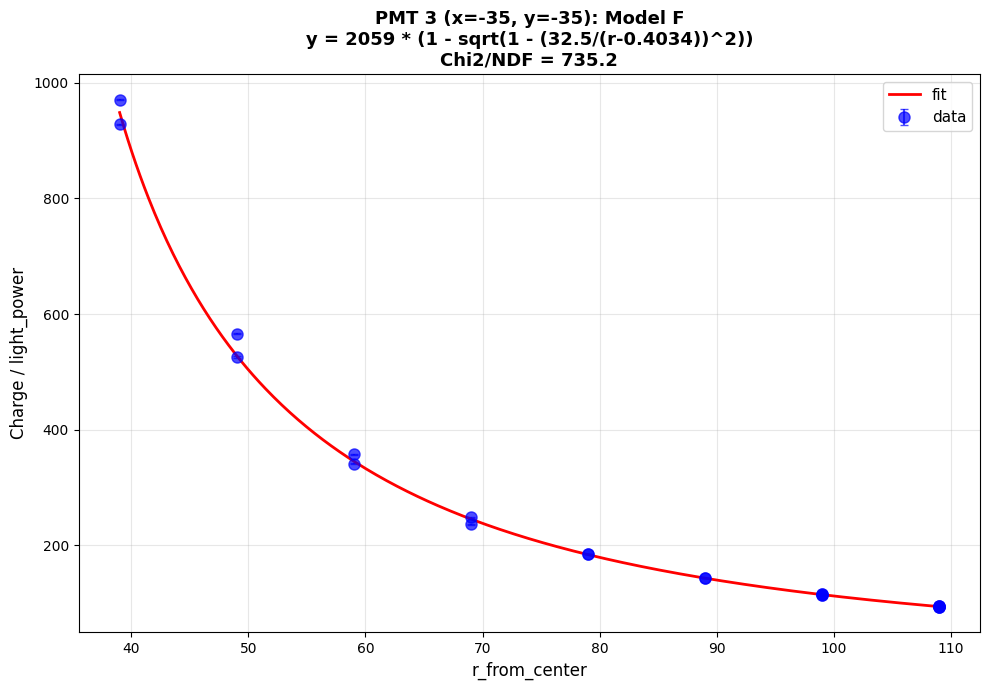

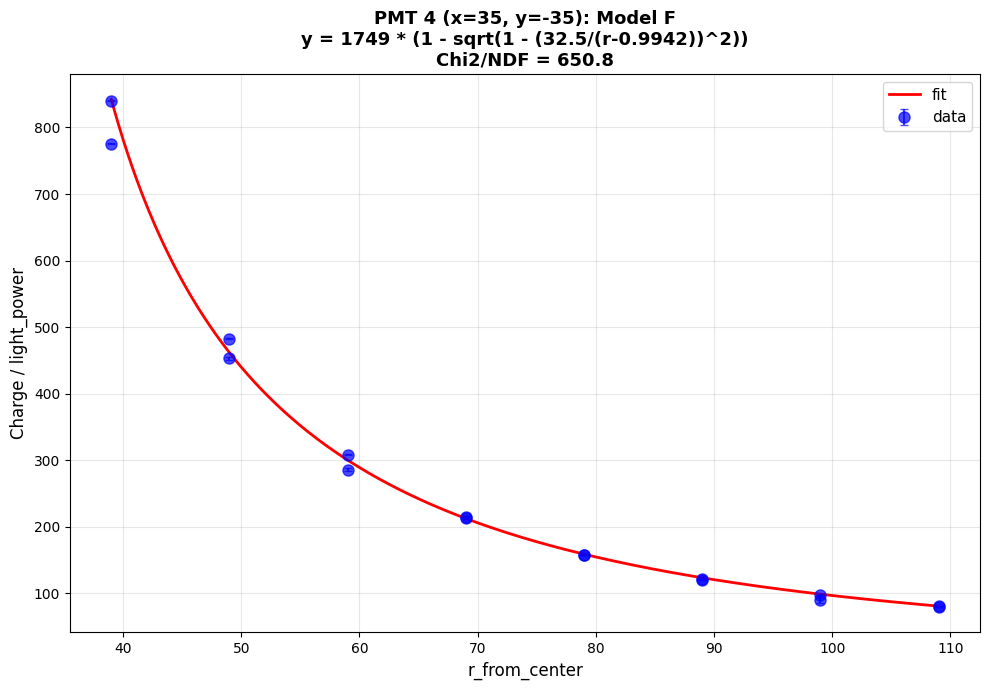


Model F: 4枚まとめたグラフ作成中...


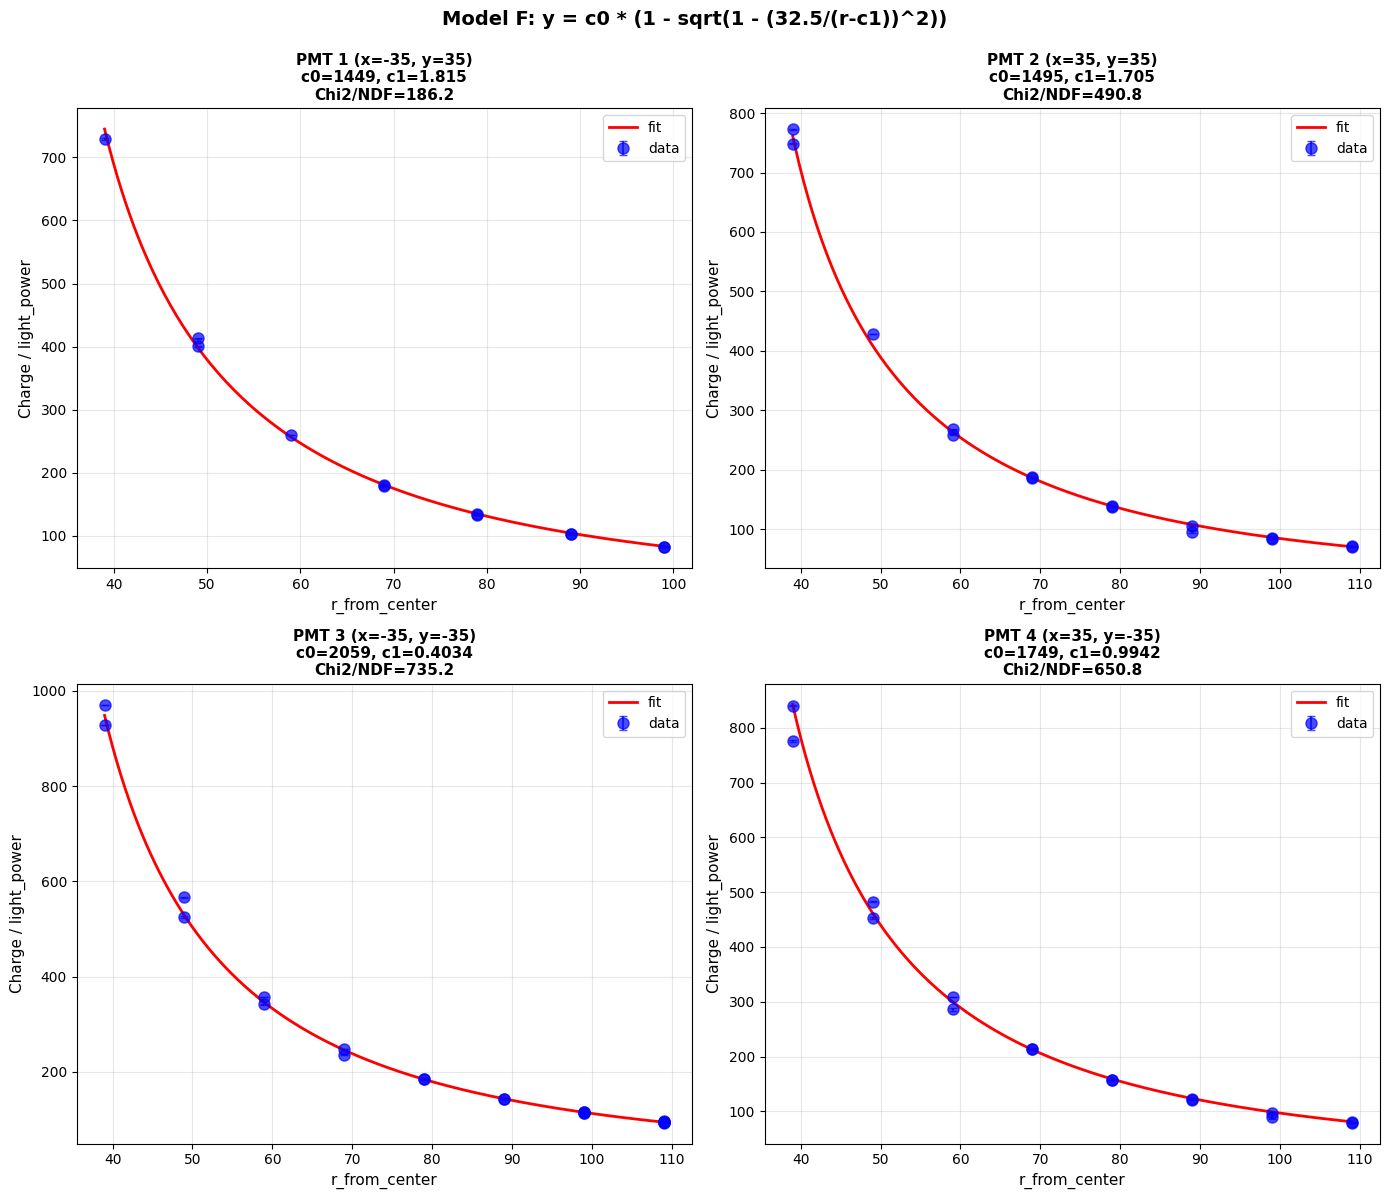


MODEL F フィット結果テーブル
 PMT        (x,y)   N           c0           c1         Chi2   NDF   Chi2/NDF   Status
------------------------------------------------------------------------------------------------------------------------
   1     (-35,35)  12      1448.87      1.81509         1862    10      186.2       OK
   2      (35,35)  15      1494.61      1.70516         6381    13      490.8       OK
   3    (-35,-35)  22      2058.68     0.403405     1.47e+04    20      735.2       OK
   4     (35,-35)  16      1748.84     0.994191         9112    14      650.8       OK

PMTごとの距離依存関数 f_i(r) の定義
Model: f_i(r) = c0_i * (1 - sqrt(1 - (32.5/(r-c1_i))^2))

PMT 1:
  f_1(r) = 1448.873453 * (1 - sqrt(1 - (32.5/(r-1.815088))^2))

PMT 2:
  f_2(r) = 1494.608353 * (1 - sqrt(1 - (32.5/(r-1.705164))^2))

PMT 3:
  f_3(r) = 2058.679254 * (1 - sqrt(1 - (32.5/(r-0.403405))^2))

PMT 4:
  f_4(r) = 1748.837583 * (1 - sqrt(1 - (32.5/(r-0.994191))^2))

動作確認: r=50, 100 での各関数の値

r = 50:
  f_1(50) = 379.1868
  f

In [ ]:
# Model F の詳細出力と関数実装
# Model F: y = c0 * (1 - sqrt(1 - (32.5/(r-c1))^2))
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# PMT設定
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

# モデル定義
a_const = 32.5

def model_f(r, c0, c1):
    """Model F: y = c0 * (1 - sqrt(1 - (32.5/(r-c1))^2))"""
    return c0 * (1.0 - np.sqrt(1.0 - (a_const / (r - c1)) ** 2))

# ============================================================================
# Model F の2回フィット実行
# ============================================================================
print("="*100)
print("MODEL F: y = c0 * (1 - sqrt(1 - (32.5/(r-c1))^2))")
print("初期値: c0=2000.0, c1=0.0")
print("="*100)

results_model_f = []
plot_data_f = []

for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\n{'='*70}")
    print(f"PMT {pmt_num} (x={x_coord}, y={y_coord})")
    print('='*70)
    
    # フィルタリング
    filtered = df[(df['#PMT_num'] == pmt_num) & 
                  (df['x'] == x_coord) & 
                  (df['y'] == y_coord)].copy()
    
    filtered['charge_per_power'] = filtered['Charge(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    filtered['charge_per_power_err'] = filtered['Charge_err(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    filtered = filtered[filtered['charge_per_power'] >= 20]
    
    print(f"After filter (charge_per_power >= 20): {len(filtered)} points")
    
    # 配列準備
    x = filtered['r_from_center'].to_numpy(dtype=float)
    y = filtered['charge_per_power'].to_numpy(dtype=float)
    y_err = filtered['charge_per_power_err'].to_numpy(dtype=float)
    
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (y_err > 0)
    x = x[mask]
    y = y[mask]
    y_err = y_err[mask]
    
    if len(x) < 3:
        print("  Warning: Not enough data points")
        results_model_f.append({
            'pmt': pmt_num,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'c0': None,
            'c1': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': len(x)
        })
        plot_data_f.append({
            'pmt': pmt_num,
            'x': np.array([]),
            'y': np.array([]),
            'y_err': np.array([]),
            'x_fit': np.array([]),
            'y_fit': np.array([])
        })
        continue
    
    # 1回目のフィット
    try:
        popt1, _ = curve_fit(model_f, x, y, p0=[2000.0, 0.0], 
                            sigma=y_err, absolute_sigma=True, maxfev=20000)
        c0_1, c1_1 = popt1[0], popt1[1]
        
        y_fit1 = model_f(x, c0_1, c1_1)
        residuals1 = (y - y_fit1) / y_err
        chi2_1 = np.sum(residuals1**2)
        ndf1 = len(x) - 2
        chi2_ndf_1 = chi2_1 / ndf1 if ndf1 > 0 else float('inf')
        
        print(f"  1回目: c0={c0_1:.6g}, c1={c1_1:.6g}, Chi2/NDF={chi2_ndf_1:.4g}")
        
        # 2回目のフィット（1回目の結果を初期値として使用）
        popt2, pcov = curve_fit(model_f, x, y, p0=popt1, 
                               sigma=y_err, absolute_sigma=True, maxfev=20000)
        c0_2, c1_2 = popt2[0], popt2[1]
        
        y_fit2 = model_f(x, c0_2, c1_2)
        residuals2 = (y - y_fit2) / y_err
        chi2_2 = np.sum(residuals2**2)
        ndf2 = len(x) - 2
        chi2_ndf_2 = chi2_2 / ndf2 if ndf2 > 0 else float('inf')
        
        print(f"  2回目: c0={c0_2:.6g}, c1={c1_2:.6g}, Chi2/NDF={chi2_ndf_2:.4g}")
        
        # 結果保存
        results_model_f.append({
            'pmt': pmt_num,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'c0': c0_2,
            'c1': c1_2,
            'chi2': chi2_2,
            'ndf': ndf2,
            'chi2_ndf': chi2_ndf_2,
            'success': True,
            'n_points': len(x)
        })
        
        # プロット用データ保存
        x_min, x_max = float(np.min(x)), float(np.max(x))
        x_fit = np.linspace(x_min, x_max, 400)
        y_fit_plot = model_f(x_fit, c0_2, c1_2)
        
        plot_data_f.append({
            'pmt': pmt_num,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'x': x,
            'y': y,
            'y_err': y_err,
            'x_fit': x_fit,
            'y_fit': y_fit_plot
        })
        
    except Exception as e:
        print(f"  Fit failed: {e}")
        results_model_f.append({
            'pmt': pmt_num,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'c0': None,
            'c1': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': len(x)
        })
        plot_data_f.append({
            'pmt': pmt_num,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'x': np.array([]),
            'y': np.array([]),
            'y_err': np.array([]),
            'x_fit': np.array([]),
            'y_fit': np.array([])
        })

# ============================================================================
# 個別グラフ（4枚）
# ============================================================================
print("\n" + "="*100)
print("Model F: 個別グラフ作成中...")
print("="*100)

for data in plot_data_f:
    pmt_num = data['pmt']
    x_coord = data['x_coord']
    y_coord = data['y_coord']
    
    if len(data['x']) > 0:
        fig, ax = plt.subplots(figsize=(10, 7))
        
        ax.errorbar(data['x'], data['y'], yerr=data['y_err'], fmt='o', alpha=0.7, 
                   capsize=3, markersize=8, label='data', color='blue')
        ax.plot(data['x_fit'], data['y_fit'], color='red', linewidth=2, label='fit')
        ax.set_xlabel('r_from_center', fontsize=12)
        ax.set_ylabel('Charge / light_power', fontsize=12)
        
        res = results_model_f[pmt_num - 1]
        if res['success']:
            ax.set_title(f"PMT {pmt_num} (x={x_coord}, y={y_coord}): Model F\n"
                        f"y = {res['c0']:.4g} * (1 - sqrt(1 - (32.5/(r-{res['c1']:.4g}))^2))\n"
                        f"Chi2/NDF = {res['chi2_ndf']:.4g}", 
                        fontsize=13, fontweight='bold')
        else:
            ax.set_title(f"PMT {pmt_num} (x={x_coord}, y={y_coord}): Fit Failed", 
                        fontsize=13, fontweight='bold')
        
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=11)
        plt.tight_layout()
        plt.show()

# ============================================================================
# 4枚まとめたグラフ（2x2グリッド）
# ============================================================================
print("\n" + "="*100)
print("Model F: 4枚まとめたグラフ作成中...")
print("="*100)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, data in enumerate(plot_data_f):
    ax = axes[idx]
    pmt_num = data['pmt']
    x_coord = data['x_coord']
    y_coord = data['y_coord']
    
    if len(data['x']) > 0:
        ax.errorbar(data['x'], data['y'], yerr=data['y_err'], fmt='o', alpha=0.7, 
                   capsize=3, markersize=8, label='data', color='blue')
        ax.plot(data['x_fit'], data['y_fit'], color='red', linewidth=2, label='fit')
        ax.set_xlabel('r_from_center', fontsize=11)
        ax.set_ylabel('Charge / light_power', fontsize=11)
        
        res = results_model_f[idx]
        if res['success']:
            ax.set_title(f"PMT {pmt_num} (x={x_coord}, y={y_coord})\n"
                        f"c0={res['c0']:.4g}, c1={res['c1']:.4g}\n"
                        f"Chi2/NDF={res['chi2_ndf']:.4g}", 
                        fontsize=11, fontweight='bold')
        else:
            ax.set_title(f"PMT {pmt_num}: Fit Failed", fontsize=11, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f'PMT {pmt_num}\nNo Data', ha='center', va='center', 
               fontsize=12, transform=ax.transAxes)
    
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

plt.suptitle('Model F: y = c0 * (1 - sqrt(1 - (32.5/(r-c1))^2))', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# フィット結果の表
# ============================================================================
print("\n" + "="*120)
print("MODEL F フィット結果テーブル")
print("="*120)
print(f"{'PMT':>4} {'(x,y)':>12} {'N':>3} {'c0':>12} {'c1':>12} {'Chi2':>12} {'NDF':>5} {'Chi2/NDF':>10} {'Status':>8}")
print("-"*120)
for res in results_model_f:
    if res['success']:
        coord = f"({res['x_coord']},{res['y_coord']})"
        print(f"{res['pmt']:>4} {coord:>12} {res['n_points']:>3} {res['c0']:>12.6g} {res['c1']:>12.6g} {res['chi2']:>12.4g} {res['ndf']:>5} {res['chi2_ndf']:>10.4g} {'OK':>8}")
    else:
        coord = f"({res.get('x_coord','?')},{res.get('y_coord','?')})"
        print(f"{res['pmt']:>4} {coord:>12} {res['n_points']:>3} {'N/A':>12} {'N/A':>12} {'N/A':>12} {'N/A':>5} {'N/A':>10} {'FAILED':>8}")
print("="*120)

# ============================================================================
# PMTごとの関数 f_i(r) を定義
# ============================================================================
print("\n" + "="*100)
print("PMTごとの距離依存関数 f_i(r) の定義")
print("="*100)

# フィット結果から各PMTの係数を抽出
pmt_params_f = {}
for res in results_model_f:
    if res['success']:
        pmt_params_f[res['pmt']] = {
            'c0': res['c0'],
            'c1': res['c1']
        }

# PMTごとの関数を定義
def f_1(r):
    """PMT 1の距離依存関数（Model F）"""
    c0 = pmt_params_f[1]['c0']
    c1 = pmt_params_f[1]['c1']
    return c0 * (1.0 - np.sqrt(1.0 - (a_const / (r - c1)) ** 2))

def f_2(r):
    """PMT 2の距離依存関数（Model F）"""
    c0 = pmt_params_f[2]['c0']
    c1 = pmt_params_f[2]['c1']
    return c0 * (1.0 - np.sqrt(1.0 - (a_const / (r - c1)) ** 2))

def f_3(r):
    """PMT 3の距離依存関数（Model F）"""
    c0 = pmt_params_f[3]['c0']
    c1 = pmt_params_f[3]['c1']
    return c0 * (1.0 - np.sqrt(1.0 - (a_const / (r - c1)) ** 2))

def f_4(r):
    """PMT 4の距離依存関数（Model F）"""
    c0 = pmt_params_f[4]['c0']
    c1 = pmt_params_f[4]['c1']
    return c0 * (1.0 - np.sqrt(1.0 - (a_const / (r - c1)) ** 2))

# 辞書形式でまとめる
f_funcs = {
    1: f_1,
    2: f_2,
    3: f_3,
    4: f_4
}

# 関数の表示
print("Model: f_i(r) = c0_i * (1 - sqrt(1 - (32.5/(r-c1_i))^2))")
print()
for pmt, params in pmt_params_f.items():
    print(f"PMT {pmt}:")
    print(f"  f_{pmt}(r) = {params['c0']:.6f} * (1 - sqrt(1 - (32.5/(r-{params['c1']:.6f}))^2))")
    print()

# テスト: 各関数の動作確認
print("="*100)
print("動作確認: r=50, 100 での各関数の値")
print("="*100)
test_r_values = [50, 100]
for r_test in test_r_values:
    print(f"\nr = {r_test}:")
    for pmt in [1, 2, 3, 4]:
        val = f_funcs[pmt](r_test)
        print(f"  f_{pmt}({r_test}) = {val:.4f}")
print("="*100)


Processing PMT 1 (x=-35, y=35)
Raw rows: 16
After threshold (>=20): 12
After r >= 32.5 filter: 12
Weighted fit succeeded: c0=-9.366, c1=1636
Chi2=1588, NDF=10, Chi2/NDF=158.8


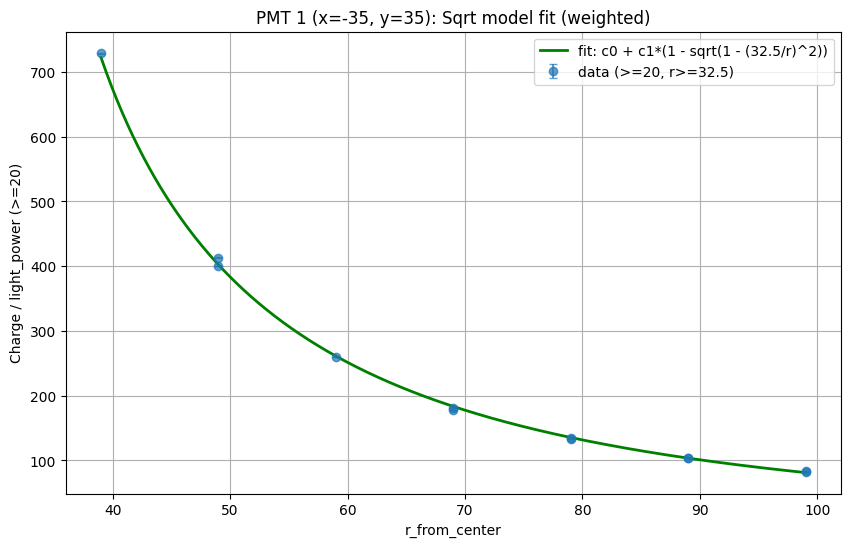


Processing PMT 2 (x=35, y=35)
Raw rows: 16
After threshold (>=20): 15
After r >= 32.5 filter: 15
Weighted fit succeeded: c0=-9.419, c1=1692
Chi2=1.006e+04, NDF=13, Chi2/NDF=773.8


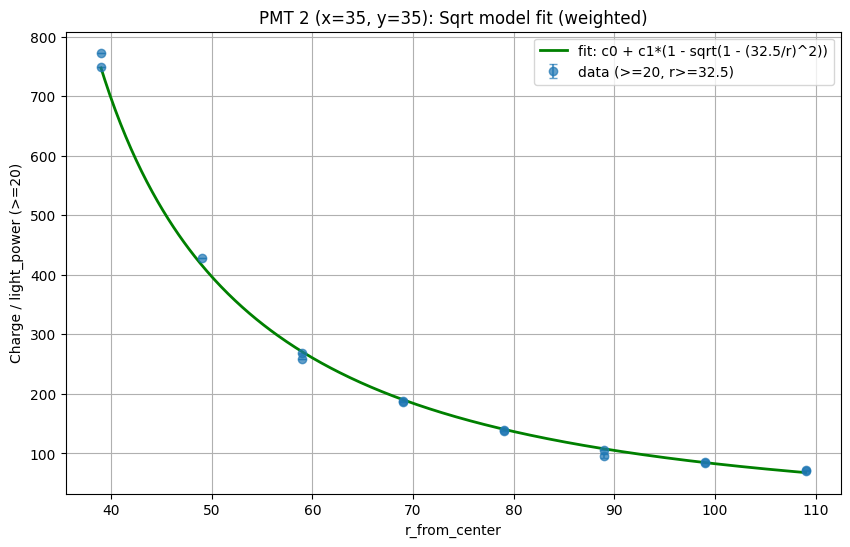


Processing PMT 3 (x=-35, y=-35)
Raw rows: 22
After threshold (>=20): 22
After r >= 32.5 filter: 22
Weighted fit succeeded: c0=-2.47, c1=2117
Chi2=1.473e+04, NDF=20, Chi2/NDF=736.7


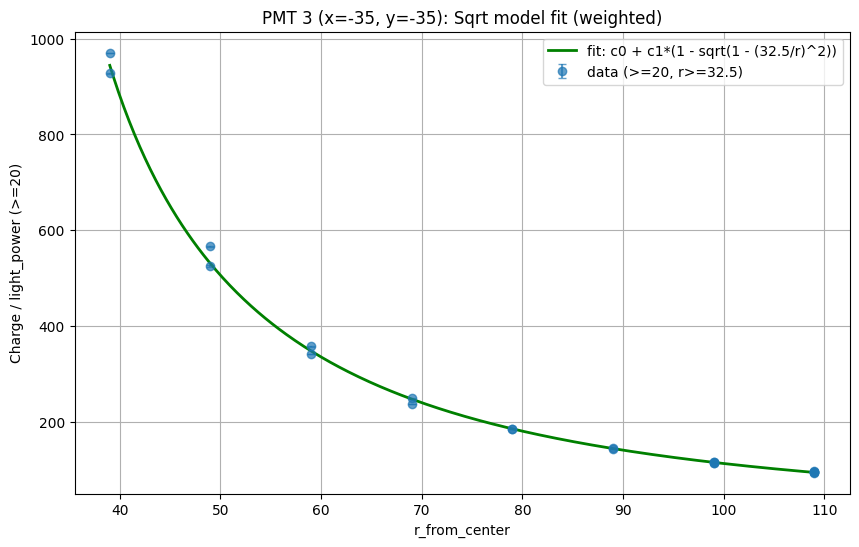


Processing PMT 4 (x=35, y=-35)
Raw rows: 16
After threshold (>=20): 16
After r >= 32.5 filter: 16
Weighted fit succeeded: c0=-7.485, c1=1890
Chi2=6243, NDF=14, Chi2/NDF=445.9


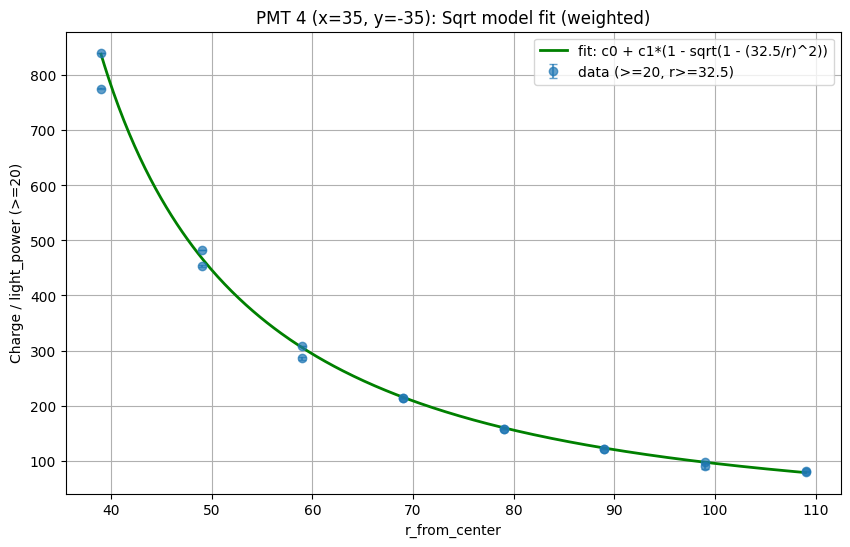

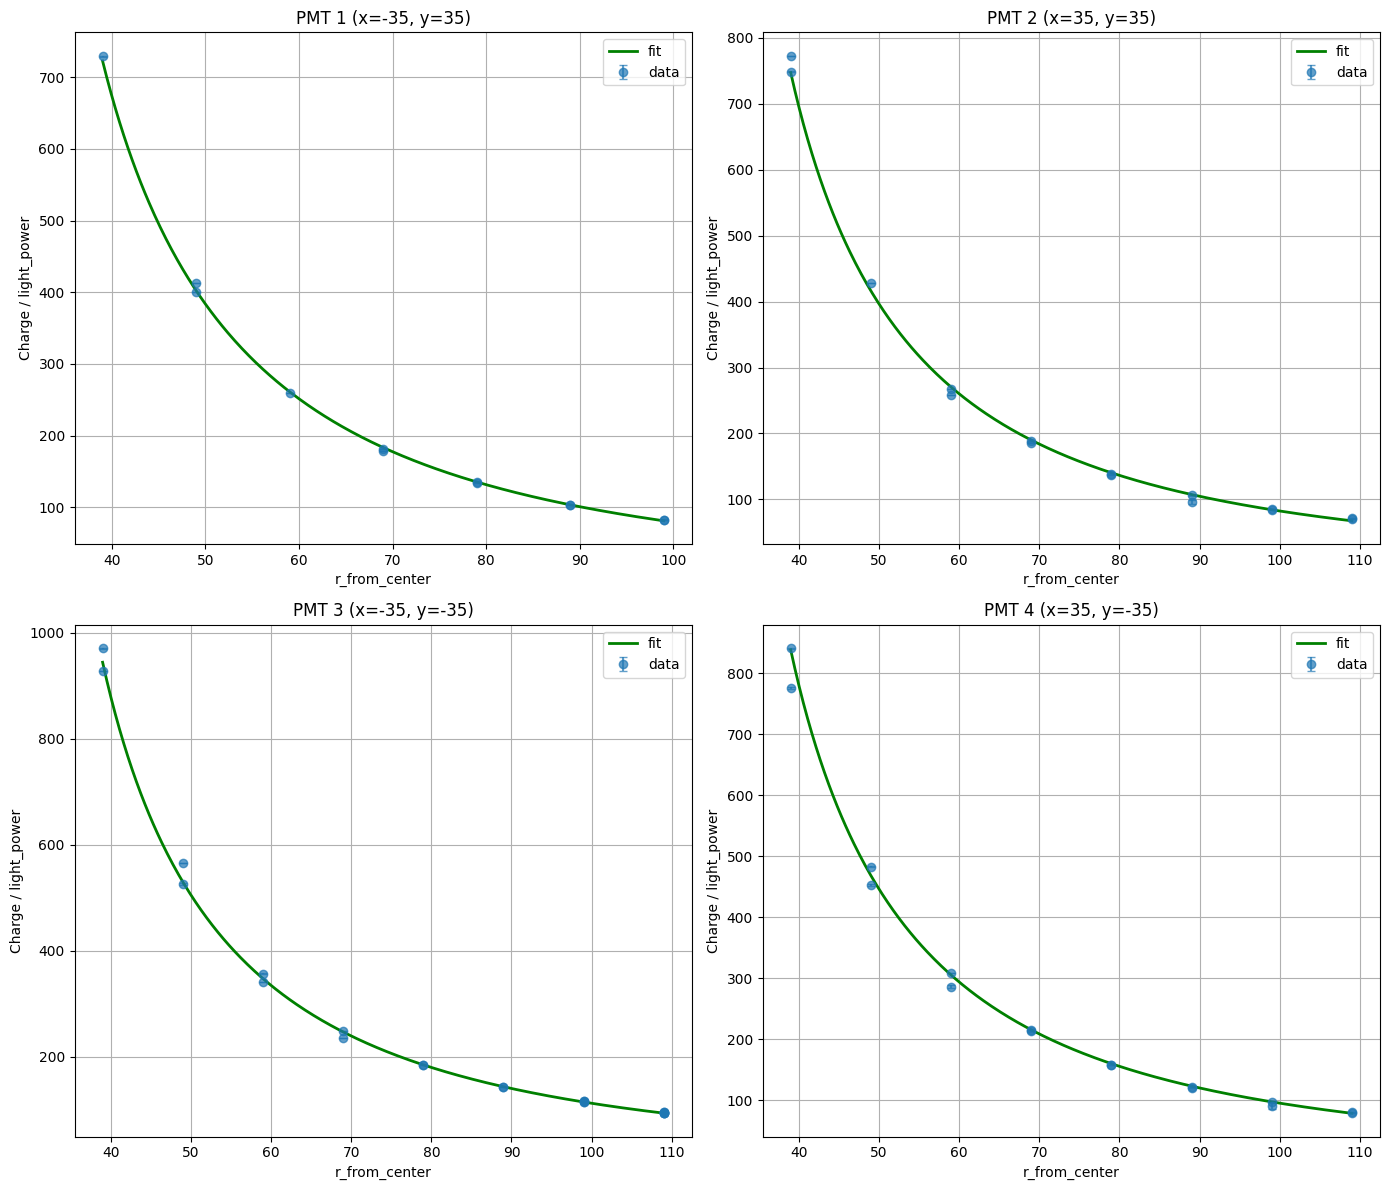


FITTING RESULTS SUMMARY (Sqrt Model with Weighted Fit)
 PMT        (x,y)  N_pts           c0           c1         Chi2   NDF   Chi2/NDF   Status
------------------------------------------------------------------------------------------
   1     (-35,35)     12       -9.366         1636         1588    10      158.8       OK
   2      (35,35)     15       -9.419         1692    1.006e+04    13      773.8       OK
   3    (-35,-35)     22        -2.47         2117    1.473e+04    20      736.7       OK
   4     (35,-35)     16       -7.485         1890         6243    14      445.9       OK


In [ ]:
# PMT 1~4 の処理: フィルタ・フィット・プロット (sqrt model with error bars)
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# PMT設定: (PMT番号, x座標, y座標)
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

# モデル定義: y = c0 + c1 * (1 - sqrt(1 - (32.5/r)^2))
a_const = 32.5

def sqrt_model(r, c0, c1):
    return c0 + c1 * (1.0 - np.sqrt(1.0 - (a_const / r) ** 2))

# 初期値
c0_init = 0.0
c1_init = 1600.0

# 結果格納用
results = []
plot_data = []

# 各PMTについて処理
for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\n{'='*60}")
    print(f"Processing PMT {pmt_num} (x={x_coord}, y={y_coord})")
    print('='*60)
    
    # フィルタリング
    filtered = df[(df['#PMT_num'] == pmt_num) & 
                  (df['x'] == x_coord) & 
                  (df['y'] == y_coord)].copy()
    print(f"Raw rows: {len(filtered)}")
    
    # charge/light_power計算と閾値適用
    filtered['charge_per_power'] = filtered['Charge(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    
    # エラー伝播: err(Q/A) = |Q/A| * sqrt((err_Q/Q)^2 + (err_A/A)^2)
    # ここではlight_powerのエラーがないので、err(Q/A) ≈ err_Q / A
    filtered['charge_per_power_err'] = filtered['Charge_err(pC)'] / filtered['light_power(def:(15dB, 5V)=1)']
    
    filtered = filtered[filtered['charge_per_power'] >= 20]
    print(f"After threshold (>=20): {len(filtered)}")
    
    # 配列準備 (r >= 32.5 の条件を追加)
    x = filtered['r_from_center'].to_numpy(dtype=float)
    y = filtered['charge_per_power'].to_numpy(dtype=float)
    y_err = filtered['charge_per_power_err'].to_numpy(dtype=float)
    
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(y_err) & (x >= a_const) & (y_err > 0)
    x = x[mask]
    y = y[mask]
    y_err = y_err[mask]
    
    print(f"After r >= {a_const} filter: {len(x)}")
    
    if len(x) == 0:
        print(f"Warning: No valid data for PMT {pmt_num}")
        results.append({
            'pmt': pmt_num,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'c0': None,
            'c1': None,
            'chi2': None,
            'ndf': None,
            'chi2_ndf': None,
            'success': False,
            'n_points': 0
        })
        continue
    
    # Weighted フィット (sigma = y_err)
    try:
        popt, pcov = curve_fit(sqrt_model, x, y, p0=[c0_init, c1_init], 
                               sigma=y_err, absolute_sigma=True, maxfev=20000)
        c0, c1 = popt
        
        # chi2計算 (weighted)
        y_fit_vals = sqrt_model(x, c0, c1)
        residuals = (y - y_fit_vals) / y_err
        chi2 = np.sum(residuals**2)
        ndf = len(x) - 2  # データ点数 - パラメータ数
        chi2_ndf = chi2 / ndf if ndf > 0 else float('inf')
        
        success = True
        print(f"Weighted fit succeeded: c0={c0:.4g}, c1={c1:.4g}")
        print(f"Chi2={chi2:.4g}, NDF={ndf}, Chi2/NDF={chi2_ndf:.4g}")
    except Exception as e:
        print(f"Fit failed: {e}")
        c0, c1 = c0_init, c1_init
        chi2, ndf, chi2_ndf = None, None, None
        success = False
    
    # 結果保存
    results.append({
        'pmt': pmt_num,
        'x_coord': x_coord,
        'y_coord': y_coord,
        'c0': c0,
        'c1': c1,
        'chi2': chi2,
        'ndf': ndf,
        'chi2_ndf': chi2_ndf,
        'success': success,
        'n_points': len(x)
    })
    
    # プロット用データ保存
    x_min, x_max = float(np.min(x)), float(np.max(x))
    x_fit = np.linspace(max(a_const, x_min), x_max, 400)
    y_fit = sqrt_model(x_fit, c0, c1)
    
    plot_data.append({
        'pmt': pmt_num,
        'x': x,
        'y': y,
        'y_err': y_err,
        'x_fit': x_fit,
        'y_fit': y_fit,
        'x_coord': x_coord,
        'y_coord': y_coord
    })
    
    # 個別プロット (エラーバー付き)
    plt.figure(figsize=(10, 6))
    plt.errorbar(x, y, yerr=y_err, fmt='o', alpha=0.7, capsize=3, label='data (>=20, r>=32.5)')
    plt.plot(x_fit, y_fit, color='green', linewidth=2, label='fit: c0 + c1*(1 - sqrt(1 - (32.5/r)^2))')
    plt.xlabel('r_from_center')
    plt.ylabel('Charge / light_power (>=20)')
    plt.title(f'PMT {pmt_num} (x={x_coord}, y={y_coord}): Sqrt model fit (weighted)')
    plt.grid(True)
    plt.legend()
    plt.show()

# 2x2 サブプロット (エラーバー付き)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, data in enumerate(plot_data):
    ax = axes[idx]
    ax.errorbar(data['x'], data['y'], yerr=data['y_err'], fmt='o', alpha=0.7, capsize=3, label='data')
    ax.plot(data['x_fit'], data['y_fit'], color='green', linewidth=2, label='fit')
    ax.set_xlabel('r_from_center')
    ax.set_ylabel('Charge / light_power')
    ax.set_title(f"PMT {data['pmt']} (x={data['x_coord']}, y={data['y_coord']})")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

# フィット結果まとめ表示
print("\n" + "="*90)
print("FITTING RESULTS SUMMARY (Sqrt Model with Weighted Fit)")
print("="*90)
print(f"{'PMT':>4} {'(x,y)':>12} {'N_pts':>6} {'c0':>12} {'c1':>12} {'Chi2':>12} {'NDF':>5} {'Chi2/NDF':>10} {'Status':>8}")
print("-"*90)
for res in results:
    if res['success']:
        status = "OK"
        c0_str = f"{res['c0']:.4g}"
        c1_str = f"{res['c1']:.4g}"
        chi2_str = f"{res['chi2']:.4g}"
        ndf_str = f"{res['ndf']}"
        chi2ndf_str = f"{res['chi2_ndf']:.4g}"
        n_pts = res['n_points']
        coord = f"({res['x_coord']},{res['y_coord']})"
    else:
        status = "FAILED"
        c0_str = "N/A"
        c1_str = "N/A"
        chi2_str = "N/A"
        ndf_str = "N/A"
        chi2ndf_str = "N/A"
        n_pts = res.get('n_points', 0)
        coord = f"({res.get('x_coord','?')},{res.get('y_coord','?')})"
    
    print(f"{res['pmt']:>4} {coord:>12} {n_pts:>6} {c0_str:>12} {c1_str:>12} {chi2_str:>12} {ndf_str:>5} {chi2ndf_str:>10} {status:>8}")
print("="*90)

Charge/(light_power*f_i(r)) vs cos(alpha_from_center) のグラフ作成
フィルタ: Charge/(light_power*f_i(r)) <= 50 のみ (rカットなし)

PMT 1 (x=-35, y=35)
Total data points for PMT 1: 267
  Valid data points (y <= 50): 266
  Excluded points (y > 50): 1
  Invalid/NaN points: 0


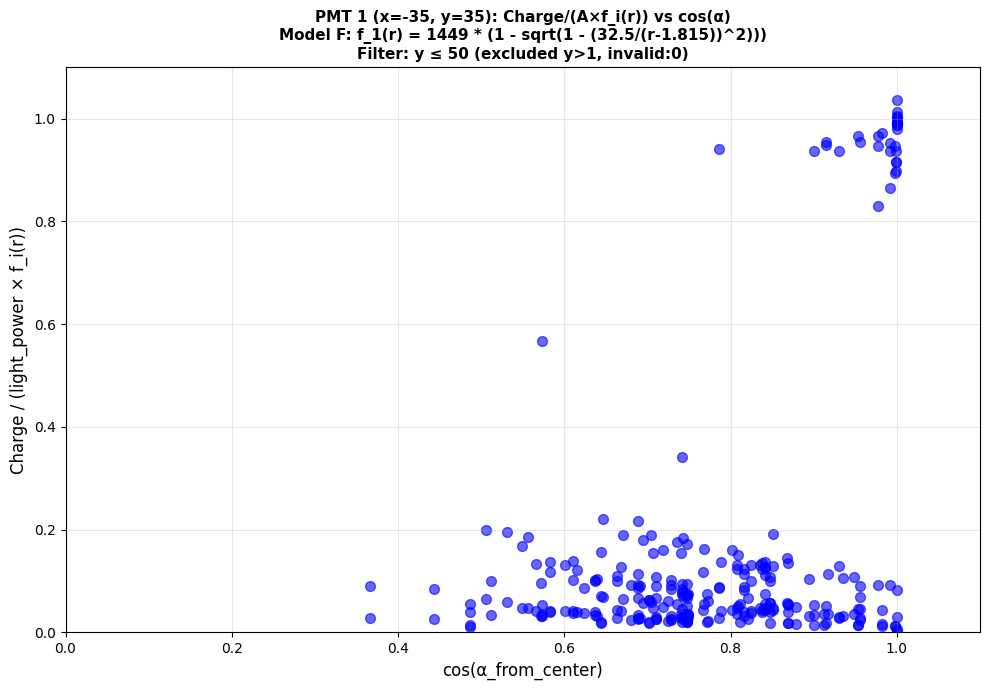

  y-axis range: [0.0028, 1.0366]
  x-axis range: [0.3665, 1.0000]
  r-axis range: [39.0000, 176.4115]

PMT 2 (x=35, y=35)
Total data points for PMT 2: 267
  Valid data points (y <= 50): 266
  Excluded points (y > 50): 1
  Invalid/NaN points: 0


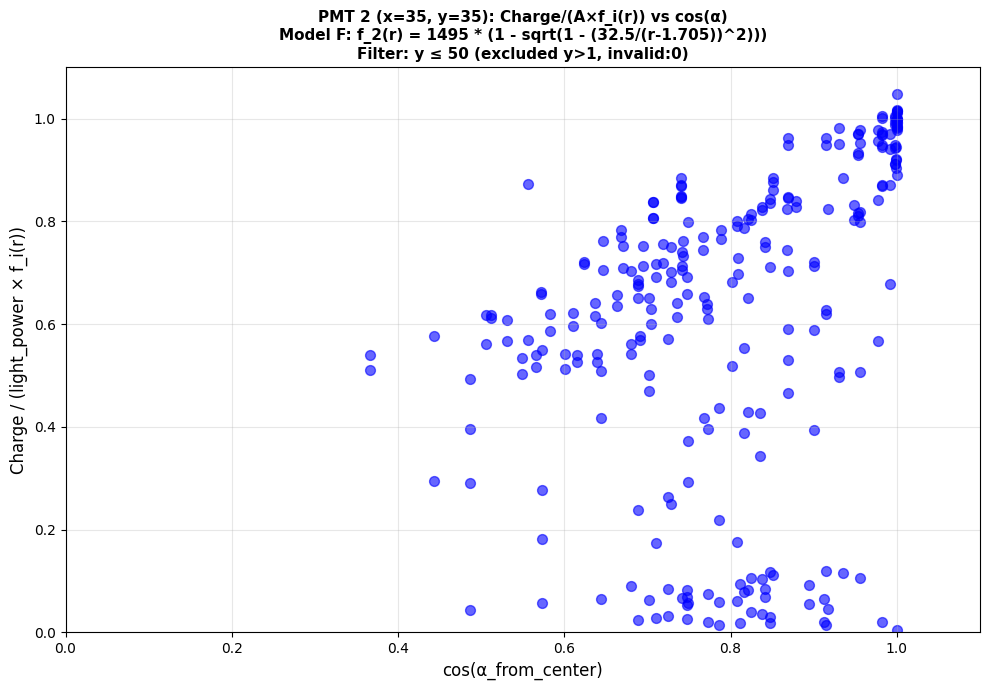

  y-axis range: [0.0050, 1.0478]
  x-axis range: [0.3665, 1.0000]
  r-axis range: [39.0000, 176.4115]

PMT 3 (x=-35, y=-35)
Total data points for PMT 3: 267
  Valid data points (y <= 50): 266
  Excluded points (y > 50): 1
  Invalid/NaN points: 0


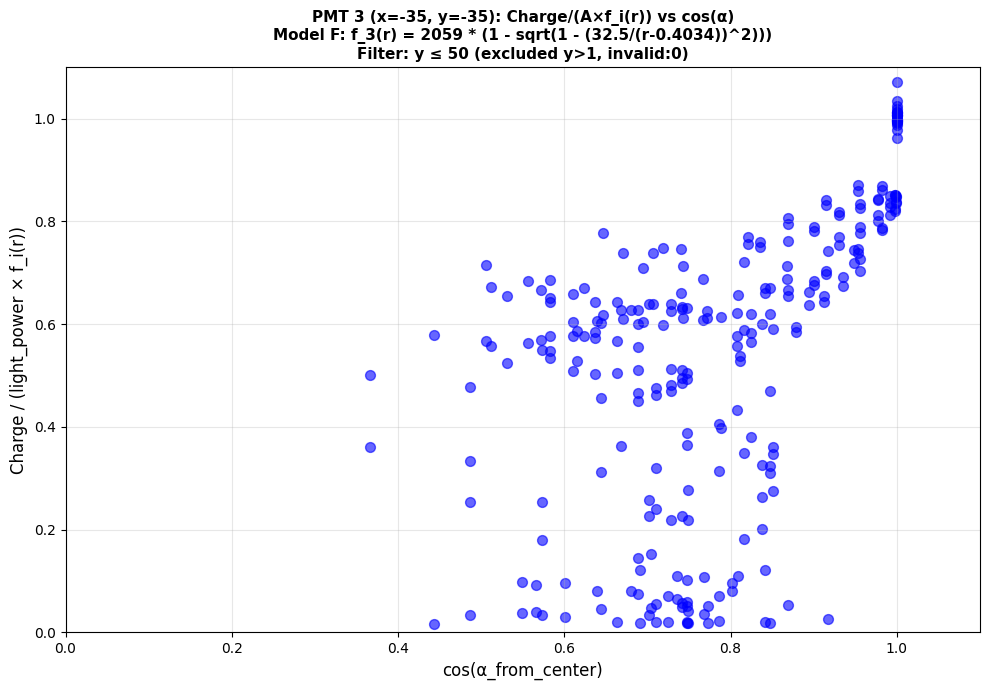

  y-axis range: [0.0169, 1.0718]
  x-axis range: [0.3665, 1.0000]
  r-axis range: [39.0000, 176.4115]

PMT 4 (x=35, y=-35)
Total data points for PMT 4: 267
  Valid data points (y <= 50): 266
  Excluded points (y > 50): 1
  Invalid/NaN points: 0


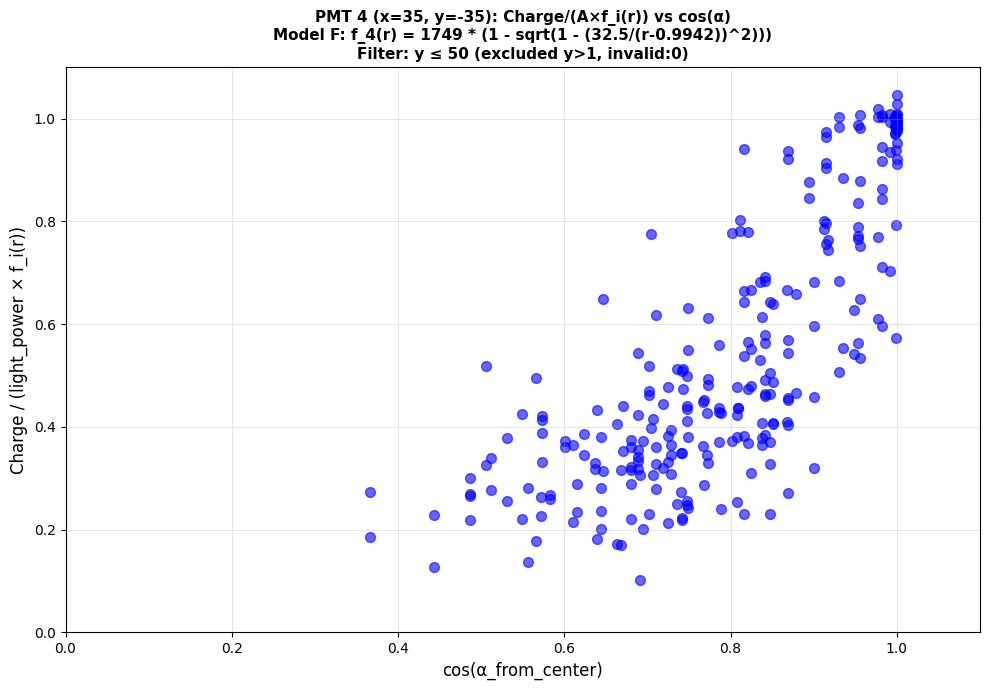

  y-axis range: [0.1013, 1.0456]
  x-axis range: [0.3665, 1.0000]
  r-axis range: [39.0000, 176.4115]

全てのグラフ作成完了


In [ ]:
# 各PMTについて Charge/(light_power*f_i(r)) vs cos(alpha_from_center) をプロット
# 条件: y = Charge/(light_power*f_i(r)) が 50 以下のみ使用
import numpy as np
import matplotlib.pyplot as plt

# PMT設定
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

print("="*100)
print("Charge/(light_power*f_i(r)) vs cos(alpha_from_center) のグラフ作成")
print("フィルタ: Charge/(light_power*f_i(r)) <= 50 のみ (rカットなし)")
print("="*100)

# 各PMTについて処理
for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\n{'='*70}")
    print(f"PMT {pmt_num} (x={x_coord}, y={y_coord})")
    print('='*70)
    
    # このPMTの全データを抽出
    pmt_data = df[df['#PMT_num'] == pmt_num].copy()
    
    print(f"Total data points for PMT {pmt_num}: {len(pmt_data)}")
    
    # 必要な列の確認
    if 'cos(alpha_from_center)' not in pmt_data.columns:
        print("  Error: 'cos(alpha_from_center)' column not found")
        continue
    
    # r_from_center と f_i(r) を計算
    r_vals = pmt_data['r_from_center'].to_numpy(dtype=float)
    try:
        f_r_vals = f_funcs[pmt_num](r_vals)
    except Exception as e:
        print(f"  Error computing f_{pmt_num}(r): {e}")
        continue
    
    # Charge, light_power, cos(alpha_from_center) を取得
    charge_vals = pmt_data['Charge(pC)'].to_numpy(dtype=float)
    light_power_vals = pmt_data['light_power(def:(15dB, 5V)=1)'].to_numpy(dtype=float)
    cos_alpha_vals = pmt_data['cos(alpha_from_center)'].to_numpy(dtype=float)
    
    # y軸: Charge/(light_power*f_i(r))
    y_vals = charge_vals / (light_power_vals * f_r_vals)
    
    # フィルタ: 有限値 かつ y <= 50 のみ（rカットなし）
    finite_mask = np.isfinite(y_vals) & np.isfinite(cos_alpha_vals)
    mask = finite_mask & (y_vals <= 50)
    y_vals_filtered = y_vals[mask]
    cos_alpha_filtered = cos_alpha_vals[mask]
    r_vals_filtered = r_vals[mask]
    
    # 除外された点の数
    n_excluded_y = np.sum(finite_mask & (y_vals > 50))
    n_invalid = np.sum(~finite_mask)
    
    print(f"  Valid data points (y <= 50): {len(y_vals_filtered)}")
    print(f"  Excluded points (y > 50): {n_excluded_y}")
    print(f"  Invalid/NaN points: {n_invalid}")
    
    if len(y_vals_filtered) == 0:
        print(f"  Warning: No valid data for PMT {pmt_num}")
        continue
    
    # プロット
    plt.figure(figsize=(10, 7))
    plt.scatter(cos_alpha_filtered, y_vals_filtered, alpha=0.6, s=50, color='blue')
    plt.xlabel('cos(α_from_center)', fontsize=12)
    plt.ylabel('Charge / (light_power × f_i(r))', fontsize=12)
    plt.title(
        f'PMT {pmt_num} (x={x_coord}, y={y_coord}): Charge/(A×f_i(r)) vs cos(α)\n'
        f'Model F: f_{pmt_num}(r) = {pmt_params_f[pmt_num]["c0"]:.4g} * (1 - sqrt(1 - (32.5/(r-{pmt_params_f[pmt_num]["c1"]:.4g}))^2)))\n'
        f'Filter: y ≤ 50 (excluded y>{n_excluded_y}, invalid:{n_invalid})',
        fontsize=11,
        fontweight='bold'
    )
    plt.xlim(0, 1.1)
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"  y-axis range: [{y_vals_filtered.min():.4f}, {y_vals_filtered.max():.4f}]")
    print(f"  x-axis range: [{cos_alpha_filtered.min():.4f}, {cos_alpha_filtered.max():.4f}]")
    print(f"  r-axis range: [{r_vals_filtered.min():.4f}, {r_vals_filtered.max():.4f}]")

print("\n" + "="*100)
print("全てのグラフ作成完了")
print("="*100)

Charge/(light_power*f_i(r)) vs cos(alpha_from_center) のグラフ作成
フィルタ: Charge > 5 かつ Charge/(light_power*f_i(r)) <= 50

PMT 1 (x=-35, y=35)
全データ点数: 267
  有限値データ点数: 267
  Charge > 5 を満たす点数: 34
  フィルタ後 (y <= 50): 34
  除外: Charge <= 5 の点数: 233
  除外: y > 50 の点数: 0
  無効/NaN 点数: 0


/tmp/ipykernel_1205/1521699250.py:93: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/1521699250.py:93: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/1521699250.py:93: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/1521699250.py:93: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/1521699250.py:93: UserWarning: Glyph 12363 (\N{HIRAGANA LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/1521699250.py:93: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/1521699250.py:93: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  plt.t

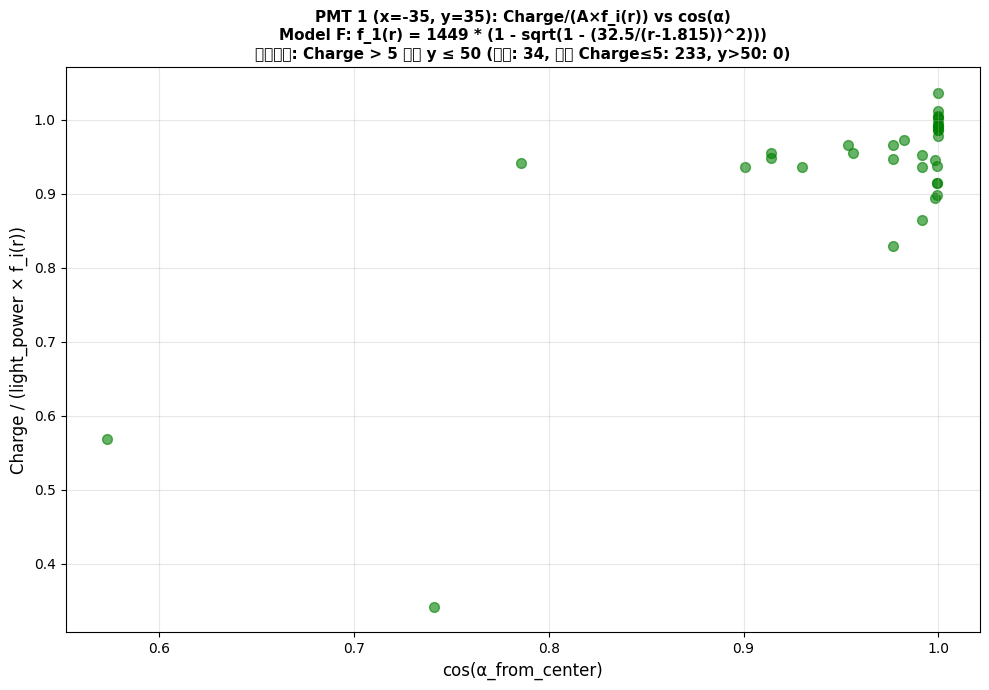

  y軸範囲: [0.3416, 1.0366]
  x軸範囲: [0.5735, 1.0000]
  r軸範囲: [39.0000, 126.5741]
  Charge範囲: [7.7562, 393.0390]

PMT 2 (x=35, y=35)
全データ点数: 267
  有限値データ点数: 267
  Charge > 5 を満たす点数: 217
  フィルタ後 (y <= 50): 217
  除外: Charge <= 5 の点数: 50
  除外: y > 50 の点数: 0
  無効/NaN 点数: 0


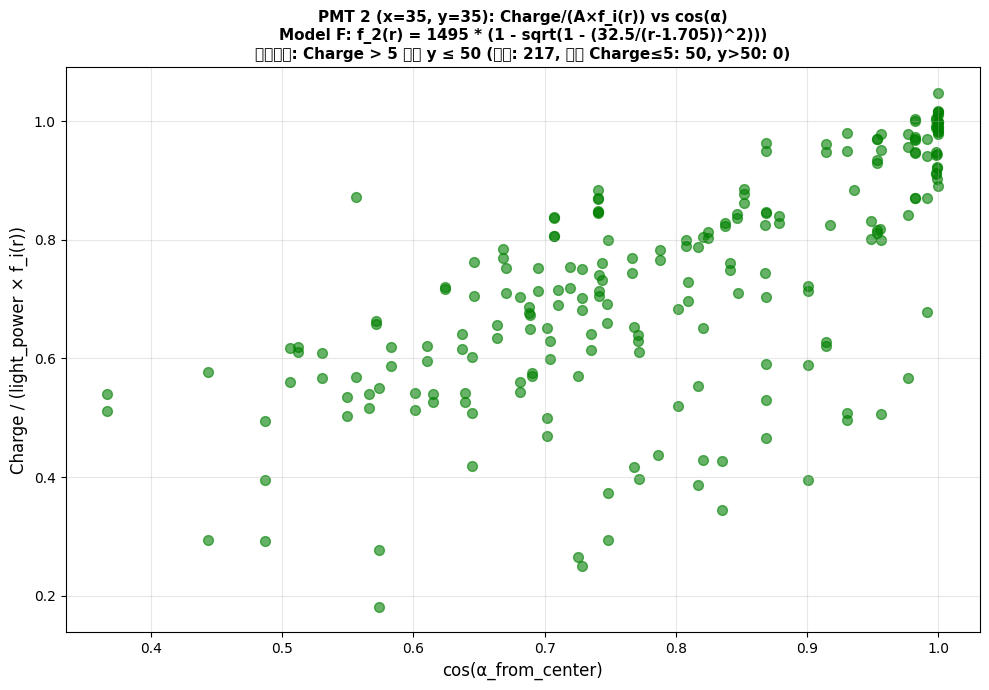

  y軸範囲: [0.1812, 1.0478]
  x軸範囲: [0.3665, 1.0000]
  r軸範囲: [39.0000, 176.4115]
  Charge範囲: [5.5315, 730.7680]

PMT 3 (x=-35, y=-35)
全データ点数: 267
  有限値データ点数: 267
  Charge > 5 を満たす点数: 217
  フィルタ後 (y <= 50): 217
  除外: Charge <= 5 の点数: 50
  除外: y > 50 の点数: 0
  無効/NaN 点数: 0


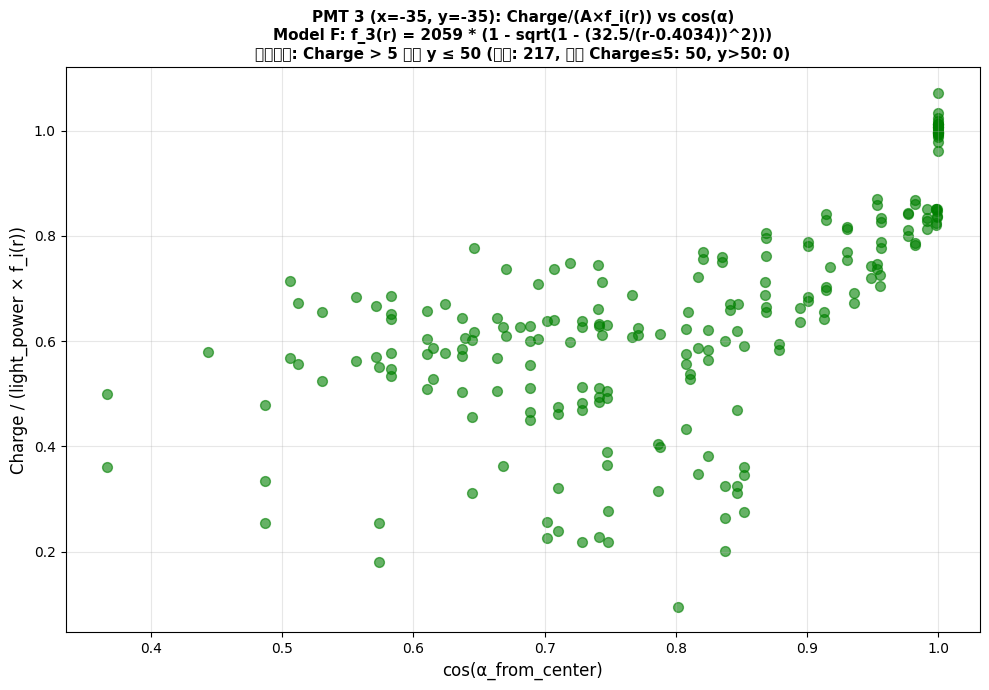

  y軸範囲: [0.0953, 1.0718]
  x軸範囲: [0.3665, 1.0000]
  r軸範囲: [39.0000, 176.4115]
  Charge範囲: [5.1420, 832.0080]

PMT 4 (x=35, y=-35)
全データ点数: 267
  有限値データ点数: 267
  Charge > 5 を満たす点数: 257
  フィルタ後 (y <= 50): 257
  除外: Charge <= 5 の点数: 10
  除外: y > 50 の点数: 0
  無効/NaN 点数: 0


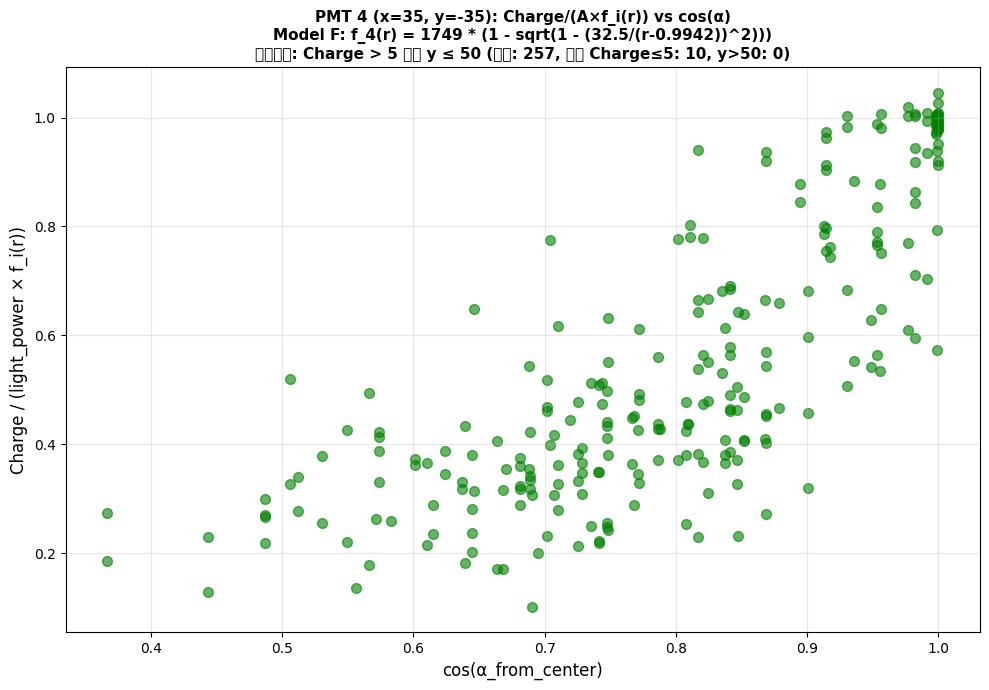

  y軸範囲: [0.1013, 1.0456]
  x軸範囲: [0.3665, 1.0000]
  r軸範囲: [39.0000, 176.4115]
  Charge範囲: [5.1283, 755.6480]

全てのグラフ作成完了


In [ ]:
# 各PMTについて Charge/(light_power*f_i(r)) vs cos(alpha_from_center) をプロット
# 条件: Charge > 5 かつ Charge/(light_power*f_i(r)) <= 50 のみ使用
import numpy as np
import matplotlib.pyplot as plt

# PMT設定
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

print("="*100)
print("Charge/(light_power*f_i(r)) vs cos(alpha_from_center) のグラフ作成")
print("フィルタ: Charge > 5 かつ Charge/(light_power*f_i(r)) <= 50")
print("="*100)

# 各PMTについて処理
for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\n{'='*70}")
    print(f"PMT {pmt_num} (x={x_coord}, y={y_coord})")
    print('='*70)
    
    # このPMTの全データを抽出
    pmt_data = df[df['#PMT_num'] == pmt_num].copy()
    
    print(f"全データ点数: {len(pmt_data)}")
    
    # 必要な列の確認
    if 'cos(alpha_from_center)' not in pmt_data.columns:
        print("  エラー: 'cos(alpha_from_center)' 列が見つかりません")
        continue
    
    # r_from_center と f_i(r) を計算
    r_vals = pmt_data['r_from_center'].to_numpy(dtype=float)
    try:
        f_r_vals = f_funcs[pmt_num](r_vals)
    except Exception as e:
        print(f"  エラー f_{pmt_num}(r) の計算: {e}")
        continue
    
    # Charge, light_power, cos(alpha_from_center) を取得
    charge_vals = pmt_data['Charge(pC)'].to_numpy(dtype=float)
    light_power_vals = pmt_data['light_power(def:(15dB, 5V)=1)'].to_numpy(dtype=float)
    cos_alpha_vals = pmt_data['cos(alpha_from_center)'].to_numpy(dtype=float)
    
    # y軸: Charge/(light_power*f_i(r))
    y_vals = charge_vals / (light_power_vals * f_r_vals)
    
    # フィルタ: 有限値 かつ Charge > 5 かつ y <= 50
    finite_mask = np.isfinite(y_vals) & np.isfinite(cos_alpha_vals) & np.isfinite(charge_vals)
    charge_mask = charge_vals > 5
    y_mask = y_vals <= 50
    mask = finite_mask & charge_mask & y_mask
    
    y_vals_filtered = y_vals[mask]
    cos_alpha_filtered = cos_alpha_vals[mask]
    r_vals_filtered = r_vals[mask]
    charge_vals_filtered = charge_vals[mask]
    
    # 統計情報
    n_before_charge = np.sum(finite_mask)
    n_after_charge = np.sum(finite_mask & charge_mask)
    n_excluded_charge = np.sum(finite_mask & (charge_vals <= 5))
    n_excluded_y = np.sum(finite_mask & charge_mask & (y_vals > 50))
    n_invalid = np.sum(~finite_mask)
    
    print(f"  有限値データ点数: {n_before_charge}")
    print(f"  Charge > 5 を満たす点数: {n_after_charge}")
    print(f"  フィルタ後 (y <= 50): {len(y_vals_filtered)}")
    print(f"  除外: Charge <= 5 の点数: {n_excluded_charge}")
    print(f"  除外: y > 50 の点数: {n_excluded_y}")
    print(f"  無効/NaN 点数: {n_invalid}")
    
    if len(y_vals_filtered) == 0:
        print(f"  警告: PMT {pmt_num} に有効なデータがありません")
        continue
    
    # プロット
    plt.figure(figsize=(10, 7))
    plt.scatter(cos_alpha_filtered, y_vals_filtered, alpha=0.6, s=50, color='green')
    plt.xlabel('cos(α_from_center)', fontsize=12)
    plt.ylabel('Charge / (light_power × f_i(r))', fontsize=12)
    plt.title(
        f'PMT {pmt_num} (x={x_coord}, y={y_coord}): Charge/(A×f_i(r)) vs cos(α)\n'
        f'Model F: f_{pmt_num}(r) = {pmt_params_f[pmt_num]["c0"]:.4g} * (1 - sqrt(1 - (32.5/(r-{pmt_params_f[pmt_num]["c1"]:.4g}))^2)))\n'
        f'フィルタ: Charge > 5 かつ y ≤ 50 (点数: {len(y_vals_filtered)}, 除外 Charge≤5: {n_excluded_charge}, y>50: {n_excluded_y})',
        fontsize=11,
        fontweight='bold'
    )
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"  y軸範囲: [{y_vals_filtered.min():.4f}, {y_vals_filtered.max():.4f}]")
    print(f"  x軸範囲: [{cos_alpha_filtered.min():.4f}, {cos_alpha_filtered.max():.4f}]")
    print(f"  r軸範囲: [{r_vals_filtered.min():.4f}, {r_vals_filtered.max():.4f}]")
    print(f"  Charge範囲: [{charge_vals_filtered.min():.4f}, {charge_vals_filtered.max():.4f}]")

print("\n" + "="*100)
print("全てのグラフ作成完了")
print("="*100)

Charge/(light_power*f_i(r)) vs cos(alpha_from_center) のグラフ作成
フィルタ: Charge > 5 かつ Charge/(light_power*f_i(r)) <= 50

PMT 1 (x=-35, y=35)
全データ点数: 267
  有限値データ点数: 267
  Charge > 5 を満たす点数: 34
  フィルタ後 (y <= 50): 34
  除外: Charge <= 5 の点数: 233
  除外: y > 50 の点数: 0
  無効/NaN 点数: 0


/tmp/ipykernel_1205/2160122274.py:95: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/2160122274.py:95: UserWarning: Glyph 12451 (\N{KATAKANA LETTER SMALL I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/2160122274.py:95: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/2160122274.py:95: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/2160122274.py:95: UserWarning: Glyph 12363 (\N{HIRAGANA LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/2160122274.py:95: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1205/2160122274.py:95: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  plt.t

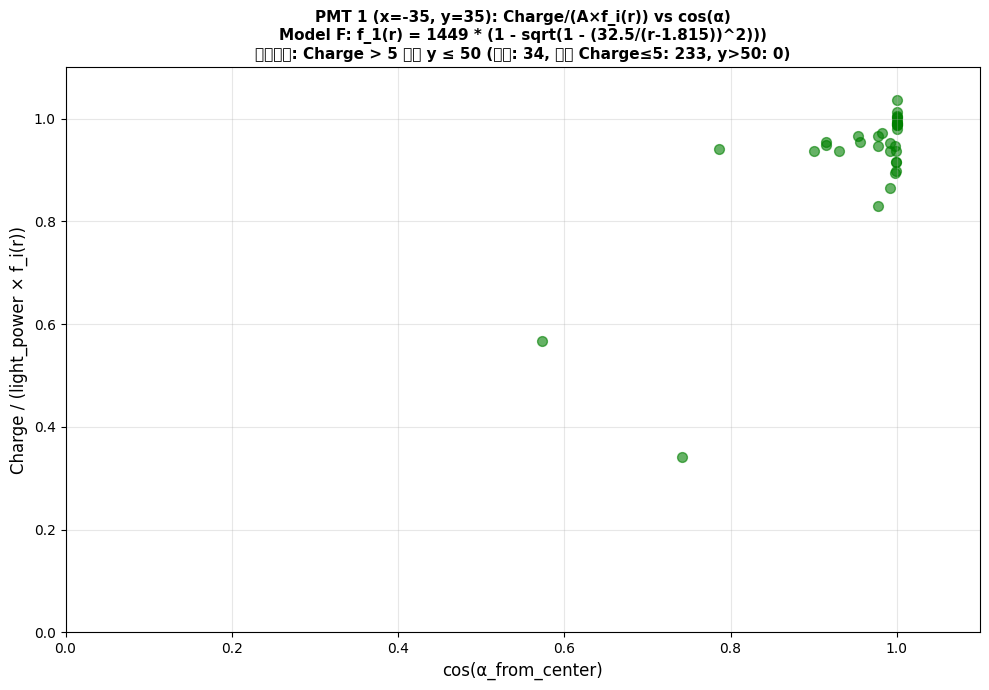

  y軸範囲: [0.3416, 1.0366]
  x軸範囲: [0.5735, 1.0000]
  r軸範囲: [39.0000, 126.5741]
  Charge範囲: [7.7562, 393.0390]

PMT 2 (x=35, y=35)
全データ点数: 267
  有限値データ点数: 267
  Charge > 5 を満たす点数: 217
  フィルタ後 (y <= 50): 217
  除外: Charge <= 5 の点数: 50
  除外: y > 50 の点数: 0
  無効/NaN 点数: 0


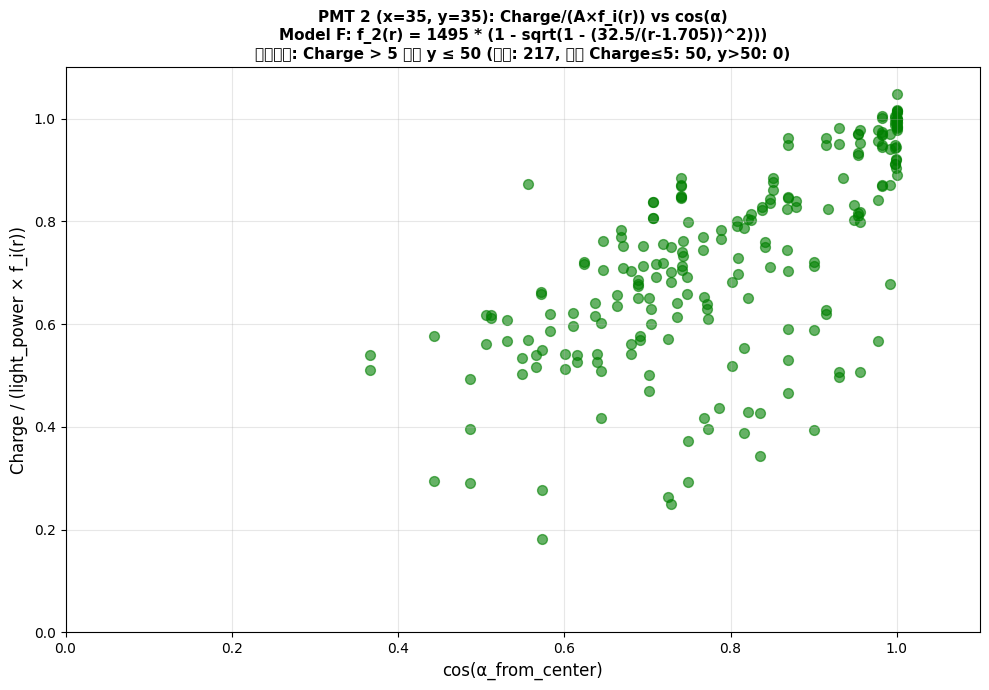

  y軸範囲: [0.1812, 1.0478]
  x軸範囲: [0.3665, 1.0000]
  r軸範囲: [39.0000, 176.4115]
  Charge範囲: [5.5315, 730.7680]

PMT 3 (x=-35, y=-35)
全データ点数: 267
  有限値データ点数: 267
  Charge > 5 を満たす点数: 217
  フィルタ後 (y <= 50): 217
  除外: Charge <= 5 の点数: 50
  除外: y > 50 の点数: 0
  無効/NaN 点数: 0


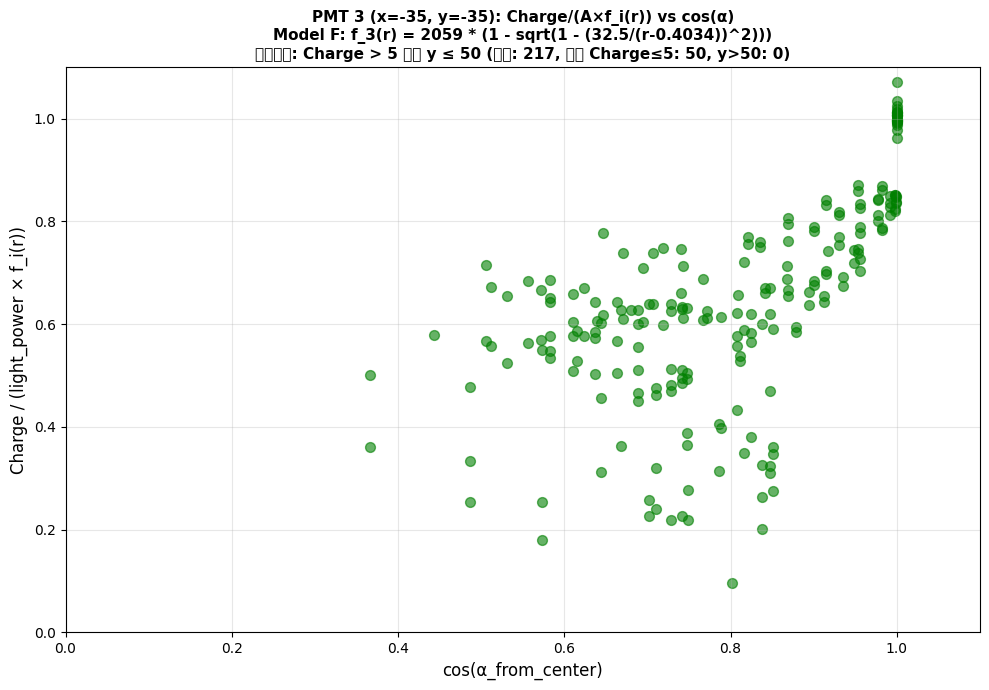

  y軸範囲: [0.0953, 1.0718]
  x軸範囲: [0.3665, 1.0000]
  r軸範囲: [39.0000, 176.4115]
  Charge範囲: [5.1420, 832.0080]

PMT 4 (x=35, y=-35)
全データ点数: 267
  有限値データ点数: 267
  Charge > 5 を満たす点数: 257
  フィルタ後 (y <= 50): 257
  除外: Charge <= 5 の点数: 10
  除外: y > 50 の点数: 0
  無効/NaN 点数: 0


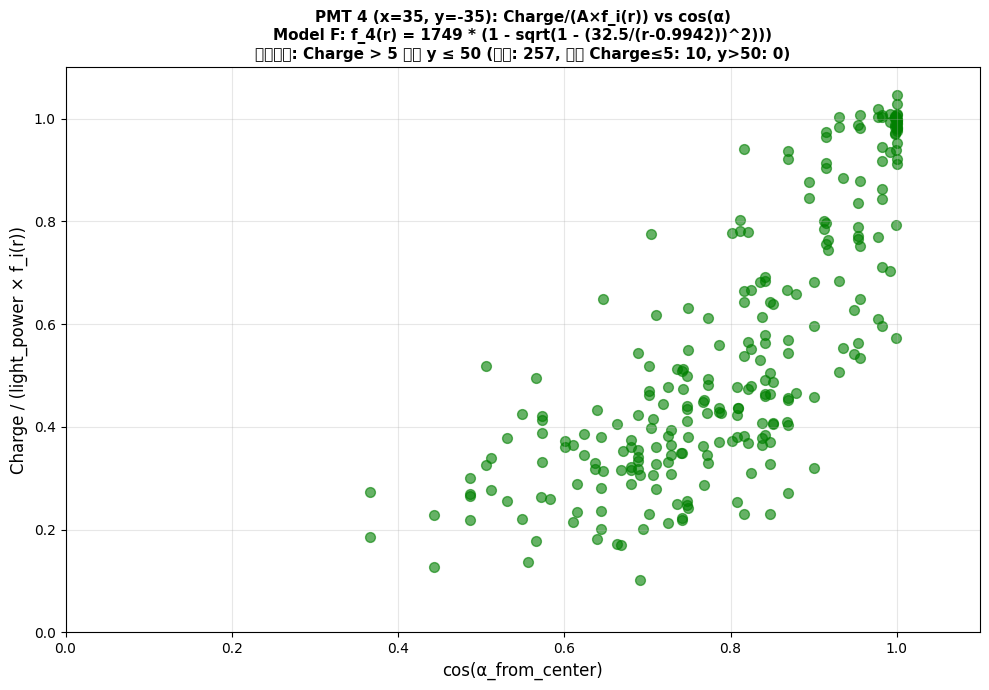

  y軸範囲: [0.1013, 1.0456]
  x軸範囲: [0.3665, 1.0000]
  r軸範囲: [39.0000, 176.4115]
  Charge範囲: [5.1283, 755.6480]

全てのグラフ作成完了


In [ ]:
# 各PMTについて Charge/(light_power*f_i(r)) vs cos(alpha_from_center) をプロット
# 条件: Charge > 5 かつ Charge/(light_power*f_i(r)) <= 50 のみ使用
import numpy as np
import matplotlib.pyplot as plt

# PMT設定
pmt_configs = [
    (1, -35, 35),
    (2, 35, 35),
    (3, -35, -35),
    (4, 35, -35)
]

print("="*100)
print("Charge/(light_power*f_i(r)) vs cos(alpha_from_center) のグラフ作成")
print("フィルタ: Charge > 5 かつ Charge/(light_power*f_i(r)) <= 50")
print("="*100)

# 各PMTについて処理
for pmt_num, x_coord, y_coord in pmt_configs:
    print(f"\n{'='*70}")
    print(f"PMT {pmt_num} (x={x_coord}, y={y_coord})")
    print('='*70)
    
    # このPMTの全データを抽出
    pmt_data = df[df['#PMT_num'] == pmt_num].copy()
    
    print(f"全データ点数: {len(pmt_data)}")
    
    # 必要な列の確認
    if 'cos(alpha_from_center)' not in pmt_data.columns:
        print("  エラー: 'cos(alpha_from_center)' 列が見つかりません")
        continue
    
    # r_from_center と f_i(r) を計算
    r_vals = pmt_data['r_from_center'].to_numpy(dtype=float)
    try:
        f_r_vals = f_funcs[pmt_num](r_vals)
    except Exception as e:
        print(f"  エラー f_{pmt_num}(r) の計算: {e}")
        continue
    
    # Charge, light_power, cos(alpha_from_center) を取得
    charge_vals = pmt_data['Charge(pC)'].to_numpy(dtype=float)
    light_power_vals = pmt_data['light_power(def:(15dB, 5V)=1)'].to_numpy(dtype=float)
    cos_alpha_vals = pmt_data['cos(alpha_from_center)'].to_numpy(dtype=float)
    
    # y軸: Charge/(light_power*f_i(r))
    y_vals = charge_vals / (light_power_vals * f_r_vals)
    
    # フィルタ: 有限値 かつ Charge > 5 かつ y <= 50
    finite_mask = np.isfinite(y_vals) & np.isfinite(cos_alpha_vals) & np.isfinite(charge_vals)
    charge_mask = charge_vals > 5
    y_mask = y_vals <= 50
    mask = finite_mask & charge_mask & y_mask
    
    y_vals_filtered = y_vals[mask]
    cos_alpha_filtered = cos_alpha_vals[mask]
    r_vals_filtered = r_vals[mask]
    charge_vals_filtered = charge_vals[mask]
    
    # 統計情報
    n_before_charge = np.sum(finite_mask)
    n_after_charge = np.sum(finite_mask & charge_mask)
    n_excluded_charge = np.sum(finite_mask & (charge_vals <= 5))
    n_excluded_y = np.sum(finite_mask & charge_mask & (y_vals > 50))
    n_invalid = np.sum(~finite_mask)
    
    print(f"  有限値データ点数: {n_before_charge}")
    print(f"  Charge > 5 を満たす点数: {n_after_charge}")
    print(f"  フィルタ後 (y <= 50): {len(y_vals_filtered)}")
    print(f"  除外: Charge <= 5 の点数: {n_excluded_charge}")
    print(f"  除外: y > 50 の点数: {n_excluded_y}")
    print(f"  無効/NaN 点数: {n_invalid}")
    
    if len(y_vals_filtered) == 0:
        print(f"  警告: PMT {pmt_num} に有効なデータがありません")
        continue
    
    # プロット
    plt.figure(figsize=(10, 7))
    plt.scatter(cos_alpha_filtered, y_vals_filtered, alpha=0.6, s=50, color='green')
    plt.xlabel('cos(α_from_center)', fontsize=12)
    plt.ylabel('Charge / (light_power × f_i(r))', fontsize=12)
    plt.title(
        f'PMT {pmt_num} (x={x_coord}, y={y_coord}): Charge/(A×f_i(r)) vs cos(α)\n'
        f'Model F: f_{pmt_num}(r) = {pmt_params_f[pmt_num]["c0"]:.4g} * (1 - sqrt(1 - (32.5/(r-{pmt_params_f[pmt_num]["c1"]:.4g}))^2)))\n'
        f'フィルタ: Charge > 5 かつ y ≤ 50 (点数: {len(y_vals_filtered)}, 除外 Charge≤5: {n_excluded_charge}, y>50: {n_excluded_y})',
        fontsize=11,
        fontweight='bold'
    )
    plt.xlim(0, 1.1)
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"  y軸範囲: [{y_vals_filtered.min():.4f}, {y_vals_filtered.max():.4f}]")
    print(f"  x軸範囲: [{cos_alpha_filtered.min():.4f}, {cos_alpha_filtered.max():.4f}]")
    print(f"  r軸範囲: [{r_vals_filtered.min():.4f}, {r_vals_filtered.max():.4f}]")
    print(f"  Charge範囲: [{charge_vals_filtered.min():.4f}, {charge_vals_filtered.max():.4f}]")

print("\n" + "="*100)
print("全てのグラフ作成完了")
print("="*100)

PMT 3: Charge/(light_power*f_3(r)) vs r_from_center
Filter: cos(alpha_from_center) ∈ [0.8, 0.9]
Total data points for PMT 3: 267
Valid finite points: 267
Points in cos range [0.8, 0.9]: 52


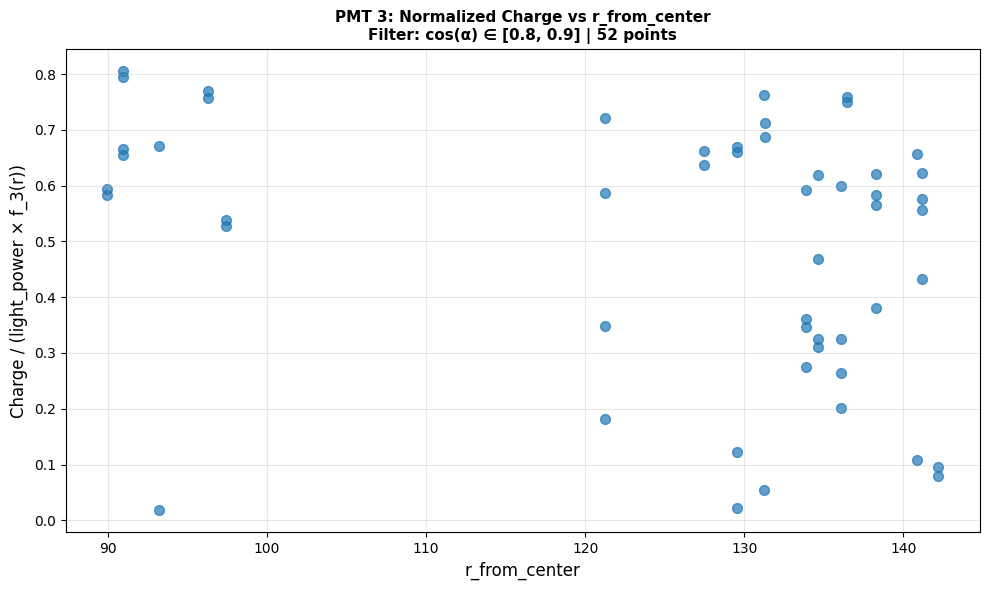

r range: [89.9500, 142.2006]
y range: [0.0177, 0.8061]


In [ ]:
# PMT 3: Charge/(light_power*f_3(r)) vs r_from_center （cos(alpha_from_center) ∈ [0.8, 0.9]）
import numpy as np
import matplotlib.pyplot as plt

pmt_num = 3
cos_min, cos_max = 0.8, 0.9

print("="*100)
print(f"PMT {pmt_num}: Charge/(light_power*f_{pmt_num}(r)) vs r_from_center")
print(f"Filter: cos(alpha_from_center) ∈ [{cos_min}, {cos_max}]")
print("="*100)

# データ抽出
pmt_data = df[df['#PMT_num'] == pmt_num].copy()
print(f"Total data points for PMT {pmt_num}: {len(pmt_data)}")

# 必要な列を取得
r_vals = pmt_data['r_from_center'].to_numpy(dtype=float)
cos_alpha = pmt_data['cos(alpha_from_center)'].to_numpy(dtype=float)
charge_vals = pmt_data['Charge(pC)'].to_numpy(dtype=float)
light_power_vals = pmt_data['light_power(def:(15dB, 5V)=1)'].to_numpy(dtype=float)

# f_3(r) を計算
f_r_vals = f_funcs[pmt_num](r_vals)

# y = Charge/(light_power*f_3(r))
y_vals = charge_vals / (light_power_vals * f_r_vals)

# フィルタ適用: 有限値 & cos範囲
finite_mask = np.isfinite(r_vals) & np.isfinite(y_vals) & np.isfinite(cos_alpha)
cos_mask = (cos_alpha >= cos_min) & (cos_alpha <= cos_max)
mask = finite_mask & cos_mask

r_filtered = r_vals[mask]
y_filtered = y_vals[mask]

print(f"Valid finite points: {np.sum(finite_mask)}")
print(f"Points in cos range [{cos_min}, {cos_max}]: {len(r_filtered)}")

if len(r_filtered) == 0:
    print("Warning: No data in the specified cos range.")
else:
    # プロット作成
    plt.figure(figsize=(10, 6))
    plt.scatter(r_filtered, y_filtered, alpha=0.7, s=50, color='tab:blue')
    plt.xlabel('r_from_center', fontsize=12)
    plt.ylabel('Charge / (light_power × f_3(r))', fontsize=12)
    plt.title(
        f'PMT {pmt_num}: Normalized Charge vs r_from_center\n'
        f'Filter: cos(α) ∈ [{cos_min}, {cos_max}] | {len(r_filtered)} points',
        fontsize=11,
        fontweight='bold'
    )
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"r range: [{r_filtered.min():.4f}, {r_filtered.max():.4f}]")
    print(f"y range: [{y_filtered.min():.4f}, {y_filtered.max():.4f}]")